In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in note"book, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook is the second attempt to read in track information and use it to predict the KDE used as input to PvFinder. This time, we are reading in poca KDEs rather than the original KDEs. 

collectdata_kde_C.py uses poca_z, poca_x, poca_y, major_axis_x, major_axis_y, and major_axis_z as the six track parameters (for the moment)


Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Sat Sep  4 19:18:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN V      Off  | 00000000:03:00.0 Off |                  N/A |
| 38%   54C    P2    52W / 250W |   3488MiB / 12066MiB |     44%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

This notebook is first attempt to read in track information and use it to predict the KDE used as input to PvFinder.


## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

##from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 200

# Name is the output file name


##  201027 -- about to go to bed, so try 2500 epochs with lr = 1e55
##  previous iteration had l4 = 3e-5 and cost dropped almost linearly
##  for 100 epochs -- final training costs ~ 2.02, validation cost ~ 2.01

## for iter 4, try 10 epochs with lr = 3e-6
## usually have a big jump down at epoch 0; want to try a
## small number of epochs per iteration and see what happens (iter4: 10 epochs gave
## traiing cost dropping from 1.54 to 1.50 immediately, then dropping very slowly)
folder = 'TEST_AllCNN_adaptive_fixedcarefulAdam'
name   = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'baileyds/AllCNN/' + folder
output = Path(folder)


# Size of batches
batch_size = 128 ## was 64
# How fast to learn
learning_rate = 1.5e-5

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
#AllCNN imports
# From model/collectdata.py
from model.collectdata_mdsA import collect_data
# For poca KDE
from model.collectdata_poca_KDE import collect_data_poca

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu, Results

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below

# From model/utilities.py
#from model.utilities import load_full_state, count_parameters, Params

from functions.my_training_kde import adaptivetrainNet
from model.plots import dual_train_plots, replace_in_ax

## adds image of model architecture
import hiddenlayer as HL

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)
# my entry 
from functions.utils import get_param_state
param_states = []

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = "cuda:0"#select_gpu(0)
##device = "cpu"

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [9]:
##print("Let's use", torch.cuda.device_count(), "GPUs!")
##if torch.cuda.device_count() > 1:
##    model = torch.nn.DataParallel(model)

In [10]:
from model.models_mjp_30Jan21 import BM_ACN_1_6L as Model

model = Model()
model.to(device)

loss = Loss(epsilon=1e-5,coefficient=2.5)

Let's move the model's weight matricies to the GPU:

In [11]:
from functions.mod_adam import epoch_Reversible_Adam
optimizer = epoch_Reversible_Adam(model.parameters(), lr=learning_rate)
##optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [12]:
# ## finished at training cost = 1.46, validation cost = 1.50
# d_folder = 'baileyds200ep_DDplus_iter3'
# d_name = d_folder
# suffix = 'final'
# dict_name = 'baileyds/DDplus/' + d_folder + '/' + d_name + '_'+ suffix + '.pyt'
# print('dict_name = ',dict_name)
# pretrained_dict = torch.load(dict_name)

# print(" ")
# print("  for pretrained_dict")
# index = 0
# for k,v in pretrained_dict.items():
#     print("index, k =  ",index,"  ",k)
#     index = index+1
 

# ##print("model_dict instantiated")
# # 1. filter out unnecessary keys
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# print("pretrained_dict iterated")
# # 2. overwrite entries in the existing state dict
# model_dict.update(pretrained_dict) 
# ##
# #   when starting from a model with a fully connected last layer rather than a convolutional layer
# # 3. load the new state dict
# #   need to use strict=False as the two models state model attributes do not agree exactly
# #   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

# model.load_state_dict(pretrained_dict,strict=False)

#mine
torch.save(model.state_dict(), output / f'{name}_init.pyt')
param_states.append(get_param_state(model))


In [13]:
##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [14]:
## This is used when training with the new KDE
train_loader = collect_data_poca('/share/lazy/will/data/June30_2020_80k_1.h5',
                            '/share/lazy/will/data/June30_2020_80k_3.h5',
                            batch_size=batch_size,
 #                           device=device,
                            masking=True,
                            shuffle=True,
                           ## slice = slice(0,18000)
                           )

val_loader = collect_data_poca('/share/lazy/sokoloff/ML-data_AA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
  #                          device=device,
                            masking=True,
                            shuffle=True,
                            ##slice = slice(18000,None)
                           )

Loading data...
Loaded /share/lazy/will/data/June30_2020_80k_1.h5 in 18.29 s
Loaded /share/lazy/will/data/June30_2020_80k_3.h5 in 20.59 s
Constructing 160000 event dataset took 0.9212 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/20K_POCA_kernel_evts_200926.h5 in 4.993 s
Constructing 20000 event dataset took 0.08285 s


<IPython.core.display.Javascript object>


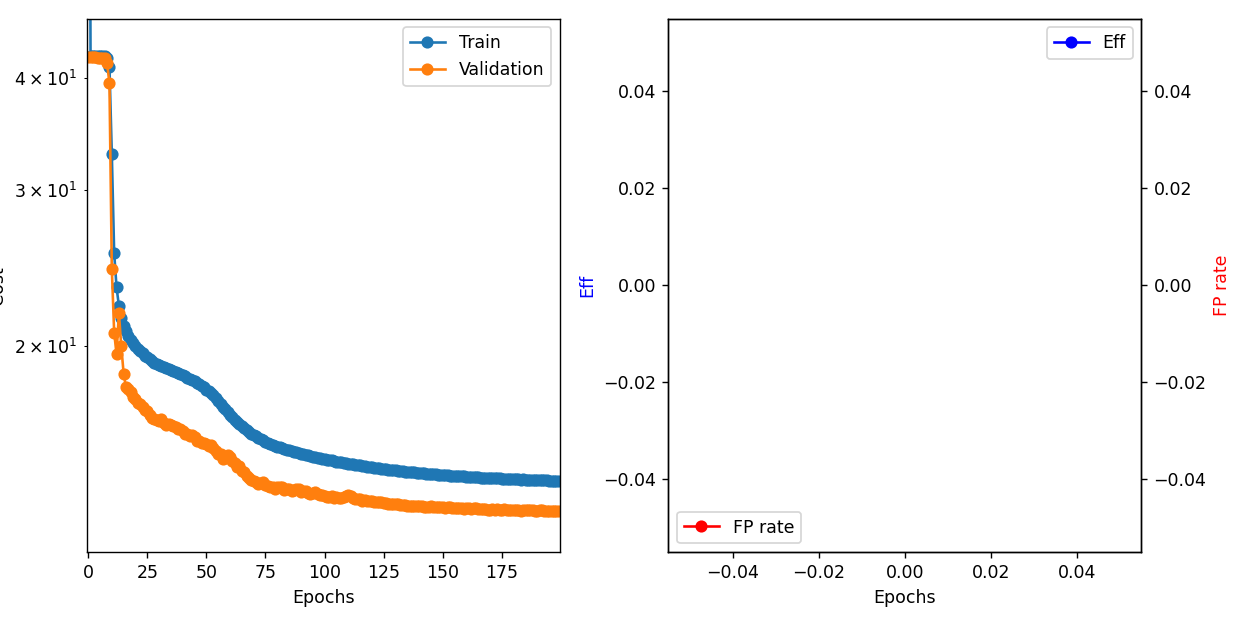

In [15]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [16]:
for result in adaptivetrainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        loss_increase_limit = 0.02, lr_factor = 0.8, lr_increase_factor = 0.15,
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')
    #mine
    param_states.append(get_param_state(model))

Number of batches: train = 1250, val = 157


Number of batches: train = 1250, val = 157


new cost: 290.46698876953127 | old cost: 1000000.0
Epoch 0: train=290.467, val=42.2571, took 278.72 s


new cost: 42.425159103393554 | old cost: 290.46698876953127
[tensor(1.1943, device='cuda:0'), tensor(0.0385, device='cuda:0'), tensor(6.6388, device='cuda:0'), tensor(0.0627, device='cuda:0'), tensor(3.6969, device='cuda:0'), tensor(0.0272, device='cuda:0'), tensor(0.9795, device='cuda:0'), tensor(0.0152, device='cuda:0'), tensor(0.2174, device='cuda:0'), tensor(0.0082, device='cuda:0'), tensor(-145596.4062, device='cuda:0'), tensor(-20.1494, device='cuda:0')]
num: tensor(5.8423, device='cuda:0')
denom: tensor(23.2593, device='cuda:0')
dot: 0.25117952 | ratio: 1.037676927447319
lr changed to 1.5565153911709784e-05
Epoch 1: train=42.4252, val=42.2358, took 275.62 s


new cost: 42.411572564697266 | old cost: 42.425159103393554
[tensor(0.0176, device='cuda:0'), tensor(-2.8087e-05, device='cuda:0'), tensor(0.2114, device='cuda:0'), tensor(0.0001, device='cuda:0'), tensor(0.0185, device='cuda:0'), tensor(8.2024e-05, device='cuda:0'), tensor(0.0041, device='cuda:0'), tensor(3.8105e-05, device='cuda:0'), tensor(0.0003, device='cuda:0'), tensor(9.3887e-06, device='cuda:0'), tensor(-285.9948, device='cuda:0'), tensor(-0.0174, device='cuda:0')]
num: tensor(0.3083, device='cuda:0')
denom: tensor(0.3408, device='cuda:0')
dot: 0.90474087 | ratio: 1.1357111304998397
lr changed to 1.7677518545471922e-05
Epoch 2: train=42.4116, val=42.2283, took 270.56 s


new cost: 42.4057109375 | old cost: 42.411572564697266
[tensor(0.0083, device='cuda:0'), tensor(-0.0008, device='cuda:0'), tensor(0.4032, device='cuda:0'), tensor(-1.8932e-06, device='cuda:0'), tensor(0.0060, device='cuda:0'), tensor(-5.3817e-06, device='cuda:0'), tensor(0.0016, device='cuda:0'), tensor(-1.8169e-06, device='cuda:0'), tensor(0.0001, device='cuda:0'), tensor(-6.1458e-07, device='cuda:0'), tensor(-79.6014, device='cuda:0'), tensor(0.0094, device='cuda:0')]
num: tensor(0.2872, device='cuda:0')
denom: tensor(0.3469, device='cuda:0')
dot: 0.82791144 | ratio: 1.1241867154836656
lr changed to 1.9872831511535664e-05
Epoch 3: train=42.4057, val=42.2226, took 269.28 s


new cost: 42.39951930541992 | old cost: 42.4057109375
[tensor(-0.0831, device='cuda:0'), tensor(-0.0042, device='cuda:0'), tensor(0.6502, device='cuda:0'), tensor(-7.0045e-05, device='cuda:0'), tensor(0.0005, device='cuda:0'), tensor(-4.7362e-05, device='cuda:0'), tensor(0.0008, device='cuda:0'), tensor(-2.0430e-05, device='cuda:0'), tensor(9.9988e-05, device='cuda:0'), tensor(-5.4591e-06, device='cuda:0'), tensor(-15.3019, device='cuda:0'), tensor(0.0289, device='cuda:0')]
num: tensor(0.5438, device='cuda:0')
denom: tensor(0.6607, device='cuda:0')
dot: 0.8231642 | ratio: 1.1234746336936952
lr changed to 2.232662210287905e-05
Epoch 4: train=42.3995, val=42.2156, took 256.43 s


new cost: 42.39175253601074 | old cost: 42.39951930541992
[tensor(-0.2535, device='cuda:0'), tensor(-0.0160, device='cuda:0'), tensor(0.7252, device='cuda:0'), tensor(-6.6457e-05, device='cuda:0'), tensor(-0.0053, device='cuda:0'), tensor(-4.7886e-05, device='cuda:0'), tensor(0.0003, device='cuda:0'), tensor(-1.8928e-05, device='cuda:0'), tensor(1.9979e-05, device='cuda:0'), tensor(-6.2437e-06, device='cuda:0'), tensor(20.8185, device='cuda:0'), tensor(0.0484, device='cuda:0')]
num: tensor(1.1771, device='cuda:0')
denom: tensor(1.4866, device='cuda:0')
dot: 0.7918101 | ratio: 1.1187715142965318
lr changed to 2.4978388819164413e-05
Epoch 5: train=42.3918, val=42.2074, took 261.63 s


new cost: 42.38575272216797 | old cost: 42.39175253601074
[tensor(0.4855, device='cuda:0'), tensor(-0.0022, device='cuda:0'), tensor(-2.2656, device='cuda:0'), tensor(0.0001, device='cuda:0'), tensor(0.0019, device='cuda:0'), tensor(4.2627e-05, device='cuda:0'), tensor(0.0026, device='cuda:0'), tensor(2.5711e-05, device='cuda:0'), tensor(1.3998e-05, device='cuda:0'), tensor(2.4442e-06, device='cuda:0'), tensor(125.7245, device='cuda:0'), tensor(0.0608, device='cuda:0')]
num: tensor(1.3623, device='cuda:0')
denom: tensor(2.2675, device='cuda:0')
dot: 0.6007819 | ratio: 1.0901172876358032
lr changed to 2.7229373469059982e-05
Epoch 6: train=42.3858, val=42.204, took 272.05 s


new cost: 42.38003243713379 | old cost: 42.38575272216797
[tensor(0.3890, device='cuda:0'), tensor(0.0171, device='cuda:0'), tensor(-5.9161, device='cuda:0'), tensor(0.0006, device='cuda:0'), tensor(0.0140, device='cuda:0'), tensor(0.0003, device='cuda:0'), tensor(0.0098, device='cuda:0'), tensor(0.0002, device='cuda:0'), tensor(0.0002, device='cuda:0'), tensor(2.9096e-05, device='cuda:0'), tensor(-955.5922, device='cuda:0'), tensor(0.0498, device='cuda:0')]
num: tensor(2.2435, device='cuda:0')
denom: tensor(4.0308, device='cuda:0')
dot: 0.5565833 | ratio: 1.0834874927997589
lr changed to 2.950268559050007e-05
Epoch 7: train=42.38, val=42.19, took 285.59 s


new cost: 42.143232055664065 | old cost: 42.38003243713379
[tensor(-4.7164, device='cuda:0'), tensor(0.0164, device='cuda:0'), tensor(-11.6099, device='cuda:0'), tensor(0.0131, device='cuda:0'), tensor(-1.9688, device='cuda:0'), tensor(0.0068, device='cuda:0'), tensor(-0.3925, device='cuda:0'), tensor(0.0028, device='cuda:0'), tensor(-0.0213, device='cuda:0'), tensor(0.0007, device='cuda:0'), tensor(-9417.2617, device='cuda:0'), tensor(-0.5654, device='cuda:0')]
num: tensor(9.9741, device='cuda:0')
denom: tensor(18.4198, device='cuda:0')
dot: 0.5414866 | ratio: 1.0812229931354522
lr changed to 3.1898982019694666e-05
Epoch 8: train=42.1432, val=41.5929, took 290.67 s


new cost: 41.18198827819824 | old cost: 42.143232055664065
[tensor(2.5695, device='cuda:0'), tensor(0.1940, device='cuda:0'), tensor(44.2937, device='cuda:0'), tensor(0.0127, device='cuda:0'), tensor(-3.1571, device='cuda:0'), tensor(0.0076, device='cuda:0'), tensor(-1.4104, device='cuda:0'), tensor(-0.0035, device='cuda:0'), tensor(0.3107, device='cuda:0'), tensor(0.0010, device='cuda:0'), tensor(2343.4492, device='cuda:0'), tensor(0.2256, device='cuda:0')]
num: tensor(20.6525, device='cuda:0')
denom: tensor(44.3018, device='cuda:0')
dot: 0.4661778 | ratio: 1.069926668703556
lr changed to 3.412957156736655e-05
Epoch 9: train=41.182, val=39.4844, took 289.6 s


new cost: 32.90215669708252 | old cost: 41.18198827819824
[tensor(-3.6147, device='cuda:0'), tensor(-0.1581, device='cuda:0'), tensor(1.4390, device='cuda:0'), tensor(-0.0053, device='cuda:0'), tensor(-13.3798, device='cuda:0'), tensor(-0.0956, device='cuda:0'), tensor(-4.2973, device='cuda:0'), tensor(-0.0198, device='cuda:0'), tensor(0.0614, device='cuda:0'), tensor(0.0025, device='cuda:0'), tensor(-2567.4854, device='cuda:0'), tensor(-0.8353, device='cuda:0')]
num: tensor(25.1762, device='cuda:0')
denom: tensor(51.1644, device='cuda:0')
dot: 0.4920652 | ratio: 1.0738097786903382
lr changed to 3.664866769154993e-05
Epoch 10: train=32.9022, val=24.4385, took 289.28 s


new cost: 25.43985806274414 | old cost: 32.90215669708252
[tensor(2.8233, device='cuda:0'), tensor(0.0062, device='cuda:0'), tensor(-15.6612, device='cuda:0'), tensor(-0.0214, device='cuda:0'), tensor(15.2590, device='cuda:0'), tensor(0.1431, device='cuda:0'), tensor(4.2074, device='cuda:0'), tensor(0.0408, device='cuda:0'), tensor(0.2187, device='cuda:0'), tensor(-0.0051, device='cuda:0'), tensor(8149.8833, device='cuda:0'), tensor(1.2665, device='cuda:0')]
num: tensor(18.7264, device='cuda:0')
denom: tensor(39.6767, device='cuda:0')
dot: 0.47197524 | ratio: 1.0707962855696678
lr changed to 3.9243257235188754e-05
Epoch 11: train=25.4399, val=20.7241, took 289.89 s


new cost: 23.297289971923828 | old cost: 25.43985806274414
[tensor(1.1326, device='cuda:0'), tensor(-0.0093, device='cuda:0'), tensor(-4.5469, device='cuda:0'), tensor(0.0015, device='cuda:0'), tensor(2.6276, device='cuda:0'), tensor(-0.0078, device='cuda:0'), tensor(2.6156, device='cuda:0'), tensor(-0.0014, device='cuda:0'), tensor(-0.2948, device='cuda:0'), tensor(-0.0004, device='cuda:0'), tensor(1401.4910, device='cuda:0'), tensor(0.3173, device='cuda:0')]
num: tensor(8.6493, device='cuda:0')
denom: tensor(18.4035, device='cuda:0')
dot: 0.4699823 | ratio: 1.0704973444342614
lr changed to 4.200980265722017e-05
Epoch 12: train=23.2973, val=19.5937, took 289.89 s


new cost: 22.208865547180174 | old cost: 23.297289971923828
[tensor(0.8410, device='cuda:0'), tensor(-0.0169, device='cuda:0'), tensor(-2.8242, device='cuda:0'), tensor(0.0003, device='cuda:0'), tensor(-0.3160, device='cuda:0'), tensor(-0.0090, device='cuda:0'), tensor(0.5048, device='cuda:0'), tensor(-0.0031, device='cuda:0'), tensor(-0.1521, device='cuda:0'), tensor(-0.0003, device='cuda:0'), tensor(563.5643, device='cuda:0'), tensor(0.1696, device='cuda:0')]
num: tensor(4.4761, device='cuda:0')
denom: tensor(13.5149, device='cuda:0')
dot: 0.33119705 | ratio: 1.049679557979107
lr changed to 4.409683108402038e-05
Epoch 13: train=22.2089, val=21.808, took 289.4 s


new cost: 21.545614279174806 | old cost: 22.208865547180174
[tensor(0.6561, device='cuda:0'), tensor(-0.0092, device='cuda:0'), tensor(-2.1792, device='cuda:0'), tensor(0.0008, device='cuda:0'), tensor(-0.1108, device='cuda:0'), tensor(-0.0024, device='cuda:0'), tensor(-0.2053, device='cuda:0'), tensor(-0.0003, device='cuda:0'), tensor(-0.0811, device='cuda:0'), tensor(-0.0002, device='cuda:0'), tensor(313.9808, device='cuda:0'), tensor(0.1112, device='cuda:0')]
num: tensor(2.7843, device='cuda:0')
denom: tensor(12.3774, device='cuda:0')
dot: 0.22495367 | ratio: 1.0337430499494076
lr changed to 4.558479265789907e-05
Epoch 14: train=21.5456, val=19.999, took 290.36 s


new cost: 21.090996701049804 | old cost: 21.545614279174806
[tensor(0.3628, device='cuda:0'), tensor(-0.0082, device='cuda:0'), tensor(-1.1806, device='cuda:0'), tensor(0.0013, device='cuda:0'), tensor(-0.0392, device='cuda:0'), tensor(0.0002, device='cuda:0'), tensor(-0.3059, device='cuda:0'), tensor(0.0004, device='cuda:0'), tensor(-0.0245, device='cuda:0'), tensor(-4.3101e-05, device='cuda:0'), tensor(185.6990, device='cuda:0'), tensor(0.0663, device='cuda:0')]
num: tensor(1.9002, device='cuda:0')
denom: tensor(12.1952, device='cuda:0')
dot: 0.15581623 | ratio: 1.023372434079647
lr changed to 4.6650220219330194e-05
Epoch 15: train=21.091, val=18.6403, took 289.49 s


new cost: 20.798771226501465 | old cost: 21.090996701049804
[tensor(0.0944, device='cuda:0'), tensor(0.0037, device='cuda:0'), tensor(-0.5899, device='cuda:0'), tensor(0.0008, device='cuda:0'), tensor(-0.0818, device='cuda:0'), tensor(-0.0007, device='cuda:0'), tensor(-0.1455, device='cuda:0'), tensor(0.0007, device='cuda:0'), tensor(0.0006, device='cuda:0'), tensor(0.0001, device='cuda:0'), tensor(56.9970, device='cuda:0'), tensor(0.0372, device='cuda:0')]
num: tensor(1.3245, device='cuda:0')
denom: tensor(12.3115, device='cuda:0')
dot: 0.10758584 | ratio: 1.0161378759890796
lr changed to 4.7403055688093e-05
Epoch 16: train=20.7988, val=17.9816, took 288.89 s


new cost: 20.53142951965332 | old cost: 20.798771226501465
[tensor(0.0934, device='cuda:0'), tensor(0.0045, device='cuda:0'), tensor(-0.1939, device='cuda:0'), tensor(0.0006, device='cuda:0'), tensor(0.0850, device='cuda:0'), tensor(-0.0030, device='cuda:0'), tensor(0.0377, device='cuda:0'), tensor(-2.9139e-05, device='cuda:0'), tensor(0.0126, device='cuda:0'), tensor(0.0001, device='cuda:0'), tensor(23.4322, device='cuda:0'), tensor(0.0231, device='cuda:0')]
num: tensor(0.9389, device='cuda:0')
denom: tensor(12.4420, device='cuda:0')
dot: 0.07546407 | ratio: 1.0113196104764939
lr changed to 4.793963981387776e-05
Epoch 17: train=20.5314, val=17.9279, took 289.58 s


new cost: 20.349919357299804 | old cost: 20.53142951965332
[tensor(0.0589, device='cuda:0'), tensor(0.0034, device='cuda:0'), tensor(-0.3393, device='cuda:0'), tensor(-0.0009, device='cuda:0'), tensor(-0.0150, device='cuda:0'), tensor(-0.0043, device='cuda:0'), tensor(0.1931, device='cuda:0'), tensor(-0.0004, device='cuda:0'), tensor(-0.0098, device='cuda:0'), tensor(0.0001, device='cuda:0'), tensor(17.8637, device='cuda:0'), tensor(0.0128, device='cuda:0')]
num: tensor(0.6852, device='cuda:0')
denom: tensor(12.5440, device='cuda:0')
dot: 0.054625895 | ratio: 1.0081938842311502
lr changed to 4.833245167259571e-05
Epoch 18: train=20.3499, val=17.7486, took 289.33 s


new cost: 20.17675951538086 | old cost: 20.349919357299804
[tensor(0.0197, device='cuda:0'), tensor(0.0038, device='cuda:0'), tensor(0.1383, device='cuda:0'), tensor(-0.0022, device='cuda:0'), tensor(0.1666, device='cuda:0'), tensor(-0.0096, device='cuda:0'), tensor(-0.0152, device='cuda:0'), tensor(-0.0019, device='cuda:0'), tensor(0.0193, device='cuda:0'), tensor(3.6170e-05, device='cuda:0'), tensor(30.9094, device='cuda:0'), tensor(0.0180, device='cuda:0')]
num: tensor(0.4888, device='cuda:0')
denom: tensor(12.6297, device='cuda:0')
dot: 0.038703926 | ratio: 1.0058055888861417
lr changed to 4.8613050016866114e-05
Epoch 19: train=20.1768, val=17.524, took 289.47 s


new cost: 20.028982466125488 | old cost: 20.17675951538086
[tensor(0.0648, device='cuda:0'), tensor(0.0010, device='cuda:0'), tensor(-0.0517, device='cuda:0'), tensor(-0.0015, device='cuda:0'), tensor(-0.2153, device='cuda:0'), tensor(-0.0100, device='cuda:0'), tensor(0.0579, device='cuda:0'), tensor(-0.0008, device='cuda:0'), tensor(0.0151, device='cuda:0'), tensor(1.1865e-05, device='cuda:0'), tensor(2.3829, device='cuda:0'), tensor(0.0068, device='cuda:0')]
num: tensor(0.3551, device='cuda:0')
denom: tensor(12.6924, device='cuda:0')
dot: 0.027977344 | ratio: 1.0041966015473007
lr changed to 4.8817059617785904e-05
Epoch 20: train=20.029, val=17.4462, took 287.31 s


new cost: 19.881097749328614 | old cost: 20.028982466125488
[tensor(-0.0279, device='cuda:0'), tensor(-0.0114, device='cuda:0'), tensor(0.0563, device='cuda:0'), tensor(-0.0040, device='cuda:0'), tensor(0.1337, device='cuda:0'), tensor(-0.0096, device='cuda:0'), tensor(0.3002, device='cuda:0'), tensor(-0.0023, device='cuda:0'), tensor(0.0080, device='cuda:0'), tensor(-3.2750e-05, device='cuda:0'), tensor(22.3854, device='cuda:0'), tensor(0.0189, device='cuda:0')]
num: tensor(0.2428, device='cuda:0')
denom: tensor(12.7564, device='cuda:0')
dot: 0.019032909 | ratio: 1.0028549362905324
lr changed to 4.8956429212885804e-05
Epoch 21: train=19.8811, val=17.2609, took 290.58 s


new cost: 19.751478950500488 | old cost: 19.881097749328614
[tensor(0.0645, device='cuda:0'), tensor(0.0019, device='cuda:0'), tensor(-0.0325, device='cuda:0'), tensor(-0.0023, device='cuda:0'), tensor(0.3858, device='cuda:0'), tensor(-0.0009, device='cuda:0'), tensor(-0.0165, device='cuda:0'), tensor(-0.0024, device='cuda:0'), tensor(0.0355, device='cuda:0'), tensor(2.6132e-05, device='cuda:0'), tensor(-51.5192, device='cuda:0'), tensor(0.0057, device='cuda:0')]
num: tensor(0.1560, device='cuda:0')
denom: tensor(12.7828, device='cuda:0')
dot: 0.012204693 | ratio: 1.0018307039048522
lr changed to 4.904605393901345e-05
Epoch 22: train=19.7515, val=17.2489, took 288.85 s


new cost: 19.640751525878905 | old cost: 19.751478950500488
[tensor(-0.1279, device='cuda:0'), tensor(-0.0060, device='cuda:0'), tensor(-0.0308, device='cuda:0'), tensor(-0.0022, device='cuda:0'), tensor(0.1086, device='cuda:0'), tensor(-0.0041, device='cuda:0'), tensor(0.1625, device='cuda:0'), tensor(-0.0041, device='cuda:0'), tensor(0.0239, device='cuda:0'), tensor(4.0349e-05, device='cuda:0'), tensor(6.5328, device='cuda:0'), tensor(0.0311, device='cuda:0')]
num: tensor(0.0774, device='cuda:0')
denom: tensor(12.7917, device='cuda:0')
dot: 0.0060544293 | ratio: 1.0009081644006073
lr changed to 4.9090595819191124e-05
Epoch 23: train=19.6408, val=17.0971, took 288.59 s


new cost: 19.520544888305665 | old cost: 19.640751525878905
[tensor(0.0781, device='cuda:0'), tensor(-0.0019, device='cuda:0'), tensor(0.1527, device='cuda:0'), tensor(-0.0016, device='cuda:0'), tensor(0.4508, device='cuda:0'), tensor(-0.0022, device='cuda:0'), tensor(0.0612, device='cuda:0'), tensor(-0.0003, device='cuda:0'), tensor(0.0254, device='cuda:0'), tensor(-7.9871e-06, device='cuda:0'), tensor(14.7146, device='cuda:0'), tensor(0.0021, device='cuda:0')]
num: tensor(0.0573, device='cuda:0')
denom: tensor(12.8121, device='cuda:0')
dot: 0.0044714874 | ratio: 1.0006707231048495
lr changed to 4.912352201603788e-05
Epoch 24: train=19.5205, val=16.9474, took 284.97 s


new cost: 19.43696400756836 | old cost: 19.520544888305665
[tensor(0.0553, device='cuda:0'), tensor(0.0025, device='cuda:0'), tensor(0.0242, device='cuda:0'), tensor(-0.0015, device='cuda:0'), tensor(0.0459, device='cuda:0'), tensor(-0.0009, device='cuda:0'), tensor(-0.1418, device='cuda:0'), tensor(-0.0008, device='cuda:0'), tensor(0.0081, device='cuda:0'), tensor(1.7384e-05, device='cuda:0'), tensor(22.7224, device='cuda:0'), tensor(0.0059, device='cuda:0')]
num: tensor(-0.0171, device='cuda:0')
denom: tensor(12.8032, device='cuda:0')
dot: -0.0013333497 | ratio: 0.999799997539958
lr changed to 4.9113697190788746e-05
Epoch 25: train=19.437, val=16.9115, took 282.26 s


new cost: 19.333049996948244 | old cost: 19.43696400756836
[tensor(0.0260, device='cuda:0'), tensor(-0.0008, device='cuda:0'), tensor(0.1752, device='cuda:0'), tensor(1.1088e-05, device='cuda:0'), tensor(0.5826, device='cuda:0'), tensor(0.0018, device='cuda:0'), tensor(0.1085, device='cuda:0'), tensor(-0.0011, device='cuda:0'), tensor(0.0121, device='cuda:0'), tensor(-6.9306e-05, device='cuda:0'), tensor(-18.4374, device='cuda:0'), tensor(-0.0098, device='cuda:0')]
num: tensor(-0.0351, device='cuda:0')
denom: tensor(12.7694, device='cuda:0')
dot: -0.002751692 | ratio: 0.999587246205192
lr changed to 4.90934253258962e-05
Epoch 26: train=19.333, val=16.7614, took 255.97 s


new cost: 19.243227026367187 | old cost: 19.333049996948244
[tensor(-0.1178, device='cuda:0'), tensor(-0.0038, device='cuda:0'), tensor(0.1148, device='cuda:0'), tensor(-0.0004, device='cuda:0'), tensor(-0.1953, device='cuda:0'), tensor(-0.0029, device='cuda:0'), tensor(-0.1207, device='cuda:0'), tensor(-0.0005, device='cuda:0'), tensor(0.0090, device='cuda:0'), tensor(9.2849e-05, device='cuda:0'), tensor(-14.9749, device='cuda:0'), tensor(0.0038, device='cuda:0')]
num: tensor(-0.0668, device='cuda:0')
denom: tensor(12.7364, device='cuda:0')
dot: -0.0052452083 | ratio: 0.9992132187588141
lr changed to 4.905479953978422e-05
Epoch 27: train=19.2432, val=16.6096, took 275.94 s


new cost: 19.176094830322267 | old cost: 19.243227026367187
[tensor(-0.0419, device='cuda:0'), tensor(0.0048, device='cuda:0'), tensor(0.3991, device='cuda:0'), tensor(0.0017, device='cuda:0'), tensor(0.1160, device='cuda:0'), tensor(0.0011, device='cuda:0'), tensor(-0.1185, device='cuda:0'), tensor(-0.0008, device='cuda:0'), tensor(0.0050, device='cuda:0'), tensor(7.9173e-05, device='cuda:0'), tensor(-12.4958, device='cuda:0'), tensor(-0.0160, device='cuda:0')]
num: tensor(-0.1433, device='cuda:0')
denom: tensor(12.7005, device='cuda:0')
dot: -0.011284588 | ratio: 0.9983073118142783
lr changed to 4.8971765060150285e-05
Epoch 28: train=19.1761, val=16.5768, took 284.17 s


new cost: 19.105342852020264 | old cost: 19.176094830322267
[tensor(-0.1634, device='cuda:0'), tensor(-0.0032, device='cuda:0'), tensor(0.2360, device='cuda:0'), tensor(0.0003, device='cuda:0'), tensor(0.4304, device='cuda:0'), tensor(0.0018, device='cuda:0'), tensor(-0.1871, device='cuda:0'), tensor(-0.0004, device='cuda:0'), tensor(0.0009, device='cuda:0'), tensor(7.5714e-05, device='cuda:0'), tensor(54.2509, device='cuda:0'), tensor(0.0068, device='cuda:0')]
num: tensor(-0.1481, device='cuda:0')
denom: tensor(12.6381, device='cuda:0')
dot: -0.011717826 | ratio: 0.9982423260807991
lr changed to 4.8885688665926826e-05
Epoch 29: train=19.1053, val=16.5501, took 290.21 s


new cost: 19.053607731628418 | old cost: 19.105342852020264
[tensor(-0.0022, device='cuda:0'), tensor(0.0035, device='cuda:0'), tensor(0.4480, device='cuda:0'), tensor(-0.0007, device='cuda:0'), tensor(-0.2587, device='cuda:0'), tensor(-0.0098, device='cuda:0'), tensor(-0.0443, device='cuda:0'), tensor(-0.0008, device='cuda:0'), tensor(-0.0013, device='cuda:0'), tensor(-6.9453e-06, device='cuda:0'), tensor(-56.7206, device='cuda:0'), tensor(-0.0065, device='cuda:0')]
num: tensor(-0.2296, device='cuda:0')
denom: tensor(12.5929, device='cuda:0')
dot: -0.018236386 | ratio: 0.9972645421512425
lr changed to 4.8751963925173704e-05
Epoch 30: train=19.0536, val=16.507, took 286.79 s


new cost: 19.00955520019531 | old cost: 19.053607731628418
[tensor(-0.0806, device='cuda:0'), tensor(-0.0006, device='cuda:0'), tensor(-0.6244, device='cuda:0'), tensor(0.0024, device='cuda:0'), tensor(-0.2611, device='cuda:0'), tensor(-0.0051, device='cuda:0'), tensor(-0.1959, device='cuda:0'), tensor(0.0007, device='cuda:0'), tensor(-0.0078, device='cuda:0'), tensor(8.0936e-05, device='cuda:0'), tensor(9.6439, device='cuda:0'), tensor(-0.0084, device='cuda:0')]
num: tensor(-0.2202, device='cuda:0')
denom: tensor(12.5373, device='cuda:0')
dot: -0.017559644 | ratio: 0.9973660534247756
lr changed to 4.862355385675753e-05
Epoch 31: train=19.0096, val=16.5588, took 285.38 s


new cost: 18.965391667175293 | old cost: 19.00955520019531
[tensor(-0.0578, device='cuda:0'), tensor(-0.0013, device='cuda:0'), tensor(0.5042, device='cuda:0'), tensor(-0.0001, device='cuda:0'), tensor(-0.1286, device='cuda:0'), tensor(4.3481e-05, device='cuda:0'), tensor(0.0913, device='cuda:0'), tensor(0.0002, device='cuda:0'), tensor(-0.0048, device='cuda:0'), tensor(1.9822e-05, device='cuda:0'), tensor(44.3145, device='cuda:0'), tensor(-0.0045, device='cuda:0')]
num: tensor(-0.2552, device='cuda:0')
denom: tensor(12.5921, device='cuda:0')
dot: -0.020269047 | ratio: 0.9969596428796649
lr changed to 4.847572088857314e-05
Epoch 32: train=18.9654, val=16.4221, took 285.88 s


new cost: 18.913500936889648 | old cost: 18.965391667175293
[tensor(-0.1725, device='cuda:0'), tensor(-0.0044, device='cuda:0'), tensor(0.0367, device='cuda:0'), tensor(0.0002, device='cuda:0'), tensor(0.0040, device='cuda:0'), tensor(0.0004, device='cuda:0'), tensor(-0.1592, device='cuda:0'), tensor(-0.0009, device='cuda:0'), tensor(0.0144, device='cuda:0'), tensor(-8.0190e-06, device='cuda:0'), tensor(-14.7346, device='cuda:0'), tensor(0.0097, device='cuda:0')]
num: tensor(-0.2356, device='cuda:0')
denom: tensor(12.6213, device='cuda:0')
dot: -0.018666878 | ratio: 0.9971999682486057
lr changed to 4.83399873309134e-05
Epoch 33: train=18.9135, val=16.2982, took 285.55 s


new cost: 18.865079482269287 | old cost: 18.913500936889648
[tensor(-0.0081, device='cuda:0'), tensor(0.0002, device='cuda:0'), tensor(-0.1707, device='cuda:0'), tensor(0.0005, device='cuda:0'), tensor(-0.0486, device='cuda:0'), tensor(0.0020, device='cuda:0'), tensor(-0.3075, device='cuda:0'), tensor(-0.0003, device='cuda:0'), tensor(-0.0041, device='cuda:0'), tensor(0.0001, device='cuda:0'), tensor(-3.0974, device='cuda:0'), tensor(-0.0178, device='cuda:0')]
num: tensor(-0.2527, device='cuda:0')
denom: tensor(12.4715, device='cuda:0')
dot: -0.020264179 | ratio: 0.9969603732228279
lr changed to 4.81930518110142e-05
Epoch 34: train=18.8651, val=16.3384, took 286.54 s


new cost: 18.815077383422853 | old cost: 18.865079482269287
[tensor(0.0561, device='cuda:0'), tensor(0.0039, device='cuda:0'), tensor(-0.2481, device='cuda:0'), tensor(0.0011, device='cuda:0'), tensor(0.1343, device='cuda:0'), tensor(0.0044, device='cuda:0'), tensor(0.3166, device='cuda:0'), tensor(0.0004, device='cuda:0'), tensor(0.0158, device='cuda:0'), tensor(2.7315e-05, device='cuda:0'), tensor(-53.3295, device='cuda:0'), tensor(-0.0423, device='cuda:0')]
num: tensor(-0.2310, device='cuda:0')
denom: tensor(12.8219, device='cuda:0')
dot: -0.018012453 | ratio: 0.9972981320694089
lr changed to 4.8062840549848706e-05
Epoch 35: train=18.8151, val=16.3145, took 286.35 s


new cost: 18.773460266113283 | old cost: 18.815077383422853
[tensor(-0.0762, device='cuda:0'), tensor(-0.0022, device='cuda:0'), tensor(0.1342, device='cuda:0'), tensor(-0.0006, device='cuda:0'), tensor(-0.3045, device='cuda:0'), tensor(-0.0019, device='cuda:0'), tensor(0.0052, device='cuda:0'), tensor(0.0005, device='cuda:0'), tensor(0.0029, device='cuda:0'), tensor(-1.4547e-05, device='cuda:0'), tensor(28.9524, device='cuda:0'), tensor(0.0174, device='cuda:0')]
num: tensor(-0.1709, device='cuda:0')
denom: tensor(13.3428, device='cuda:0')
dot: -0.01280992 | ratio: 0.9980785119812936
lr changed to 4.7970488377587174e-05
Epoch 36: train=18.7735, val=16.2708, took 266.3 s


new cost: 18.719939946746827 | old cost: 18.773460266113283
[tensor(-0.0928, device='cuda:0'), tensor(-0.0014, device='cuda:0'), tensor(0.0099, device='cuda:0'), tensor(-0.0009, device='cuda:0'), tensor(-0.0631, device='cuda:0'), tensor(0.0020, device='cuda:0'), tensor(-0.2335, device='cuda:0'), tensor(-0.0008, device='cuda:0'), tensor(0.0159, device='cuda:0'), tensor(2.0146e-05, device='cuda:0'), tensor(-17.0723, device='cuda:0'), tensor(-0.0146, device='cuda:0')]
num: tensor(-0.1433, device='cuda:0')
denom: tensor(13.2807, device='cuda:0')
dot: -0.010790217 | ratio: 0.9983814674895257
lr changed to 4.789284658260472e-05
Epoch 37: train=18.7199, val=16.2252, took 285.6 s


new cost: 18.671087773132324 | old cost: 18.719939946746827
[tensor(-0.0028, device='cuda:0'), tensor(-0.0009, device='cuda:0'), tensor(-0.0812, device='cuda:0'), tensor(0.0014, device='cuda:0'), tensor(0.0304, device='cuda:0'), tensor(-4.1970e-05, device='cuda:0'), tensor(0.1081, device='cuda:0'), tensor(-0.0002, device='cuda:0'), tensor(0.0156, device='cuda:0'), tensor(2.1850e-05, device='cuda:0'), tensor(-37.0648, device='cuda:0'), tensor(-0.0392, device='cuda:0')]
num: tensor(-0.0735, device='cuda:0')
denom: tensor(13.6052, device='cuda:0')
dot: -0.00540015 | ratio: 0.9991899774875492
lr changed to 4.785405229868746e-05
Epoch 38: train=18.6711, val=16.1541, took 286.59 s


new cost: 18.624852571868896 | old cost: 18.671087773132324
[tensor(0.0410, device='cuda:0'), tensor(0.0027, device='cuda:0'), tensor(0.1603, device='cuda:0'), tensor(0.0021, device='cuda:0'), tensor(0.0086, device='cuda:0'), tensor(0.0045, device='cuda:0'), tensor(-0.2165, device='cuda:0'), tensor(-0.0002, device='cuda:0'), tensor(0.0139, device='cuda:0'), tensor(9.6292e-06, device='cuda:0'), tensor(13.1338, device='cuda:0'), tensor(0.0221, device='cuda:0')]
num: tensor(0.0134, device='cuda:0')
denom: tensor(13.6852, device='cuda:0')
dot: 0.0009762657 | ratio: 1.0001464398548705
lr changed to 4.786106003916105e-05
Epoch 39: train=18.6249, val=16.1623, took 288.94 s


new cost: 18.572214847564698 | old cost: 18.624852571868896
[tensor(-0.1374, device='cuda:0'), tensor(-0.0039, device='cuda:0'), tensor(-0.2862, device='cuda:0'), tensor(-0.0027, device='cuda:0'), tensor(-0.0836, device='cuda:0'), tensor(-0.0024, device='cuda:0'), tensor(0.0302, device='cuda:0'), tensor(0.0011, device='cuda:0'), tensor(-0.0092, device='cuda:0'), tensor(-9.6506e-06, device='cuda:0'), tensor(79.9378, device='cuda:0'), tensor(0.0417, device='cuda:0')]
num: tensor(0.0577, device='cuda:0')
denom: tensor(13.6130, device='cuda:0')
dot: 0.0042409003 | ratio: 1.0006361350417137
lr changed to 4.789150613658552e-05
Epoch 40: train=18.5722, val=16.0709, took 288.3 s


new cost: 18.513524978637694 | old cost: 18.572214847564698
[tensor(0.0266, device='cuda:0'), tensor(0.0011, device='cuda:0'), tensor(0.2225, device='cuda:0'), tensor(0.0022, device='cuda:0'), tensor(0.1244, device='cuda:0'), tensor(0.0029, device='cuda:0'), tensor(-0.0079, device='cuda:0'), tensor(-0.0014, device='cuda:0'), tensor(0.0258, device='cuda:0'), tensor(-8.8417e-06, device='cuda:0'), tensor(-64.0301, device='cuda:0'), tensor(-0.0405, device='cuda:0')]
num: tensor(0.0191, device='cuda:0')
denom: tensor(14.1756, device='cuda:0')
dot: 0.0013483198 | ratio: 1.0002022479719017
lr changed to 4.7901192096572963e-05
Epoch 41: train=18.5135, val=15.9519, took 288.56 s


new cost: 18.441339613342286 | old cost: 18.513524978637694
[tensor(0.0469, device='cuda:0'), tensor(0.0012, device='cuda:0'), tensor(-0.2193, device='cuda:0'), tensor(-0.0009, device='cuda:0'), tensor(-0.0509, device='cuda:0'), tensor(-0.0005, device='cuda:0'), tensor(0.1357, device='cuda:0'), tensor(0.0009, device='cuda:0'), tensor(0.0037, device='cuda:0'), tensor(7.2786e-05, device='cuda:0'), tensor(128.6387, device='cuda:0'), tensor(0.0800, device='cuda:0')]
num: tensor(0.1815, device='cuda:0')
denom: tensor(14.5447, device='cuda:0')
dot: 0.012476417 | ratio: 1.0018714625854046
lr changed to 4.799083738537798e-05
Epoch 42: train=18.4413, val=15.9481, took 286.11 s


new cost: 18.39912594909668 | old cost: 18.441339613342286
[tensor(-0.0565, device='cuda:0'), tensor(-0.0035, device='cuda:0'), tensor(0.2121, device='cuda:0'), tensor(0.0025, device='cuda:0'), tensor(-0.2867, device='cuda:0'), tensor(0.0012, device='cuda:0'), tensor(-0.3945, device='cuda:0'), tensor(-0.0005, device='cuda:0'), tensor(-0.0015, device='cuda:0'), tensor(-6.1962e-05, device='cuda:0'), tensor(-34.3976, device='cuda:0'), tensor(0.0007, device='cuda:0')]
num: tensor(0.1964, device='cuda:0')
denom: tensor(14.7856, device='cuda:0')
dot: 0.01328091 | ratio: 1.0019921365659683
lr changed to 4.808644168736483e-05
Epoch 43: train=18.3991, val=15.8496, took 287.67 s


new cost: 18.336710067749024 | old cost: 18.39912594909668
[tensor(0.0183, device='cuda:0'), tensor(0.0012, device='cuda:0'), tensor(-0.2595, device='cuda:0'), tensor(-0.0015, device='cuda:0'), tensor(0.0070, device='cuda:0'), tensor(-0.0021, device='cuda:0'), tensor(0.0764, device='cuda:0'), tensor(0.0006, device='cuda:0'), tensor(0.0184, device='cuda:0'), tensor(6.1177e-05, device='cuda:0'), tensor(28.1023, device='cuda:0'), tensor(0.0378, device='cuda:0')]
num: tensor(0.0879, device='cuda:0')
denom: tensor(14.7238, device='cuda:0')
dot: 0.0059728515 | ratio: 1.0008959277300165
lr changed to 4.8129523663910364e-05
Epoch 44: train=18.3367, val=15.8941, took 285.92 s


new cost: 18.27292744064331 | old cost: 18.336710067749024
[tensor(-0.0058, device='cuda:0'), tensor(-0.0020, device='cuda:0'), tensor(0.2352, device='cuda:0'), tensor(2.4730e-05, device='cuda:0'), tensor(0.1086, device='cuda:0'), tensor(0.0041, device='cuda:0'), tensor(-0.1588, device='cuda:0'), tensor(-0.0003, device='cuda:0'), tensor(0.0081, device='cuda:0'), tensor(1.0843e-05, device='cuda:0'), tensor(46.8736, device='cuda:0'), tensor(0.0274, device='cuda:0')]
num: tensor(0.1551, device='cuda:0')
denom: tensor(14.8270, device='cuda:0')
dot: 0.01045836 | ratio: 1.001568754063919
lr changed to 4.820502704975261e-05
Epoch 45: train=18.2729, val=15.8367, took 287.35 s


new cost: 18.20600811843872 | old cost: 18.27292744064331
[tensor(0.0513, device='cuda:0'), tensor(-0.0005, device='cuda:0'), tensor(-0.1230, device='cuda:0'), tensor(0.0018, device='cuda:0'), tensor(0.0729, device='cuda:0'), tensor(-5.7570e-06, device='cuda:0'), tensor(-0.2641, device='cuda:0'), tensor(-0.0010, device='cuda:0'), tensor(0.0260, device='cuda:0'), tensor(-0.0001, device='cuda:0'), tensor(156.0735, device='cuda:0'), tensor(0.1114, device='cuda:0')]
num: tensor(0.3276, device='cuda:0')
denom: tensor(16.3327, device='cuda:0')
dot: 0.020056052 | ratio: 1.003008407820016
lr changed to 4.8350047430093174e-05
Epoch 46: train=18.206, val=15.6436, took 286.41 s


new cost: 18.127220824432374 | old cost: 18.20600811843872
[tensor(-0.0737, device='cuda:0'), tensor(-0.0036, device='cuda:0'), tensor(-0.2536, device='cuda:0'), tensor(-0.0021, device='cuda:0'), tensor(-0.0009, device='cuda:0'), tensor(0.0017, device='cuda:0'), tensor(-0.2839, device='cuda:0'), tensor(-0.0001, device='cuda:0'), tensor(0.0168, device='cuda:0'), tensor(4.0694e-05, device='cuda:0'), tensor(760.2848, device='cuda:0'), tensor(0.5699, device='cuda:0')]
num: tensor(0.6790, device='cuda:0')
denom: tensor(17.1875, device='cuda:0')
dot: 0.039508007 | ratio: 1.005926201120019
lr changed to 4.8636579535326365e-05
Epoch 47: train=18.1272, val=15.6676, took 287.7 s


new cost: 18.065551050567628 | old cost: 18.127220824432374
[tensor(0.0102, device='cuda:0'), tensor(-0.0007, device='cuda:0'), tensor(-0.0571, device='cuda:0'), tensor(-0.0008, device='cuda:0'), tensor(0.0724, device='cuda:0'), tensor(-0.0012, device='cuda:0'), tensor(0.3856, device='cuda:0'), tensor(-2.7859e-05, device='cuda:0'), tensor(0.0070, device='cuda:0'), tensor(-7.1957e-05, device='cuda:0'), tensor(81.0738, device='cuda:0'), tensor(0.1105, device='cuda:0')]
num: tensor(0.5673, device='cuda:0')
denom: tensor(16.9282, device='cuda:0')
dot: 0.03351356 | ratio: 1.0050270341336727
lr changed to 4.8881077280795534e-05
Epoch 48: train=18.0656, val=15.5589, took 271.52 s


new cost: 17.992125043487547 | old cost: 18.065551050567628
[tensor(0.0876, device='cuda:0'), tensor(0.0038, device='cuda:0'), tensor(0.0642, device='cuda:0'), tensor(0.0015, device='cuda:0'), tensor(0.0106, device='cuda:0'), tensor(0.0005, device='cuda:0'), tensor(-0.0168, device='cuda:0'), tensor(2.7940e-05, device='cuda:0'), tensor(0.0423, device='cuda:0'), tensor(4.7581e-05, device='cuda:0'), tensor(134.1651, device='cuda:0'), tensor(0.1734, device='cuda:0')]
num: tensor(0.6381, device='cuda:0')
denom: tensor(17.7952, device='cuda:0')
dot: 0.035855554 | ratio: 1.005378333106637
lr changed to 4.914397599702292e-05
Epoch 49: train=17.9921, val=15.5787, took 233.27 s


new cost: 17.88467569580078 | old cost: 17.992125043487547
[tensor(-0.1882, device='cuda:0'), tensor(-0.0046, device='cuda:0'), tensor(-0.0399, device='cuda:0'), tensor(-0.0023, device='cuda:0'), tensor(-0.0601, device='cuda:0'), tensor(0.0010, device='cuda:0'), tensor(0.1175, device='cuda:0'), tensor(0.0005, device='cuda:0'), tensor(0.0107, device='cuda:0'), tensor(-6.7624e-05, device='cuda:0'), tensor(247.2005, device='cuda:0'), tensor(0.1902, device='cuda:0')]
num: tensor(0.9337, device='cuda:0')
denom: tensor(18.2573, device='cuda:0')
dot: 0.05114293 | ratio: 1.0076714396476745
lr changed to 4.9520981042930846e-05
Epoch 50: train=17.8847, val=15.5458, took 234.71 s


new cost: 17.812684371185302 | old cost: 17.88467569580078
[tensor(-0.0355, device='cuda:0'), tensor(0.0004, device='cuda:0'), tensor(-0.0601, device='cuda:0'), tensor(0.0008, device='cuda:0'), tensor(-0.0137, device='cuda:0'), tensor(0.0019, device='cuda:0'), tensor(0.1934, device='cuda:0'), tensor(-1.7479e-05, device='cuda:0'), tensor(0.0156, device='cuda:0'), tensor(2.5667e-05, device='cuda:0'), tensor(287.6062, device='cuda:0'), tensor(0.4159, device='cuda:0')]
num: tensor(1.0501, device='cuda:0')
denom: tensor(18.7755, device='cuda:0')
dot: 0.055930607 | ratio: 1.0083895910531282
lr changed to 4.993644182243075e-05
Epoch 51: train=17.8127, val=15.4586, took 247.93 s


new cost: 17.708162828063966 | old cost: 17.812684371185302
[tensor(0.0706, device='cuda:0'), tensor(-0.0012, device='cuda:0'), tensor(-0.0690, device='cuda:0'), tensor(-0.0005, device='cuda:0'), tensor(0.1140, device='cuda:0'), tensor(0.0007, device='cuda:0'), tensor(0.3348, device='cuda:0'), tensor(0.0004, device='cuda:0'), tensor(0.0159, device='cuda:0'), tensor(-4.2560e-05, device='cuda:0'), tensor(71.6877, device='cuda:0'), tensor(-0.0207, device='cuda:0')]
num: tensor(1.3081, device='cuda:0')
denom: tensor(19.8149, device='cuda:0')
dot: 0.06601742 | ratio: 1.009902612864971
lr changed to 5.043094307365243e-05
Epoch 52: train=17.7082, val=15.4819, took 260.95 s


new cost: 17.61374736633301 | old cost: 17.708162828063966
[tensor(-0.1627, device='cuda:0'), tensor(-0.0014, device='cuda:0'), tensor(-0.2650, device='cuda:0'), tensor(0.0012, device='cuda:0'), tensor(0.0396, device='cuda:0'), tensor(0.0003, device='cuda:0'), tensor(-0.1340, device='cuda:0'), tensor(0.0004, device='cuda:0'), tensor(0.0134, device='cuda:0'), tensor(1.8466e-05, device='cuda:0'), tensor(-331.6978, device='cuda:0'), tensor(-0.0990, device='cuda:0')]
num: tensor(1.4241, device='cuda:0')
denom: tensor(20.0642, device='cuda:0')
dot: 0.070976645 | ratio: 1.0106464967131614
lr changed to 5.0967855943327706e-05
Epoch 53: train=17.6137, val=15.3874, took 260.92 s


new cost: 17.495589291381837 | old cost: 17.61374736633301
[tensor(-0.0085, device='cuda:0'), tensor(-0.0014, device='cuda:0'), tensor(-0.0354, device='cuda:0'), tensor(-2.1605e-06, device='cuda:0'), tensor(0.1460, device='cuda:0'), tensor(-0.0006, device='cuda:0'), tensor(0.1703, device='cuda:0'), tensor(5.2587e-05, device='cuda:0'), tensor(0.0071, device='cuda:0'), tensor(-0.0001, device='cuda:0'), tensor(168.0848, device='cuda:0'), tensor(0.1080, device='cuda:0')]
num: tensor(1.6713, device='cuda:0')
denom: tensor(20.5124, device='cuda:0')
dot: 0.081475176 | ratio: 1.0122212763875722
lr changed to 5.159074819769308e-05
Epoch 54: train=17.4956, val=15.2356, took 262.68 s


new cost: 17.383011503601075 | old cost: 17.495589291381837
[tensor(0.1325, device='cuda:0'), tensor(0.0003, device='cuda:0'), tensor(-0.0933, device='cuda:0'), tensor(-0.0009, device='cuda:0'), tensor(-0.1514, device='cuda:0'), tensor(0.0005, device='cuda:0'), tensor(0.0241, device='cuda:0'), tensor(0.0005, device='cuda:0'), tensor(-0.0122, device='cuda:0'), tensor(0.0001, device='cuda:0'), tensor(-168.8032, device='cuda:0'), tensor(0.3897, device='cuda:0')]
num: tensor(1.9147, device='cuda:0')
denom: tensor(22.4593, device='cuda:0')
dot: 0.08525121 | ratio: 1.0127876818180084
lr changed to 5.2250474270398165e-05
Epoch 55: train=17.383, val=15.1492, took 271.63 s


new cost: 17.245024275970458 | old cost: 17.383011503601075
[tensor(0.0347, device='cuda:0'), tensor(-0.0015, device='cuda:0'), tensor(-0.2269, device='cuda:0'), tensor(0.0022, device='cuda:0'), tensor(0.2393, device='cuda:0'), tensor(0.0018, device='cuda:0'), tensor(-0.3523, device='cuda:0'), tensor(0.0004, device='cuda:0'), tensor(-0.0188, device='cuda:0'), tensor(7.3496e-05, device='cuda:0'), tensor(527.2893, device='cuda:0'), tensor(0.5561, device='cuda:0')]
num: tensor(2.6287, device='cuda:0')
denom: tensor(25.7215, device='cuda:0')
dot: 0.10219837 | ratio: 1.0153297554701566
lr changed to 5.305146126416308e-05
Epoch 56: train=17.245, val=15.1203, took 273.7 s


new cost: 17.1157069732666 | old cost: 17.245024275970458
[tensor(0.0176, device='cuda:0'), tensor(0.0011, device='cuda:0'), tensor(-0.2065, device='cuda:0'), tensor(-0.0025, device='cuda:0'), tensor(-0.2569, device='cuda:0'), tensor(-0.0022, device='cuda:0'), tensor(-0.0851, device='cuda:0'), tensor(-5.2253e-05, device='cuda:0'), tensor(-0.0344, device='cuda:0'), tensor(-0.0001, device='cuda:0'), tensor(-1381.3669, device='cuda:0'), tensor(-1.1370, device='cuda:0')]
num: tensor(1.9977, device='cuda:0')
denom: tensor(24.9169, device='cuda:0')
dot: 0.080174565 | ratio: 1.012026184797287
lr changed to 5.368946794109201e-05
Epoch 57: train=17.1157, val=14.9402, took 272.43 s


new cost: 16.998688222503663 | old cost: 17.1157069732666
[tensor(0.0944, device='cuda:0'), tensor(0.0040, device='cuda:0'), tensor(0.3301, device='cuda:0'), tensor(0.0008, device='cuda:0'), tensor(-0.0028, device='cuda:0'), tensor(0.0002, device='cuda:0'), tensor(-0.1537, device='cuda:0'), tensor(0.0005, device='cuda:0'), tensor(-0.0120, device='cuda:0'), tensor(7.2131e-05, device='cuda:0'), tensor(-99.0443, device='cuda:0'), tensor(0.0416, device='cuda:0')]
num: tensor(1.6135, device='cuda:0')
denom: tensor(23.2148, device='cuda:0')
dot: 0.069503866 | ratio: 1.0104255799204112
lr changed to 5.424921177999622e-05
Epoch 58: train=16.9987, val=14.9625, took 270.28 s


new cost: 16.878402693939208 | old cost: 16.998688222503663
[tensor(0.0004, device='cuda:0'), tensor(-0.0010, device='cuda:0'), tensor(0.0310, device='cuda:0'), tensor(0.0008, device='cuda:0'), tensor(0.2843, device='cuda:0'), tensor(0.0021, device='cuda:0'), tensor(-0.3068, device='cuda:0'), tensor(0.0003, device='cuda:0'), tensor(-0.0128, device='cuda:0'), tensor(-0.0002, device='cuda:0'), tensor(-1127.0469, device='cuda:0'), tensor(-0.9077, device='cuda:0')]
num: tensor(1.1715, device='cuda:0')
denom: tensor(22.7675, device='cuda:0')
dot: 0.051457047 | ratio: 1.0077185571193694
lr changed to 5.4667937419800886e-05
Epoch 59: train=16.8784, val=15.0925, took 265.91 s


new cost: 16.760299627685548 | old cost: 16.878402693939208
[tensor(-0.0133, device='cuda:0'), tensor(0.0033, device='cuda:0'), tensor(0.0081, device='cuda:0'), tensor(0.0008, device='cuda:0'), tensor(-0.0634, device='cuda:0'), tensor(-9.0919e-05, device='cuda:0'), tensor(-0.1424, device='cuda:0'), tensor(0.0010, device='cuda:0'), tensor(-0.0378, device='cuda:0'), tensor(-0.0002, device='cuda:0'), tensor(772.8231, device='cuda:0'), tensor(0.6394, device='cuda:0')]
num: tensor(1.2500, device='cuda:0')
denom: tensor(22.6173, device='cuda:0')
dot: 0.055265684 | ratio: 1.008289852552116
lr changed to 5.512112656033934e-05
Epoch 60: train=16.7603, val=15.0349, took 266.45 s


new cost: 16.656654860687254 | old cost: 16.760299627685548
[tensor(-0.0307, device='cuda:0'), tensor(-0.0030, device='cuda:0'), tensor(0.4121, device='cuda:0'), tensor(-0.0011, device='cuda:0'), tensor(-0.1032, device='cuda:0'), tensor(-0.0057, device='cuda:0'), tensor(-0.0206, device='cuda:0'), tensor(0.0009, device='cuda:0'), tensor(-0.0042, device='cuda:0'), tensor(0.0002, device='cuda:0'), tensor(-833.1429, device='cuda:0'), tensor(-0.6116, device='cuda:0')]
num: tensor(1.1442, device='cuda:0')
denom: tensor(22.8765, device='cuda:0')
dot: 0.05001621 | ratio: 1.007502431422472
lr changed to 5.553466903228769e-05
Epoch 61: train=16.6567, val=14.877, took 268.82 s


new cost: 16.543240502166746 | old cost: 16.656654860687254
[tensor(0.0560, device='cuda:0'), tensor(0.0058, device='cuda:0'), tensor(-0.3132, device='cuda:0'), tensor(0.0004, device='cuda:0'), tensor(0.2334, device='cuda:0'), tensor(-0.0008, device='cuda:0'), tensor(-0.3665, device='cuda:0'), tensor(-0.0008, device='cuda:0'), tensor(-0.0158, device='cuda:0'), tensor(-2.2603e-05, device='cuda:0'), tensor(368.3111, device='cuda:0'), tensor(0.3076, device='cuda:0')]
num: tensor(1.0208, device='cuda:0')
denom: tensor(22.3875, device='cuda:0')
dot: 0.045597278 | ratio: 1.0068395916372537
lr changed to 5.591450349017857e-05
Epoch 62: train=16.5432, val=14.7832, took 263.96 s


new cost: 16.45022092590332 | old cost: 16.543240502166746
[tensor(0.0319, device='cuda:0'), tensor(0.0030, device='cuda:0'), tensor(0.3614, device='cuda:0'), tensor(0.0013, device='cuda:0'), tensor(0.0916, device='cuda:0'), tensor(-0.0012, device='cuda:0'), tensor(0.8401, device='cuda:0'), tensor(0.0009, device='cuda:0'), tensor(-0.0148, device='cuda:0'), tensor(8.1894e-05, device='cuda:0'), tensor(-460.3905, device='cuda:0'), tensor(-0.4087, device='cuda:0')]
num: tensor(0.7799, device='cuda:0')
denom: tensor(21.9366, device='cuda:0')
dot: 0.03555032 | ratio: 1.0053325477987527
lr changed to 5.6212670252683477e-05
Epoch 63: train=16.4502, val=14.6532, took 253.89 s


new cost: 16.377675228118896 | old cost: 16.45022092590332
[tensor(-0.0654, device='cuda:0'), tensor(-0.0023, device='cuda:0'), tensor(-0.0093, device='cuda:0'), tensor(-0.0009, device='cuda:0'), tensor(-0.1587, device='cuda:0'), tensor(0.0010, device='cuda:0'), tensor(-0.6229, device='cuda:0'), tensor(-0.0008, device='cuda:0'), tensor(-0.0222, device='cuda:0'), tensor(9.2226e-05, device='cuda:0'), tensor(389.5840, device='cuda:0'), tensor(0.2939, device='cuda:0')]
num: tensor(0.5028, device='cuda:0')
denom: tensor(21.5858, device='cuda:0')
dot: 0.023291921 | ratio: 1.0034937881864607
lr changed to 5.6409065415941715e-05
Epoch 64: train=16.3777, val=14.6787, took 269.78 s


new cost: 16.285429776000978 | old cost: 16.377675228118896
[tensor(0.1204, device='cuda:0'), tensor(0.0055, device='cuda:0'), tensor(-0.2194, device='cuda:0'), tensor(-0.0002, device='cuda:0'), tensor(0.3613, device='cuda:0'), tensor(0.0009, device='cuda:0'), tensor(0.0023, device='cuda:0'), tensor(-0.0037, device='cuda:0'), tensor(-0.0389, device='cuda:0'), tensor(-2.3516e-05, device='cuda:0'), tensor(-394.4584, device='cuda:0'), tensor(-0.4037, device='cuda:0')]
num: tensor(0.5690, device='cuda:0')
denom: tensor(21.7624, device='cuda:0')
dot: 0.026146144 | ratio: 1.0039219215512276
lr changed to 5.6630297345281106e-05
Epoch 65: train=16.2854, val=14.4762, took 271.28 s


new cost: 16.196207214355468 | old cost: 16.285429776000978
[tensor(-0.0150, device='cuda:0'), tensor(-0.0005, device='cuda:0'), tensor(0.1226, device='cuda:0'), tensor(0.0013, device='cuda:0'), tensor(-0.0264, device='cuda:0'), tensor(-0.0002, device='cuda:0'), tensor(0.4059, device='cuda:0'), tensor(0.0006, device='cuda:0'), tensor(0.0055, device='cuda:0'), tensor(2.1989e-05, device='cuda:0'), tensor(-82.2035, device='cuda:0'), tensor(-0.2589, device='cuda:0')]
num: tensor(0.5151, device='cuda:0')
denom: tensor(21.6231, device='cuda:0')
dot: 0.023821484 | ratio: 1.003573222644627
lr changed to 5.6832650006127225e-05
Epoch 66: train=16.1962, val=14.4311, took 263.7 s


new cost: 16.107418335723878 | old cost: 16.196207214355468
[tensor(-0.1468, device='cuda:0'), tensor(-0.0004, device='cuda:0'), tensor(0.1723, device='cuda:0'), tensor(-0.0010, device='cuda:0'), tensor(-0.2308, device='cuda:0'), tensor(-0.0052, device='cuda:0'), tensor(0.2392, device='cuda:0'), tensor(0.0011, device='cuda:0'), tensor(-0.0212, device='cuda:0'), tensor(-0.0001, device='cuda:0'), tensor(153.5358, device='cuda:0'), tensor(0.0128, device='cuda:0')]
num: tensor(0.4850, device='cuda:0')
denom: tensor(21.6631, device='cuda:0')
dot: 0.02238885 | ratio: 1.003358327411115
lr changed to 5.702351265248911e-05
Epoch 67: train=16.1074, val=14.2877, took 262.66 s


new cost: 16.03902604598999 | old cost: 16.107418335723878
[tensor(0.1194, device='cuda:0'), tensor(0.0054, device='cuda:0'), tensor(-0.4742, device='cuda:0'), tensor(0.0007, device='cuda:0'), tensor(-0.0579, device='cuda:0'), tensor(0.0006, device='cuda:0'), tensor(-0.5745, device='cuda:0'), tensor(0.0018, device='cuda:0'), tensor(-0.0099, device='cuda:0'), tensor(-9.3181e-06, device='cuda:0'), tensor(110.9833, device='cuda:0'), tensor(0.0140, device='cuda:0')]
num: tensor(0.3744, device='cuda:0')
denom: tensor(21.5067, device='cuda:0')
dot: 0.017406905 | ratio: 1.002611035760492
lr changed to 5.717240308321363e-05
Epoch 68: train=16.039, val=14.2426, took 263.53 s


new cost: 15.953234014129638 | old cost: 16.03902604598999
[tensor(-0.1057, device='cuda:0'), tensor(-0.0045, device='cuda:0'), tensor(0.5137, device='cuda:0'), tensor(0.0013, device='cuda:0'), tensor(0.1242, device='cuda:0'), tensor(0.0008, device='cuda:0'), tensor(0.5308, device='cuda:0'), tensor(0.0003, device='cuda:0'), tensor(-0.0141, device='cuda:0'), tensor(3.6525e-05, device='cuda:0'), tensor(131.1872, device='cuda:0'), tensor(0.0188, device='cuda:0')]
num: tensor(0.1255, device='cuda:0')
denom: tensor(21.1531, device='cuda:0')
dot: 0.005933008 | ratio: 1.0008899512235074
lr changed to 5.7223283733288394e-05
Epoch 69: train=15.9532, val=14.1592, took 262.51 s


new cost: 15.896402854156495 | old cost: 15.953234014129638
[tensor(0.1877, device='cuda:0'), tensor(0.0038, device='cuda:0'), tensor(-0.0910, device='cuda:0'), tensor(-0.0017, device='cuda:0'), tensor(0.0035, device='cuda:0'), tensor(0.0002, device='cuda:0'), tensor(-0.0490, device='cuda:0'), tensor(0.0018, device='cuda:0'), tensor(0.0044, device='cuda:0'), tensor(8.7604e-06, device='cuda:0'), tensor(-15.1063, device='cuda:0'), tensor(-0.0590, device='cuda:0')]
num: tensor(0.0240, device='cuda:0')
denom: tensor(20.6529, device='cuda:0')
dot: 0.0011605227 | ratio: 1.0001740784035065
lr changed to 5.7233245071164086e-05
Epoch 70: train=15.8964, val=14.1228, took 270.59 s


new cost: 15.847717012786866 | old cost: 15.896402854156495
[tensor(-0.1685, device='cuda:0'), tensor(-0.0068, device='cuda:0'), tensor(0.1441, device='cuda:0'), tensor(-0.0010, device='cuda:0'), tensor(-0.2255, device='cuda:0'), tensor(-0.0030, device='cuda:0'), tensor(-0.0410, device='cuda:0'), tensor(0.0022, device='cuda:0'), tensor(-0.0027, device='cuda:0'), tensor(6.5280e-05, device='cuda:0'), tensor(44.9555, device='cuda:0'), tensor(-0.0493, device='cuda:0')]
num: tensor(-0.0763, device='cuda:0')
denom: tensor(20.4225, device='cuda:0')
dot: -0.0037342329 | ratio: 0.9994398650713265
lr changed to 5.72011867315184e-05
Epoch 71: train=15.8477, val=14.0616, took 306.23 s


new cost: 15.780750248718261 | old cost: 15.847717012786866
[tensor(0.0791, device='cuda:0'), tensor(0.0063, device='cuda:0'), tensor(-0.2635, device='cuda:0'), tensor(0.0010, device='cuda:0'), tensor(0.1116, device='cuda:0'), tensor(0.0011, device='cuda:0'), tensor(0.0052, device='cuda:0'), tensor(0.0008, device='cuda:0'), tensor(-0.0007, device='cuda:0'), tensor(-2.2191e-05, device='cuda:0'), tensor(-5.2684, device='cuda:0'), tensor(-0.0356, device='cuda:0')]
num: tensor(-0.0401, device='cuda:0')
denom: tensor(20.6985, device='cuda:0')
dot: -0.001938528 | ratio: 0.9997092207951936
lr changed to 5.718455381592663e-05
Epoch 72: train=15.7808, val=13.9891, took 265.09 s


new cost: 15.73045922241211 | old cost: 15.780750248718261
[tensor(-0.0562, device='cuda:0'), tensor(-0.0021, device='cuda:0'), tensor(0.4014, device='cuda:0'), tensor(-0.0005, device='cuda:0'), tensor(0.0491, device='cuda:0'), tensor(-0.0021, device='cuda:0'), tensor(0.3653, device='cuda:0'), tensor(0.0024, device='cuda:0'), tensor(-0.0127, device='cuda:0'), tensor(0.0001, device='cuda:0'), tensor(88.0064, device='cuda:0'), tensor(-0.0059, device='cuda:0')]
num: tensor(-0.1082, device='cuda:0')
denom: tensor(20.4772, device='cuda:0')
dot: -0.0052826153 | ratio: 0.9992076077032834
lr changed to 5.7139241215991716e-05
Epoch 73: train=15.7305, val=14.0338, took 262.27 s


new cost: 15.675532489013673 | old cost: 15.73045922241211
[tensor(-0.0036, device='cuda:0'), tensor(0.0019, device='cuda:0'), tensor(0.0078, device='cuda:0'), tensor(0.0009, device='cuda:0'), tensor(-0.0906, device='cuda:0'), tensor(0.0007, device='cuda:0'), tensor(-0.1473, device='cuda:0'), tensor(0.0019, device='cuda:0'), tensor(-0.0085, device='cuda:0'), tensor(-0.0001, device='cuda:0'), tensor(62.2847, device='cuda:0'), tensor(-0.0104, device='cuda:0')]
num: tensor(-0.2433, device='cuda:0')
denom: tensor(20.0913, device='cuda:0')
dot: -0.012110421 | ratio: 0.9981834367848933
lr changed to 5.703544417225964e-05
Epoch 74: train=15.6755, val=14.0788, took 262.06 s


new cost: 15.63241107635498 | old cost: 15.675532489013673
[tensor(-0.0020, device='cuda:0'), tensor(-0.0019, device='cuda:0'), tensor(0.1261, device='cuda:0'), tensor(-0.0015, device='cuda:0'), tensor(0.0339, device='cuda:0'), tensor(0.0003, device='cuda:0'), tensor(-0.1106, device='cuda:0'), tensor(-0.0004, device='cuda:0'), tensor(0.0155, device='cuda:0'), tensor(0.0001, device='cuda:0'), tensor(-12.3440, device='cuda:0'), tensor(-0.0503, device='cuda:0')]
num: tensor(-0.2236, device='cuda:0')
denom: tensor(20.0350, device='cuda:0')
dot: -0.011159987 | ratio: 0.9983260019216686
lr changed to 5.6939966948318505e-05
Epoch 75: train=15.6324, val=13.9554, took 263.17 s


new cost: 15.577476486206054 | old cost: 15.63241107635498
[tensor(0.0082, device='cuda:0'), tensor(-0.0001, device='cuda:0'), tensor(-0.2215, device='cuda:0'), tensor(0.0024, device='cuda:0'), tensor(0.0223, device='cuda:0'), tensor(-0.0011, device='cuda:0'), tensor(-0.3207, device='cuda:0'), tensor(0.0019, device='cuda:0'), tensor(-0.0061, device='cuda:0'), tensor(0.0002, device='cuda:0'), tensor(-1.2149, device='cuda:0'), tensor(-0.0439, device='cuda:0')]
num: tensor(-0.2191, device='cuda:0')
denom: tensor(19.9890, device='cuda:0')
dot: -0.010959164 | ratio: 0.99835612536408
lr changed to 5.6846364780882046e-05
Epoch 76: train=15.5775, val=13.9248, took 262.59 s


new cost: 15.550299970245362 | old cost: 15.577476486206054
[tensor(0.0540, device='cuda:0'), tensor(0.0024, device='cuda:0'), tensor(0.1254, device='cuda:0'), tensor(-0.0020, device='cuda:0'), tensor(-0.0922, device='cuda:0'), tensor(-0.0019, device='cuda:0'), tensor(0.5250, device='cuda:0'), tensor(0.0015, device='cuda:0'), tensor(-0.0139, device='cuda:0'), tensor(0.0001, device='cuda:0'), tensor(9.2051, device='cuda:0'), tensor(-0.0364, device='cuda:0')]
num: tensor(-0.2104, device='cuda:0')
denom: tensor(19.9004, device='cuda:0')
dot: -0.010574384 | ratio: 0.9984138424508273
lr changed to 5.675619749024183e-05
Epoch 77: train=15.5503, val=13.9148, took 262.78 s


new cost: 15.510679795837403 | old cost: 15.550299970245362
[tensor(-0.1614, device='cuda:0'), tensor(-0.0034, device='cuda:0'), tensor(-0.1705, device='cuda:0'), tensor(-0.0005, device='cuda:0'), tensor(-0.0799, device='cuda:0'), tensor(0.0033, device='cuda:0'), tensor(-0.1172, device='cuda:0'), tensor(-0.0008, device='cuda:0'), tensor(0.0105, device='cuda:0'), tensor(0.0002, device='cuda:0'), tensor(-18.9764, device='cuda:0'), tensor(-0.0530, device='cuda:0')]
num: tensor(-0.2567, device='cuda:0')
denom: tensor(19.8296, device='cuda:0')
dot: -0.012946676 | ratio: 0.9980579985305666
lr changed to 5.664597687131633e-05
Epoch 78: train=15.5107, val=13.8999, took 263.32 s


new cost: 15.469841524505615 | old cost: 15.510679795837403
[tensor(-0.0413, device='cuda:0'), tensor(-0.0032, device='cuda:0'), tensor(-0.2176, device='cuda:0'), tensor(-0.0013, device='cuda:0'), tensor(0.1619, device='cuda:0'), tensor(0.0014, device='cuda:0'), tensor(-0.1915, device='cuda:0'), tensor(-6.1718e-05, device='cuda:0'), tensor(-0.0159, device='cuda:0'), tensor(-0.0001, device='cuda:0'), tensor(74.2152, device='cuda:0'), tensor(9.3289e-05, device='cuda:0')]
num: tensor(-0.2104, device='cuda:0')
denom: tensor(19.7780, device='cuda:0')
dot: -0.010637873 | ratio: 0.9984043190721422
lr changed to 5.65555879663829e-05
Epoch 79: train=15.4698, val=13.8144, took 260.95 s


new cost: 15.4316666015625 | old cost: 15.469841524505615
[tensor(0.1419, device='cuda:0'), tensor(0.0049, device='cuda:0'), tensor(0.3240, device='cuda:0'), tensor(0.0038, device='cuda:0'), tensor(-0.0125, device='cuda:0'), tensor(0.0015, device='cuda:0'), tensor(-0.0969, device='cuda:0'), tensor(-0.0003, device='cuda:0'), tensor(-0.0041, device='cuda:0'), tensor(0.0004, device='cuda:0'), tensor(-92.3189, device='cuda:0'), tensor(-0.0831, device='cuda:0')]
num: tensor(-0.2988, device='cuda:0')
denom: tensor(19.6234, device='cuda:0')
dot: -0.015229286 | ratio: 0.9977156071458012
lr changed to 5.642639278536748e-05
Epoch 80: train=15.4317, val=13.8928, took 263.9 s


new cost: 15.40532820968628 | old cost: 15.4316666015625
[tensor(-0.0375, device='cuda:0'), tensor(-0.0026, device='cuda:0'), tensor(-0.3693, device='cuda:0'), tensor(-0.0007, device='cuda:0'), tensor(0.0216, device='cuda:0'), tensor(-0.0004, device='cuda:0'), tensor(0.1559, device='cuda:0'), tensor(-0.0009, device='cuda:0'), tensor(0.0051, device='cuda:0'), tensor(-0.0002, device='cuda:0'), tensor(65.3515, device='cuda:0'), tensor(0.0114, device='cuda:0')]
num: tensor(-0.2485, device='cuda:0')
denom: tensor(19.4487, device='cuda:0')
dot: -0.012775024 | ratio: 0.9980837463401258
lr changed to 5.631826550367902e-05
Epoch 81: train=15.4053, val=13.8846, took 261.63 s


new cost: 15.361095854949951 | old cost: 15.40532820968628
[tensor(-0.0901, device='cuda:0'), tensor(0.0016, device='cuda:0'), tensor(0.5727, device='cuda:0'), tensor(-0.0005, device='cuda:0'), tensor(-0.2040, device='cuda:0'), tensor(0.0007, device='cuda:0'), tensor(0.0169, device='cuda:0'), tensor(0.0004, device='cuda:0'), tensor(-0.0107, device='cuda:0'), tensor(0.0002, device='cuda:0'), tensor(53.1898, device='cuda:0'), tensor(0.0076, device='cuda:0')]
num: tensor(-0.3342, device='cuda:0')
denom: tensor(19.3032, device='cuda:0')
dot: -0.017311841 | ratio: 0.9974032238125801
lr changed to 5.617201957290227e-05
Epoch 82: train=15.3611, val=13.8957, took 260.53 s


new cost: 15.339843990325928 | old cost: 15.361095854949951
[tensor(0.0001, device='cuda:0'), tensor(-0.0023, device='cuda:0'), tensor(-0.4818, device='cuda:0'), tensor(0.0006, device='cuda:0'), tensor(0.1600, device='cuda:0'), tensor(-0.0004, device='cuda:0'), tensor(0.2682, device='cuda:0'), tensor(-0.0014, device='cuda:0'), tensor(-0.0119, device='cuda:0'), tensor(-0.0002, device='cuda:0'), tensor(-54.2295, device='cuda:0'), tensor(-0.0456, device='cuda:0')]
num: tensor(-0.3998, device='cuda:0')
denom: tensor(19.2426, device='cuda:0')
dot: -0.020776 | ratio: 0.9968836000189185
lr changed to 5.599696509216797e-05
Epoch 83: train=15.3398, val=13.801, took 286.04 s


new cost: 15.307329565429688 | old cost: 15.339843990325928
[tensor(0.1333, device='cuda:0'), tensor(0.0018, device='cuda:0'), tensor(-0.1518, device='cuda:0'), tensor(-0.0035, device='cuda:0'), tensor(-0.2348, device='cuda:0'), tensor(0.0004, device='cuda:0'), tensor(-0.2558, device='cuda:0'), tensor(-0.0003, device='cuda:0'), tensor(0.0140, device='cuda:0'), tensor(0.0004, device='cuda:0'), tensor(-14.7111, device='cuda:0'), tensor(-0.0447, device='cuda:0')]
num: tensor(-0.3191, device='cuda:0')
denom: tensor(19.2385, device='cuda:0')
dot: -0.016588988 | ratio: 0.9975116518326104
lr changed to 5.585762514670149e-05
Epoch 84: train=15.3073, val=13.8284, took 297.18 s


new cost: 15.28333002166748 | old cost: 15.307329565429688
[tensor(-0.1279, device='cuda:0'), tensor(-0.0017, device='cuda:0'), tensor(0.1148, device='cuda:0'), tensor(0.0023, device='cuda:0'), tensor(0.0089, device='cuda:0'), tensor(-0.0004, device='cuda:0'), tensor(0.0700, device='cuda:0'), tensor(-0.0014, device='cuda:0'), tensor(-0.0117, device='cuda:0'), tensor(-0.0002, device='cuda:0'), tensor(31.0147, device='cuda:0'), tensor(-0.0082, device='cuda:0')]
num: tensor(-0.3171, device='cuda:0')
denom: tensor(19.2153, device='cuda:0')
dot: -0.01650246 | ratio: 0.9975246309302748
lr changed to 5.571935690910504e-05
Epoch 85: train=15.2833, val=13.8237, took 265.54 s


new cost: 15.241594815063477 | old cost: 15.28333002166748
[tensor(0.0162, device='cuda:0'), tensor(0.0016, device='cuda:0'), tensor(-0.2099, device='cuda:0'), tensor(-0.0002, device='cuda:0'), tensor(0.0966, device='cuda:0'), tensor(-0.0012, device='cuda:0'), tensor(0.3734, device='cuda:0'), tensor(0.0011, device='cuda:0'), tensor(0.0018, device='cuda:0'), tensor(1.4644e-05, device='cuda:0'), tensor(28.8814, device='cuda:0'), tensor(-0.0036, device='cuda:0')]
num: tensor(-0.2783, device='cuda:0')
denom: tensor(19.0246, device='cuda:0')
dot: -0.014628153 | ratio: 0.9978057770058513
lr changed to 5.55970962149559e-05
Epoch 86: train=15.2416, val=13.7587, took 264.28 s


new cost: 15.222279723358154 | old cost: 15.241594815063477
[tensor(0.0404, device='cuda:0'), tensor(0.0004, device='cuda:0'), tensor(0.0058, device='cuda:0'), tensor(0.0004, device='cuda:0'), tensor(0.0504, device='cuda:0'), tensor(0.0019, device='cuda:0'), tensor(-0.1345, device='cuda:0'), tensor(-0.0014, device='cuda:0'), tensor(0.0007, device='cuda:0'), tensor(8.0395e-05, device='cuda:0'), tensor(-10.9812, device='cuda:0'), tensor(-0.0012, device='cuda:0')]
num: tensor(-0.3073, device='cuda:0')
denom: tensor(18.8231, device='cuda:0')
dot: -0.016324664 | ratio: 0.9975513004697859
lr changed to 5.546095563157307e-05
Epoch 87: train=15.2223, val=13.7854, took 264.68 s


new cost: 15.196561751556397 | old cost: 15.222279723358154
[tensor(-0.0708, device='cuda:0'), tensor(-0.0025, device='cuda:0'), tensor(-0.1313, device='cuda:0'), tensor(0.0005, device='cuda:0'), tensor(0.0834, device='cuda:0'), tensor(-0.0011, device='cuda:0'), tensor(-0.0393, device='cuda:0'), tensor(0.0007, device='cuda:0'), tensor(-0.0072, device='cuda:0'), tensor(-7.6395e-06, device='cuda:0'), tensor(-21.9778, device='cuda:0'), tensor(-0.0301, device='cuda:0')]
num: tensor(-0.3494, device='cuda:0')
denom: tensor(18.7295, device='cuda:0')
dot: -0.018654415 | ratio: 0.9972018376924098
lr changed to 5.5305766875981866e-05
Epoch 88: train=15.1966, val=13.8268, took 265.24 s


new cost: 15.166863179779053 | old cost: 15.196561751556397
[tensor(-0.0268, device='cuda:0'), tensor(-0.0002, device='cuda:0'), tensor(-0.0790, device='cuda:0'), tensor(0.0016, device='cuda:0'), tensor(-0.0519, device='cuda:0'), tensor(-0.0038, device='cuda:0'), tensor(-0.0726, device='cuda:0'), tensor(-0.0005, device='cuda:0'), tensor(0.0029, device='cuda:0'), tensor(2.2242e-05, device='cuda:0'), tensor(19.7294, device='cuda:0'), tensor(-0.0205, device='cuda:0')]
num: tensor(-0.3123, device='cuda:0')
denom: tensor(18.5742, device='cuda:0')
dot: -0.016812736 | ratio: 0.9974780895747244
lr changed to 5.516629068591947e-05
Epoch 89: train=15.1669, val=13.8245, took 274.47 s


new cost: 15.142378937530518 | old cost: 15.166863179779053
[tensor(0.0059, device='cuda:0'), tensor(-0.0004, device='cuda:0'), tensor(0.0299, device='cuda:0'), tensor(-0.0025, device='cuda:0'), tensor(0.1325, device='cuda:0'), tensor(-0.0007, device='cuda:0'), tensor(0.2456, device='cuda:0'), tensor(-0.0009, device='cuda:0'), tensor(-0.0111, device='cuda:0'), tensor(-7.7041e-05, device='cuda:0'), tensor(-0.8079, device='cuda:0'), tensor(-0.0145, device='cuda:0')]
num: tensor(-0.3538, device='cuda:0')
denom: tensor(18.4714, device='cuda:0')
dot: -0.019152882 | ratio: 0.9971270677633584
lr changed to 5.5007801671031944e-05
Epoch 90: train=15.1424, val=13.7258, took 272.55 s


new cost: 15.12029642715454 | old cost: 15.142378937530518
[tensor(0.0163, device='cuda:0'), tensor(-0.0011, device='cuda:0'), tensor(0.1298, device='cuda:0'), tensor(0.0015, device='cuda:0'), tensor(-0.1160, device='cuda:0'), tensor(-0.0010, device='cuda:0'), tensor(-0.3951, device='cuda:0'), tensor(-0.0007, device='cuda:0'), tensor(0.0100, device='cuda:0'), tensor(0.0001, device='cuda:0'), tensor(9.3434, device='cuda:0'), tensor(0.0037, device='cuda:0')]
num: tensor(-0.3406, device='cuda:0')
denom: tensor(18.4430, device='cuda:0')
dot: -0.018470207 | ratio: 0.9972294689156115
lr changed to 5.4855400846618474e-05
Epoch 91: train=15.1203, val=13.7727, took 262.99 s


new cost: 15.107030416870117 | old cost: 15.12029642715454
[tensor(-0.0513, device='cuda:0'), tensor(-0.0026, device='cuda:0'), tensor(-0.3613, device='cuda:0'), tensor(0.0010, device='cuda:0'), tensor(0.1734, device='cuda:0'), tensor(0.0020, device='cuda:0'), tensor(0.3264, device='cuda:0'), tensor(0.0010, device='cuda:0'), tensor(-0.0113, device='cuda:0'), tensor(-0.0002, device='cuda:0'), tensor(-2.3652, device='cuda:0'), tensor(-0.0015, device='cuda:0')]
num: tensor(-0.3505, device='cuda:0')
denom: tensor(18.3507, device='cuda:0')
dot: -0.019101134 | ratio: 0.9971348299644888
lr changed to 5.469823079582678e-05
Epoch 92: train=15.107, val=13.7388, took 264.5 s


new cost: 15.080904302978515 | old cost: 15.107030416870117
[tensor(0.1267, device='cuda:0'), tensor(0.0053, device='cuda:0'), tensor(-0.1453, device='cuda:0'), tensor(0.0001, device='cuda:0'), tensor(-0.0319, device='cuda:0'), tensor(-0.0024, device='cuda:0'), tensor(0.2234, device='cuda:0'), tensor(0.0005, device='cuda:0'), tensor(0.0094, device='cuda:0'), tensor(-1.0501e-05, device='cuda:0'), tensor(19.4632, device='cuda:0'), tensor(-0.0028, device='cuda:0')]
num: tensor(-0.3366, device='cuda:0')
denom: tensor(18.2333, device='cuda:0')
dot: -0.018458072 | ratio: 0.9972312891855836
lr changed to 5.454678721269293e-05
Epoch 93: train=15.0809, val=13.6877, took 270.69 s


new cost: 15.058488256835938 | old cost: 15.080904302978515
[tensor(-0.0920, device='cuda:0'), tensor(-0.0028, device='cuda:0'), tensor(0.1796, device='cuda:0'), tensor(0.0016, device='cuda:0'), tensor(-0.1714, device='cuda:0'), tensor(-0.0001, device='cuda:0'), tensor(-0.4022, device='cuda:0'), tensor(-0.0004, device='cuda:0'), tensor(-0.0069, device='cuda:0'), tensor(6.1846e-05, device='cuda:0'), tensor(-54.3594, device='cuda:0'), tensor(-0.0394, device='cuda:0')]
num: tensor(-0.3575, device='cuda:0')
denom: tensor(18.1905, device='cuda:0')
dot: -0.019654118 | ratio: 0.9970518823713064
lr changed to 5.438597686772259e-05
Epoch 94: train=15.0585, val=13.6641, took 262.79 s


new cost: 15.035746002960206 | old cost: 15.058488256835938
[tensor(-0.0765, device='cuda:0'), tensor(-0.0032, device='cuda:0'), tensor(-0.0828, device='cuda:0'), tensor(-0.0022, device='cuda:0'), tensor(0.2056, device='cuda:0'), tensor(0.0011, device='cuda:0'), tensor(0.1784, device='cuda:0'), tensor(0.0004, device='cuda:0'), tensor(-0.0006, device='cuda:0'), tensor(-3.9977e-05, device='cuda:0'), tensor(48.8273, device='cuda:0'), tensor(0.0134, device='cuda:0')]
num: tensor(-0.3371, device='cuda:0')
denom: tensor(18.0770, device='cuda:0')
dot: -0.01864949 | ratio: 0.9972025764174759
lr changed to 5.423383625347422e-05
Epoch 95: train=15.0357, val=13.6851, took 276.86 s


new cost: 15.021481632232666 | old cost: 15.035746002960206
[tensor(0.1815, device='cuda:0'), tensor(0.0091, device='cuda:0'), tensor(0.0844, device='cuda:0'), tensor(0.0020, device='cuda:0'), tensor(-0.0823, device='cuda:0'), tensor(-9.4737e-05, device='cuda:0'), tensor(0.0903, device='cuda:0'), tensor(-0.0004, device='cuda:0'), tensor(0.0011, device='cuda:0'), tensor(0.0001, device='cuda:0'), tensor(-61.9136, device='cuda:0'), tensor(-0.0477, device='cuda:0')]
num: tensor(-0.3426, device='cuda:0')
denom: tensor(17.9064, device='cuda:0')
dot: -0.019135177 | ratio: 0.9971297234296799
lr changed to 5.407817014395729e-05
Epoch 96: train=15.0215, val=13.7357, took 248.09 s


new cost: 14.999139490509034 | old cost: 15.021481632232666
[tensor(-0.1752, device='cuda:0'), tensor(-0.0084, device='cuda:0'), tensor(0.1101, device='cuda:0'), tensor(0.0007, device='cuda:0'), tensor(-0.1917, device='cuda:0'), tensor(-0.0013, device='cuda:0'), tensor(-0.3694, device='cuda:0'), tensor(0.0008, device='cuda:0'), tensor(0.0077, device='cuda:0'), tensor(-9.8680e-05, device='cuda:0'), tensor(35.9682, device='cuda:0'), tensor(0.0171, device='cuda:0')]
num: tensor(-0.3225, device='cuda:0')
denom: tensor(17.8024, device='cuda:0')
dot: -0.018117536 | ratio: 0.9972823696210981
lr changed to 5.393120566593865e-05
Epoch 97: train=14.9991, val=13.661, took 224.22 s


new cost: 14.975287292480468 | old cost: 14.999139490509034
[tensor(0.1395, device='cuda:0'), tensor(0.0011, device='cuda:0'), tensor(-0.0232, device='cuda:0'), tensor(-0.0019, device='cuda:0'), tensor(0.2470, device='cuda:0'), tensor(-0.0005, device='cuda:0'), tensor(0.4490, device='cuda:0'), tensor(0.0003, device='cuda:0'), tensor(-0.0111, device='cuda:0'), tensor(-3.5581e-05, device='cuda:0'), tensor(-9.2979, device='cuda:0'), tensor(-0.0081, device='cuda:0')]
num: tensor(-0.3292, device='cuda:0')
denom: tensor(17.7026, device='cuda:0')
dot: -0.018594969 | ratio: 0.9972107546404004
lr changed to 5.378077830079732e-05
Epoch 98: train=14.9753, val=13.606, took 244.16 s


new cost: 14.960286332702637 | old cost: 14.975287292480468
[tensor(-0.0087, device='cuda:0'), tensor(0.0044, device='cuda:0'), tensor(-0.0118, device='cuda:0'), tensor(0.0029, device='cuda:0'), tensor(-0.1067, device='cuda:0'), tensor(0.0011, device='cuda:0'), tensor(-0.3536, device='cuda:0'), tensor(-0.0005, device='cuda:0'), tensor(-0.0002, device='cuda:0'), tensor(7.2938e-05, device='cuda:0'), tensor(26.3465, device='cuda:0'), tensor(-0.0025, device='cuda:0')]
num: tensor(-0.3826, device='cuda:0')
denom: tensor(17.6092, device='cuda:0')
dot: -0.021725774 | ratio: 0.996741133928299
lr changed to 5.360551394708318e-05
Epoch 99: train=14.9603, val=13.6051, took 259.08 s


new cost: 14.948156589508057 | old cost: 14.960286332702637
[tensor(-0.1639, device='cuda:0'), tensor(-0.0088, device='cuda:0'), tensor(-0.1397, device='cuda:0'), tensor(-0.0004, device='cuda:0'), tensor(-0.1571, device='cuda:0'), tensor(-0.0018, device='cuda:0'), tensor(0.3051, device='cuda:0'), tensor(0.0002, device='cuda:0'), tensor(0.0015, device='cuda:0'), tensor(9.7852e-05, device='cuda:0'), tensor(-46.3433, device='cuda:0'), tensor(-0.0399, device='cuda:0')]
num: tensor(-0.3646, device='cuda:0')
denom: tensor(17.4929, device='cuda:0')
dot: -0.020841487 | ratio: 0.996873776987195
lr changed to 5.343793115576857e-05
Epoch 100: train=14.9482, val=13.5934, took 259.28 s


new cost: 14.922417658996583 | old cost: 14.948156589508057
[tensor(0.1226, device='cuda:0'), tensor(0.0055, device='cuda:0'), tensor(0.1502, device='cuda:0'), tensor(-0.0017, device='cuda:0'), tensor(0.1177, device='cuda:0'), tensor(0.0022, device='cuda:0'), tensor(-0.0455, device='cuda:0'), tensor(-0.0008, device='cuda:0'), tensor(0.0077, device='cuda:0'), tensor(-2.0286e-05, device='cuda:0'), tensor(15.2219, device='cuda:0'), tensor(0.0008, device='cuda:0')]
num: tensor(-0.4018, device='cuda:0')
denom: tensor(17.3692, device='cuda:0')
dot: -0.023130609 | ratio: 0.9965304086916149
lr changed to 5.3252523374292436e-05
Epoch 101: train=14.9224, val=13.5532, took 260.85 s


new cost: 14.896719023895264 | old cost: 14.922417658996583
[tensor(-0.0111, device='cuda:0'), tensor(0.0008, device='cuda:0'), tensor(-0.0962, device='cuda:0'), tensor(0.0017, device='cuda:0'), tensor(0.0283, device='cuda:0'), tensor(-0.0011, device='cuda:0'), tensor(-0.0490, device='cuda:0'), tensor(0.0004, device='cuda:0'), tensor(-0.0180, device='cuda:0'), tensor(-6.5389e-05, device='cuda:0'), tensor(-18.4013, device='cuda:0'), tensor(-0.0060, device='cuda:0')]
num: tensor(-0.4125, device='cuda:0')
denom: tensor(17.2620, device='cuda:0')
dot: -0.023898667 | ratio: 0.9964151999913156
lr changed to 5.3061623728037805e-05
Epoch 102: train=14.8967, val=13.5552, took 254.97 s


new cost: 14.891893390655518 | old cost: 14.896719023895264
[tensor(0.0267, device='cuda:0'), tensor(-0.0005, device='cuda:0'), tensor(-0.6707, device='cuda:0'), tensor(0.0002, device='cuda:0'), tensor(-0.1050, device='cuda:0'), tensor(-0.0008, device='cuda:0'), tensor(0.1935, device='cuda:0'), tensor(-0.0004, device='cuda:0'), tensor(0.0215, device='cuda:0'), tensor(9.2529e-05, device='cuda:0'), tensor(15.0316, device='cuda:0'), tensor(0.0017, device='cuda:0')]
num: tensor(-0.3605, device='cuda:0')
denom: tensor(17.2427, device='cuda:0')
dot: -0.020907609 | ratio: 0.9968638586811721
lr changed to 5.2895214977420205e-05
Epoch 103: train=14.8919, val=13.581, took 254.12 s


new cost: 14.872915118408203 | old cost: 14.891893390655518
[tensor(-0.0089, device='cuda:0'), tensor(-0.0018, device='cuda:0'), tensor(0.4293, device='cuda:0'), tensor(0.0019, device='cuda:0'), tensor(0.2535, device='cuda:0'), tensor(-9.5234e-05, device='cuda:0'), tensor(-0.2555, device='cuda:0'), tensor(0.0005, device='cuda:0'), tensor(-0.0185, device='cuda:0'), tensor(-2.9440e-05, device='cuda:0'), tensor(-59.8334, device='cuda:0'), tensor(-0.0425, device='cuda:0')]
num: tensor(-0.3595, device='cuda:0')
denom: tensor(17.1800, device='cuda:0')
dot: -0.020928044 | ratio: 0.9968607934191823
lr changed to 5.2729165970469325e-05
Epoch 104: train=14.8729, val=13.5139, took 254.89 s


new cost: 14.843861374664307 | old cost: 14.872915118408203
[tensor(-0.0900, device='cuda:0'), tensor(-0.0028, device='cuda:0'), tensor(0.2269, device='cuda:0'), tensor(-0.0022, device='cuda:0'), tensor(-0.3121, device='cuda:0'), tensor(0.0007, device='cuda:0'), tensor(0.2075, device='cuda:0'), tensor(-0.0013, device='cuda:0'), tensor(0.0117, device='cuda:0'), tensor(7.3242e-05, device='cuda:0'), tensor(57.5205, device='cuda:0'), tensor(0.0333, device='cuda:0')]
num: tensor(-0.3757, device='cuda:0')
denom: tensor(16.9852, device='cuda:0')
dot: -0.022117529 | ratio: 0.9966823706403375
lr changed to 5.255423014133518e-05
Epoch 105: train=14.8439, val=13.5533, took 253.5 s


new cost: 14.81815574798584 | old cost: 14.843861374664307
[tensor(0.0624, device='cuda:0'), tensor(0.0029, device='cuda:0'), tensor(-0.1363, device='cuda:0'), tensor(0.0003, device='cuda:0'), tensor(0.1234, device='cuda:0'), tensor(-0.0015, device='cuda:0'), tensor(-0.0415, device='cuda:0'), tensor(-9.1357e-05, device='cuda:0'), tensor(-0.0339, device='cuda:0'), tensor(-0.0001, device='cuda:0'), tensor(-7.3793, device='cuda:0'), tensor(-0.0135, device='cuda:0')]
num: tensor(-0.4059, device='cuda:0')
denom: tensor(16.8361, device='cuda:0')
dot: -0.024111105 | ratio: 0.9963833342306316
lr changed to 5.236415905614751e-05
Epoch 106: train=14.8182, val=13.5239, took 250.46 s


new cost: 14.816742357635498 | old cost: 14.81815574798584
[tensor(-0.0698, device='cuda:0'), tensor(-0.0043, device='cuda:0'), tensor(-0.1102, device='cuda:0'), tensor(0.0004, device='cuda:0'), tensor(-0.0272, device='cuda:0'), tensor(-0.0002, device='cuda:0'), tensor(0.0375, device='cuda:0'), tensor(-0.0009, device='cuda:0'), tensor(0.0263, device='cuda:0'), tensor(0.0001, device='cuda:0'), tensor(-56.2518, device='cuda:0'), tensor(-0.0340, device='cuda:0')]
num: tensor(-0.3930, device='cuda:0')
denom: tensor(16.7192, device='cuda:0')
dot: -0.023507897 | ratio: 0.9964738154783845
lr changed to 5.217951336899631e-05
Epoch 107: train=14.8167, val=13.5169, took 247.11 s


new cost: 14.805244618988038 | old cost: 14.816742357635498
[tensor(0.0581, device='cuda:0'), tensor(0.0029, device='cuda:0'), tensor(0.1210, device='cuda:0'), tensor(0.0014, device='cuda:0'), tensor(-0.0222, device='cuda:0'), tensor(0.0006, device='cuda:0'), tensor(-0.1609, device='cuda:0'), tensor(0.0013, device='cuda:0'), tensor(-0.0071, device='cuda:0'), tensor(-4.5748e-05, device='cuda:0'), tensor(29.0732, device='cuda:0'), tensor(0.0113, device='cuda:0')]
num: tensor(-0.3794, device='cuda:0')
denom: tensor(16.6078, device='cuda:0')
dot: -0.022847263 | ratio: 0.9965729105286301
lr changed to 5.200068950810822e-05
Epoch 108: train=14.8052, val=13.5297, took 219.13 s


new cost: 14.787414113616943 | old cost: 14.805244618988038
[tensor(0.1035, device='cuda:0'), tensor(0.0027, device='cuda:0'), tensor(-0.1340, device='cuda:0'), tensor(-0.0005, device='cuda:0'), tensor(-0.0393, device='cuda:0'), tensor(-0.0010, device='cuda:0'), tensor(-0.0240, device='cuda:0'), tensor(-0.0012, device='cuda:0'), tensor(-0.0065, device='cuda:0'), tensor(1.6883e-05, device='cuda:0'), tensor(21.3637, device='cuda:0'), tensor(0.0049, device='cuda:0')]
num: tensor(-0.4107, device='cuda:0')
denom: tensor(16.5004, device='cuda:0')
dot: -0.024890728 | ratio: 0.9962663907557726
lr changed to 5.180653925305455e-05
Epoch 109: train=14.7874, val=13.5704, took 248.14 s


new cost: 14.763192803192139 | old cost: 14.787414113616943
[tensor(-0.1540, device='cuda:0'), tensor(-0.0011, device='cuda:0'), tensor(0.0892, device='cuda:0'), tensor(-0.0013, device='cuda:0'), tensor(0.1060, device='cuda:0'), tensor(0.0013, device='cuda:0'), tensor(0.2410, device='cuda:0'), tensor(0.0008, device='cuda:0'), tensor(0.0112, device='cuda:0'), tensor(-3.9523e-05, device='cuda:0'), tensor(-2.7087, device='cuda:0'), tensor(-0.0038, device='cuda:0')]
num: tensor(-0.3975, device='cuda:0')
denom: tensor(16.3905, device='cuda:0')
dot: -0.024249332 | ratio: 0.996362600196153
lr changed to 5.1618098157337496e-05
Epoch 110: train=14.7632, val=13.6045, took 253.11 s


new cost: 14.751409677124023 | old cost: 14.763192803192139
[tensor(0.1252, device='cuda:0'), tensor(0.0017, device='cuda:0'), tensor(0.2744, device='cuda:0'), tensor(0.0031, device='cuda:0'), tensor(0.1333, device='cuda:0'), tensor(0.0009, device='cuda:0'), tensor(-0.3996, device='cuda:0'), tensor(-0.0004, device='cuda:0'), tensor(-0.0012, device='cuda:0'), tensor(-5.1029e-05, device='cuda:0'), tensor(-24.3113, device='cuda:0'), tensor(-0.0204, device='cuda:0')]
num: tensor(-0.3941, device='cuda:0')
denom: tensor(16.3067, device='cuda:0')
dot: -0.024169387 | ratio: 0.9963745919056237
lr changed to 5.1430961486461575e-05
Epoch 111: train=14.7514, val=13.5697, took 248.59 s


new cost: 14.748269532012939 | old cost: 14.751409677124023
[tensor(-0.1797, device='cuda:0'), tensor(-0.0023, device='cuda:0'), tensor(-0.4350, device='cuda:0'), tensor(-0.0030, device='cuda:0'), tensor(-0.2208, device='cuda:0'), tensor(-0.0028, device='cuda:0'), tensor(0.4067, device='cuda:0'), tensor(-0.0003, device='cuda:0'), tensor(-0.0039, device='cuda:0'), tensor(0.0001, device='cuda:0'), tensor(19.0054, device='cuda:0'), tensor(0.0057, device='cuda:0')]
num: tensor(-0.3948, device='cuda:0')
denom: tensor(16.1965, device='cuda:0')
dot: -0.024377726 | ratio: 0.9963433410972357
lr changed to 5.1242896003264376e-05
Epoch 112: train=14.7483, val=13.5205, took 254.65 s


new cost: 14.717461609649659 | old cost: 14.748269532012939
[tensor(0.1763, device='cuda:0'), tensor(0.0026, device='cuda:0'), tensor(0.1050, device='cuda:0'), tensor(-0.0012, device='cuda:0'), tensor(0.2522, device='cuda:0'), tensor(0.0023, device='cuda:0'), tensor(-0.4846, device='cuda:0'), tensor(-0.0003, device='cuda:0'), tensor(0.0138, device='cuda:0'), tensor(-4.3586e-05, device='cuda:0'), tensor(-20.2693, device='cuda:0'), tensor(-0.0185, device='cuda:0')]
num: tensor(-0.3916, device='cuda:0')
denom: tensor(16.0623, device='cuda:0')
dot: -0.024379442 | ratio: 0.9963430837728083
lr changed to 5.105550502534174e-05
Epoch 113: train=14.7175, val=13.4772, took 259.63 s


new cost: 14.715137078857422 | old cost: 14.717461609649659
[tensor(-0.0853, device='cuda:0'), tensor(-0.0002, device='cuda:0'), tensor(-0.0850, device='cuda:0'), tensor(0.0016, device='cuda:0'), tensor(-0.2355, device='cuda:0'), tensor(-0.0048, device='cuda:0'), tensor(0.0724, device='cuda:0'), tensor(0.0004, device='cuda:0'), tensor(-0.0017, device='cuda:0'), tensor(6.5208e-05, device='cuda:0'), tensor(17.4480, device='cuda:0'), tensor(0.0101, device='cuda:0')]
num: tensor(-0.4281, device='cuda:0')
denom: tensor(15.9568, device='cuda:0')
dot: -0.026829913 | ratio: 0.9959755130112171
lr changed to 5.085003280966151e-05
Epoch 114: train=14.7151, val=13.4797, took 249.44 s


new cost: 14.699959336853027 | old cost: 14.715137078857422
[tensor(-0.0003, device='cuda:0'), tensor(-0.0025, device='cuda:0'), tensor(-0.0513, device='cuda:0'), tensor(-0.0006, device='cuda:0'), tensor(-0.0214, device='cuda:0'), tensor(0.0035, device='cuda:0'), tensor(0.3082, device='cuda:0'), tensor(0.0004, device='cuda:0'), tensor(-0.0187, device='cuda:0'), tensor(-1.1928e-05, device='cuda:0'), tensor(-16.4461, device='cuda:0'), tensor(-0.0119, device='cuda:0')]
num: tensor(-0.3585, device='cuda:0')
denom: tensor(15.8160, device='cuda:0')
dot: -0.022665171 | ratio: 0.9966002243570984
lr changed to 5.067715410667448e-05
Epoch 115: train=14.7, val=13.4577, took 247.99 s


new cost: 14.682430009460449 | old cost: 14.699959336853027
[tensor(-0.1011, device='cuda:0'), tensor(-0.0023, device='cuda:0'), tensor(-0.0927, device='cuda:0'), tensor(0.0005, device='cuda:0'), tensor(0.1055, device='cuda:0'), tensor(-0.0011, device='cuda:0'), tensor(-0.2744, device='cuda:0'), tensor(-0.0016, device='cuda:0'), tensor(0.0210, device='cuda:0'), tensor(-9.3791e-05, device='cuda:0'), tensor(-18.3117, device='cuda:0'), tensor(-0.0155, device='cuda:0')]
num: tensor(-0.3668, device='cuda:0')
denom: tensor(15.6842, device='cuda:0')
dot: -0.023389434 | ratio: 0.9964915848337114
lr changed to 5.049935761062228e-05
Epoch 116: train=14.6824, val=13.4089, took 242.89 s


new cost: 14.675908338928222 | old cost: 14.682430009460449
[tensor(0.1202, device='cuda:0'), tensor(0.0030, device='cuda:0'), tensor(0.1974, device='cuda:0'), tensor(0.0020, device='cuda:0'), tensor(0.0022, device='cuda:0'), tensor(-0.0019, device='cuda:0'), tensor(0.0262, device='cuda:0'), tensor(0.0013, device='cuda:0'), tensor(-0.0163, device='cuda:0'), tensor(0.0004, device='cuda:0'), tensor(-85.1524, device='cuda:0'), tensor(-0.0590, device='cuda:0')]
num: tensor(-0.3696, device='cuda:0')
denom: tensor(15.5884, device='cuda:0')
dot: -0.023708308 | ratio: 0.9964437537826598
lr changed to 5.031976946114139e-05
Epoch 117: train=14.6759, val=13.4388, took 231.35 s


new cost: 14.654894824981689 | old cost: 14.675908338928222
[tensor(0.0911, device='cuda:0'), tensor(0.0021, device='cuda:0'), tensor(-0.0104, device='cuda:0'), tensor(0.0003, device='cuda:0'), tensor(-0.0747, device='cuda:0'), tensor(0.0027, device='cuda:0'), tensor(-0.0552, device='cuda:0'), tensor(-0.0018, device='cuda:0'), tensor(0.0067, device='cuda:0'), tensor(-0.0003, device='cuda:0'), tensor(64.9785, device='cuda:0'), tensor(0.0437, device='cuda:0')]
num: tensor(-0.3590, device='cuda:0')
denom: tensor(15.5952, device='cuda:0')
dot: -0.023023028 | ratio: 0.9965465458109974
lr changed to 5.014599244250617e-05
Epoch 118: train=14.6549, val=13.4126, took 270.9 s


new cost: 14.644313265228272 | old cost: 14.654894824981689
[tensor(-0.0577, device='cuda:0'), tensor(-0.0013, device='cuda:0'), tensor(-0.1412, device='cuda:0'), tensor(-0.0014, device='cuda:0'), tensor(0.0603, device='cuda:0'), tensor(-0.0005, device='cuda:0'), tensor(0.2735, device='cuda:0'), tensor(0.0007, device='cuda:0'), tensor(-0.0077, device='cuda:0'), tensor(-4.8283e-05, device='cuda:0'), tensor(-4.9342, device='cuda:0'), tensor(-0.0166, device='cuda:0')]
num: tensor(-0.3178, device='cuda:0')
denom: tensor(15.5498, device='cuda:0')
dot: -0.02043803 | ratio: 0.9969342954456806
lr changed to 4.999225964509431e-05
Epoch 119: train=14.6443, val=13.4028, took 262.9 s


new cost: 14.628755945587159 | old cost: 14.644313265228272
[tensor(-0.0841, device='cuda:0'), tensor(-0.0043, device='cuda:0'), tensor(0.4069, device='cuda:0'), tensor(0.0007, device='cuda:0'), tensor(-0.1296, device='cuda:0'), tensor(-0.0002, device='cuda:0'), tensor(-0.5568, device='cuda:0'), tensor(8.3141e-05, device='cuda:0'), tensor(0.0123, device='cuda:0'), tensor(0.0001, device='cuda:0'), tensor(-6.0150, device='cuda:0'), tensor(-0.0035, device='cuda:0')]
num: tensor(-0.3605, device='cuda:0')
denom: tensor(15.3599, device='cuda:0')
dot: -0.02347204 | ratio: 0.9964791938662529
lr changed to 4.981624659069599e-05
Epoch 120: train=14.6288, val=13.4004, took 257.34 s


new cost: 14.609291143035888 | old cost: 14.628755945587159
[tensor(0.1200, device='cuda:0'), tensor(0.0032, device='cuda:0'), tensor(-0.4330, device='cuda:0'), tensor(-0.0009, device='cuda:0'), tensor(0.0382, device='cuda:0'), tensor(-0.0005, device='cuda:0'), tensor(0.3060, device='cuda:0'), tensor(0.0007, device='cuda:0'), tensor(-0.0108, device='cuda:0'), tensor(-0.0001, device='cuda:0'), tensor(13.2541, device='cuda:0'), tensor(0.0021, device='cuda:0')]
num: tensor(-0.3813, device='cuda:0')
denom: tensor(15.2348, device='cuda:0')
dot: -0.025030086 | ratio: 0.9962454871274531
lr changed to 4.9629210851609246e-05
Epoch 121: train=14.6093, val=13.376, took 261.76 s


new cost: 14.616684143066406 | old cost: 14.609291143035888
[tensor(-0.2062, device='cuda:0'), tensor(-0.0045, device='cuda:0'), tensor(0.2793, device='cuda:0'), tensor(0.0016, device='cuda:0'), tensor(-0.0230, device='cuda:0'), tensor(0.0006, device='cuda:0'), tensor(-0.0739, device='cuda:0'), tensor(-0.0008, device='cuda:0'), tensor(0.0039, device='cuda:0'), tensor(0.0001, device='cuda:0'), tensor(-77.2635, device='cuda:0'), tensor(-0.0337, device='cuda:0')]
num: tensor(-0.3567, device='cuda:0')
denom: tensor(15.1444, device='cuda:0')
dot: -0.023551889 | ratio: 0.9964672166854143
lr changed to 4.9453881603596626e-05
Epoch 122: train=14.6167, val=13.3747, took 263.27 s


new cost: 14.585704010772705 | old cost: 14.616684143066406
[tensor(0.1512, device='cuda:0'), tensor(0.0041, device='cuda:0'), tensor(-0.0014, device='cuda:0'), tensor(-0.0014, device='cuda:0'), tensor(0.1402, device='cuda:0'), tensor(-0.0005, device='cuda:0'), tensor(-0.0971, device='cuda:0'), tensor(-0.0007, device='cuda:0'), tensor(0.0074, device='cuda:0'), tensor(-3.9372e-05, device='cuda:0'), tensor(-7.4590, device='cuda:0'), tensor(-0.0080, device='cuda:0')]
num: tensor(-0.3760, device='cuda:0')
denom: tensor(15.0388, device='cuda:0')
dot: -0.025000295 | ratio: 0.9962499557994307
lr changed to 4.9268427361693414e-05
Epoch 123: train=14.5857, val=13.3724, took 258.33 s


new cost: 14.573835094451905 | old cost: 14.585704010772705
[tensor(-0.0181, device='cuda:0'), tensor(8.2734e-06, device='cuda:0'), tensor(-0.3111, device='cuda:0'), tensor(0.0004, device='cuda:0'), tensor(-0.1341, device='cuda:0'), tensor(-0.0017, device='cuda:0'), tensor(-0.0955, device='cuda:0'), tensor(-0.0007, device='cuda:0'), tensor(0.0041, device='cuda:0'), tensor(-4.0930e-05, device='cuda:0'), tensor(101.3073, device='cuda:0'), tensor(0.0413, device='cuda:0')]
num: tensor(-0.3726, device='cuda:0')
denom: tensor(14.9366, device='cuda:0')
dot: -0.02494342 | ratio: 0.9962584869004786
lr changed to 4.9084088895326816e-05
Epoch 124: train=14.5738, val=13.363, took 252.19 s


new cost: 14.566102864837646 | old cost: 14.573835094451905
[tensor(-0.0857, device='cuda:0'), tensor(-0.0007, device='cuda:0'), tensor(0.3086, device='cuda:0'), tensor(-0.0013, device='cuda:0'), tensor(0.0321, device='cuda:0'), tensor(0.0006, device='cuda:0'), tensor(0.2814, device='cuda:0'), tensor(0.0021, device='cuda:0'), tensor(-0.0072, device='cuda:0'), tensor(0.0001, device='cuda:0'), tensor(-108.7745, device='cuda:0'), tensor(-0.0618, device='cuda:0')]
num: tensor(-0.3868, device='cuda:0')
denom: tensor(14.8505, device='cuda:0')
dot: -0.026047101 | ratio: 0.9960929348133505
lr changed to 4.8892314160385476e-05
Epoch 125: train=14.5661, val=13.3229, took 245.66 s


new cost: 14.557533991241455 | old cost: 14.566102864837646
[tensor(0.0779, device='cuda:0'), tensor(0.0016, device='cuda:0'), tensor(-0.0156, device='cuda:0'), tensor(0.0024, device='cuda:0'), tensor(-0.0086, device='cuda:0'), tensor(-0.0012, device='cuda:0'), tensor(-0.2411, device='cuda:0'), tensor(-0.0016, device='cuda:0'), tensor(-0.0110, device='cuda:0'), tensor(-0.0001, device='cuda:0'), tensor(75.6342, device='cuda:0'), tensor(0.0431, device='cuda:0')]
num: tensor(-0.4173, device='cuda:0')
denom: tensor(14.7437, device='cuda:0')
dot: -0.028304858 | ratio: 0.9957542712800205
lr changed to 4.8684730657968465e-05
Epoch 126: train=14.5575, val=13.3226, took 219.16 s


new cost: 14.535029898071288 | old cost: 14.557533991241455
[tensor(0.0549, device='cuda:0'), tensor(0.0012, device='cuda:0'), tensor(-0.0758, device='cuda:0'), tensor(-0.0037, device='cuda:0'), tensor(0.1148, device='cuda:0'), tensor(0.0014, device='cuda:0'), tensor(0.2278, device='cuda:0'), tensor(0.0002, device='cuda:0'), tensor(0.0273, device='cuda:0'), tensor(0.0001, device='cuda:0'), tensor(-83.2054, device='cuda:0'), tensor(-0.0623, device='cuda:0')]
num: tensor(-0.3696, device='cuda:0')
denom: tensor(14.6155, device='cuda:0')
dot: -0.02528977 | ratio: 0.9962065344676375
lr changed to 4.850004681026511e-05
Epoch 127: train=14.535, val=13.2967, took 214.51 s


new cost: 14.526027585601806 | old cost: 14.535029898071288
[tensor(-0.0701, device='cuda:0'), tensor(-0.0049, device='cuda:0'), tensor(0.1055, device='cuda:0'), tensor(0.0024, device='cuda:0'), tensor(-0.0877, device='cuda:0'), tensor(-0.0014, device='cuda:0'), tensor(-0.1835, device='cuda:0'), tensor(-0.0004, device='cuda:0'), tensor(-0.0076, device='cuda:0'), tensor(2.8175e-06, device='cuda:0'), tensor(40.9392, device='cuda:0'), tensor(0.0264, device='cuda:0')]
num: tensor(-0.3674, device='cuda:0')
denom: tensor(14.5095, device='cuda:0')
dot: -0.025318429 | ratio: 0.9962022356688977
lr changed to 4.831585506243229e-05
Epoch 128: train=14.526, val=13.2974, took 211.34 s


new cost: 14.518047652435303 | old cost: 14.526027585601806
[tensor(0.0330, device='cuda:0'), tensor(0.0038, device='cuda:0'), tensor(-0.1647, device='cuda:0'), tensor(0.0022, device='cuda:0'), tensor(0.0188, device='cuda:0'), tensor(0.0021, device='cuda:0'), tensor(0.1378, device='cuda:0'), tensor(0.0010, device='cuda:0'), tensor(6.8957e-05, device='cuda:0'), tensor(0.0001, device='cuda:0'), tensor(-46.7132, device='cuda:0'), tensor(-0.0339, device='cuda:0')]
num: tensor(-0.3945, device='cuda:0')
denom: tensor(14.4035, device='cuda:0')
dot: -0.027386894 | ratio: 0.9958919658325612
lr changed to 4.81173718790068e-05
Epoch 129: train=14.518, val=13.3085, took 213.58 s


new cost: 14.508205451965331 | old cost: 14.518047652435303
[tensor(-0.0555, device='cuda:0'), tensor(-0.0036, device='cuda:0'), tensor(-0.2184, device='cuda:0'), tensor(-0.0022, device='cuda:0'), tensor(0.0801, device='cuda:0'), tensor(-8.8780e-05, device='cuda:0'), tensor(-0.1804, device='cuda:0'), tensor(-0.0011, device='cuda:0'), tensor(-0.0076, device='cuda:0'), tensor(-0.0002, device='cuda:0'), tensor(78.5646, device='cuda:0'), tensor(0.0417, device='cuda:0')]
num: tensor(-0.3643, device='cuda:0')
denom: tensor(14.3042, device='cuda:0')
dot: -0.0254681 | ratio: 0.9961797850206494
lr changed to 4.793355317418764e-05
Epoch 130: train=14.5082, val=13.3047, took 218.93 s


new cost: 14.494617630767822 | old cost: 14.508205451965331
[tensor(0.0411, device='cuda:0'), tensor(0.0017, device='cuda:0'), tensor(0.3616, device='cuda:0'), tensor(-0.0012, device='cuda:0'), tensor(-0.0253, device='cuda:0'), tensor(-0.0013, device='cuda:0'), tensor(0.3213, device='cuda:0'), tensor(-0.0002, device='cuda:0'), tensor(-0.0038, device='cuda:0'), tensor(4.1246e-05, device='cuda:0'), tensor(-60.9214, device='cuda:0'), tensor(-0.0370, device='cuda:0')]
num: tensor(-0.3758, device='cuda:0')
denom: tensor(14.1916, device='cuda:0')
dot: -0.026482746 | ratio: 0.9960275880992413
lr changed to 4.7743141357112844e-05
Epoch 131: train=14.4946, val=13.2867, took 213.46 s


new cost: 14.488056005859375 | old cost: 14.494617630767822
[tensor(0.0386, device='cuda:0'), tensor(0.0002, device='cuda:0'), tensor(-0.0283, device='cuda:0'), tensor(-0.0008, device='cuda:0'), tensor(-0.0242, device='cuda:0'), tensor(0.0011, device='cuda:0'), tensor(-0.2196, device='cuda:0'), tensor(0.0003, device='cuda:0'), tensor(0.0060, device='cuda:0'), tensor(-2.7528e-05, device='cuda:0'), tensor(14.6212, device='cuda:0'), tensor(0.0099, device='cuda:0')]
num: tensor(-0.3792, device='cuda:0')
denom: tensor(14.0941, device='cuda:0')
dot: -0.026908249 | ratio: 0.9959637627005578
lr changed to 4.755043870917472e-05
Epoch 132: train=14.4881, val=13.2726, took 211.68 s


new cost: 14.478689864349365 | old cost: 14.488056005859375
[tensor(-0.0218, device='cuda:0'), tensor(0.0026, device='cuda:0'), tensor(-0.2897, device='cuda:0'), tensor(0.0016, device='cuda:0'), tensor(-0.0453, device='cuda:0'), tensor(-0.0012, device='cuda:0'), tensor(0.1162, device='cuda:0'), tensor(-0.0012, device='cuda:0'), tensor(-0.0091, device='cuda:0'), tensor(0.0002, device='cuda:0'), tensor(-41.0653, device='cuda:0'), tensor(-0.0327, device='cuda:0')]
num: tensor(-0.3989, device='cuda:0')
denom: tensor(13.9910, device='cuda:0')
dot: -0.028508063 | ratio: 0.9957237904891372
lr changed to 4.734710307092084e-05
Epoch 133: train=14.4787, val=13.2756, took 221.83 s


new cost: 14.464544054412842 | old cost: 14.478689864349365
[tensor(-0.0801, device='cuda:0'), tensor(-0.0043, device='cuda:0'), tensor(0.1340, device='cuda:0'), tensor(0.0012, device='cuda:0'), tensor(0.1650, device='cuda:0'), tensor(0.0015, device='cuda:0'), tensor(-0.1817, device='cuda:0'), tensor(0.0010, device='cuda:0'), tensor(0.0105, device='cuda:0'), tensor(-5.3210e-05, device='cuda:0'), tensor(21.2850, device='cuda:0'), tensor(0.0042, device='cuda:0')]
num: tensor(-0.3535, device='cuda:0')
denom: tensor(13.8695, device='cuda:0')
dot: -0.025490118 | ratio: 0.9961764822714031
lr changed to 4.716607058293147e-05
Epoch 134: train=14.4645, val=13.2582, took 219.61 s


new cost: 14.453548090362549 | old cost: 14.464544054412842
[tensor(0.0155, device='cuda:0'), tensor(0.0009, device='cuda:0'), tensor(0.3368, device='cuda:0'), tensor(-0.0017, device='cuda:0'), tensor(-0.0989, device='cuda:0'), tensor(-0.0003, device='cuda:0'), tensor(0.0650, device='cuda:0'), tensor(-0.0006, device='cuda:0'), tensor(0.0043, device='cuda:0'), tensor(-0.0001, device='cuda:0'), tensor(23.8710, device='cuda:0'), tensor(0.0037, device='cuda:0')]
num: tensor(-0.3483, device='cuda:0')
denom: tensor(13.7917, device='cuda:0')
dot: -0.025251556 | ratio: 0.9962122665718198
lr changed to 4.698741808070859e-05
Epoch 135: train=14.4535, val=13.2484, took 214.98 s


new cost: 14.446097276306153 | old cost: 14.453548090362549
[tensor(0.0710, device='cuda:0'), tensor(0.0029, device='cuda:0'), tensor(-0.4162, device='cuda:0'), tensor(-0.0008, device='cuda:0'), tensor(-0.1581, device='cuda:0'), tensor(-0.0010, device='cuda:0'), tensor(0.0481, device='cuda:0'), tensor(3.9452e-05, device='cuda:0'), tensor(-0.0180, device='cuda:0'), tensor(4.2190e-05, device='cuda:0'), tensor(-14.5737, device='cuda:0'), tensor(0.0001, device='cuda:0')]
num: tensor(-0.3657, device='cuda:0')
denom: tensor(13.6647, device='cuda:0')
dot: -0.026760723 | ratio: 0.9959858914837241
lr changed to 4.6798805485633e-05
Epoch 136: train=14.4461, val=13.2468, took 216.9 s


new cost: 14.436612609863282 | old cost: 14.446097276306153
[tensor(0.0318, device='cuda:0'), tensor(-0.0005, device='cuda:0'), tensor(0.1053, device='cuda:0'), tensor(3.0453e-05, device='cuda:0'), tensor(0.0491, device='cuda:0'), tensor(0.0010, device='cuda:0'), tensor(-0.0077, device='cuda:0'), tensor(0.0012, device='cuda:0'), tensor(-0.0058, device='cuda:0'), tensor(0.0002, device='cuda:0'), tensor(-32.3763, device='cuda:0'), tensor(-0.0374, device='cuda:0')]
num: tensor(-0.3385, device='cuda:0')
denom: tensor(13.5551, device='cuda:0')
dot: -0.024970178 | ratio: 0.9962544733658433
lr changed to 4.662351931323984e-05
Epoch 137: train=14.4366, val=13.2463, took 214.64 s


new cost: 14.432497705078125 | old cost: 14.436612609863282
[tensor(-0.1059, device='cuda:0'), tensor(-0.0029, device='cuda:0'), tensor(0.2961, device='cuda:0'), tensor(0.0016, device='cuda:0'), tensor(0.0094, device='cuda:0'), tensor(0.0002, device='cuda:0'), tensor(-0.0055, device='cuda:0'), tensor(-0.0023, device='cuda:0'), tensor(2.0317e-06, device='cuda:0'), tensor(-0.0002, device='cuda:0'), tensor(42.6788, device='cuda:0'), tensor(0.0438, device='cuda:0')]
num: tensor(-0.3664, device='cuda:0')
denom: tensor(13.5013, device='cuda:0')
dot: -0.027140575 | ratio: 0.995928913820535
lr changed to 4.643371094812569e-05
Epoch 138: train=14.4325, val=13.2248, took 214.96 s


new cost: 14.417150193023682 | old cost: 14.432497705078125
[tensor(0.1301, device='cuda:0'), tensor(0.0053, device='cuda:0'), tensor(-0.4225, device='cuda:0'), tensor(-0.0018, device='cuda:0'), tensor(-0.0290, device='cuda:0'), tensor(0.0015, device='cuda:0'), tensor(-0.1673, device='cuda:0'), tensor(0.0004, device='cuda:0'), tensor(0.0062, device='cuda:0'), tensor(0.0001, device='cuda:0'), tensor(-26.3190, device='cuda:0'), tensor(-0.0317, device='cuda:0')]
num: tensor(-0.3523, device='cuda:0')
denom: tensor(13.4016, device='cuda:0')
dot: -0.026290867 | ratio: 0.9960563698783517
lr changed to 4.625059356697075e-05
Epoch 139: train=14.4172, val=13.2256, took 210.46 s


new cost: 14.410066812896728 | old cost: 14.417150193023682
[tensor(-0.1424, device='cuda:0'), tensor(-0.0053, device='cuda:0'), tensor(0.2428, device='cuda:0'), tensor(0.0011, device='cuda:0'), tensor(0.0444, device='cuda:0'), tensor(0.0003, device='cuda:0'), tensor(0.0777, device='cuda:0'), tensor(0.0007, device='cuda:0'), tensor(-0.0010, device='cuda:0'), tensor(-1.6664e-05, device='cuda:0'), tensor(-18.3789, device='cuda:0'), tensor(-0.0169, device='cuda:0')]
num: tensor(-0.3562, device='cuda:0')
denom: tensor(13.2847, device='cuda:0')
dot: -0.02681542 | ratio: 0.995977686997503
lr changed to 4.606455920309312e-05
Epoch 140: train=14.4101, val=13.2162, took 208.89 s


new cost: 14.401013470458985 | old cost: 14.410066812896728
[tensor(0.0136, device='cuda:0'), tensor(4.8249e-05, device='cuda:0'), tensor(-0.0924, device='cuda:0'), tensor(-0.0014, device='cuda:0'), tensor(0.0201, device='cuda:0'), tensor(-0.0038, device='cuda:0'), tensor(0.1570, device='cuda:0'), tensor(0.0004, device='cuda:0'), tensor(-7.1425e-05, device='cuda:0'), tensor(1.3494e-05, device='cuda:0'), tensor(4.0611, device='cuda:0'), tensor(0.0003, device='cuda:0')]
num: tensor(-0.3337, device='cuda:0')
denom: tensor(13.1757, device='cuda:0')
dot: -0.025330644 | ratio: 0.9962004033848644
lr changed to 4.588953245986733e-05
Epoch 141: train=14.401, val=13.2167, took 208.85 s


new cost: 14.39676795349121 | old cost: 14.401013470458985
[tensor(0.0291, device='cuda:0'), tensor(0.0019, device='cuda:0'), tensor(0.0498, device='cuda:0'), tensor(0.0010, device='cuda:0'), tensor(-0.0133, device='cuda:0'), tensor(0.0054, device='cuda:0'), tensor(0.0448, device='cuda:0'), tensor(-0.0013, device='cuda:0'), tensor(-0.0003, device='cuda:0'), tensor(-6.6617e-05, device='cuda:0'), tensor(38.2222, device='cuda:0'), tensor(0.0254, device='cuda:0')]
num: tensor(-0.3437, device='cuda:0')
denom: tensor(13.0680, device='cuda:0')
dot: -0.026299957 | ratio: 0.9960550064221024
lr changed to 4.570849854902043e-05
Epoch 142: train=14.3968, val=13.2087, took 209.45 s


new cost: 14.390576025390626 | old cost: 14.39676795349121
[tensor(-0.0011, device='cuda:0'), tensor(0.0015, device='cuda:0'), tensor(0.0195, device='cuda:0'), tensor(-8.0773e-05, device='cuda:0'), tensor(-0.0502, device='cuda:0'), tensor(-0.0034, device='cuda:0'), tensor(-0.3241, device='cuda:0'), tensor(-7.9116e-05, device='cuda:0'), tensor(0.0008, device='cuda:0'), tensor(5.1825e-05, device='cuda:0'), tensor(-44.6752, device='cuda:0'), tensor(-0.0329, device='cuda:0')]
num: tensor(-0.3334, device='cuda:0')
denom: tensor(12.9964, device='cuda:0')
dot: -0.025654526 | ratio: 0.9961518210358917
lr changed to 4.5532604066423113e-05
Epoch 143: train=14.3906, val=13.2085, took 211.57 s


new cost: 14.378716667175294 | old cost: 14.390576025390626
[tensor(0.0398, device='cuda:0'), tensor(-0.0018, device='cuda:0'), tensor(-0.2668, device='cuda:0'), tensor(-0.0008, device='cuda:0'), tensor(0.1344, device='cuda:0'), tensor(0.0027, device='cuda:0'), tensor(0.3834, device='cuda:0'), tensor(0.0013, device='cuda:0'), tensor(-0.0095, device='cuda:0'), tensor(3.5092e-05, device='cuda:0'), tensor(7.9642, device='cuda:0'), tensor(0.0119, device='cuda:0')]
num: tensor(-0.3365, device='cuda:0')
denom: tensor(12.9066, device='cuda:0')
dot: -0.026075635 | ratio: 0.9960886547341943
lr changed to 4.53545103310681e-05
Epoch 144: train=14.3787, val=13.2084, took 210.69 s


new cost: 14.373632647705078 | old cost: 14.378716667175294
[tensor(-0.0600, device='cuda:0'), tensor(-0.0014, device='cuda:0'), tensor(0.1549, device='cuda:0'), tensor(0.0021, device='cuda:0'), tensor(0.0147, device='cuda:0'), tensor(-0.0002, device='cuda:0'), tensor(-0.0746, device='cuda:0'), tensor(-0.0009, device='cuda:0'), tensor(0.0013, device='cuda:0'), tensor(2.1639e-05, device='cuda:0'), tensor(-18.1128, device='cuda:0'), tensor(-0.0190, device='cuda:0')]
num: tensor(-0.3078, device='cuda:0')
denom: tensor(12.7860, device='cuda:0')
dot: -0.0240697 | ratio: 0.9963895449414849
lr changed to 4.519075990981682e-05
Epoch 145: train=14.3736, val=13.2155, took 209.47 s


new cost: 14.370450972747802 | old cost: 14.373632647705078
[tensor(-0.0086, device='cuda:0'), tensor(0.0027, device='cuda:0'), tensor(0.0929, device='cuda:0'), tensor(-0.0025, device='cuda:0'), tensor(-0.0966, device='cuda:0'), tensor(0.0002, device='cuda:0'), tensor(0.0108, device='cuda:0'), tensor(-0.0003, device='cuda:0'), tensor(0.0173, device='cuda:0'), tensor(-0.0001, device='cuda:0'), tensor(7.5347, device='cuda:0'), tensor(0.0035, device='cuda:0')]
num: tensor(-0.3447, device='cuda:0')
denom: tensor(12.7110, device='cuda:0')
dot: -0.027121933 | ratio: 0.995931710023433
lr changed to 4.500691079424227e-05
Epoch 146: train=14.3705, val=13.1843, took 212.49 s


new cost: 14.360133223724365 | old cost: 14.370450972747802
[tensor(-0.0220, device='cuda:0'), tensor(-0.0035, device='cuda:0'), tensor(-0.0553, device='cuda:0'), tensor(0.0014, device='cuda:0'), tensor(0.0059, device='cuda:0'), tensor(-0.0003, device='cuda:0'), tensor(-0.1410, device='cuda:0'), tensor(0.0003, device='cuda:0'), tensor(-0.0315, device='cuda:0'), tensor(-1.1549e-05, device='cuda:0'), tensor(4.8396, device='cuda:0'), tensor(-0.0040, device='cuda:0')]
num: tensor(-0.3460, device='cuda:0')
denom: tensor(12.6383, device='cuda:0')
dot: -0.027376948 | ratio: 0.9958934578113258
lr changed to 4.4822088016283815e-05
Epoch 147: train=14.3601, val=13.182, took 211.82 s


new cost: 14.347693308258057 | old cost: 14.360133223724365
[tensor(0.1491, device='cuda:0'), tensor(0.0049, device='cuda:0'), tensor(-0.0591, device='cuda:0'), tensor(-0.0003, device='cuda:0'), tensor(-0.1312, device='cuda:0'), tensor(0.0003, device='cuda:0'), tensor(-0.0578, device='cuda:0'), tensor(3.8876e-05, device='cuda:0'), tensor(0.0031, device='cuda:0'), tensor(1.6806e-05, device='cuda:0'), tensor(-20.6297, device='cuda:0'), tensor(-0.0040, device='cuda:0')]
num: tensor(-0.3210, device='cuda:0')
denom: tensor(12.5359, device='cuda:0')
dot: -0.025605604 | ratio: 0.9961591593921184
lr changed to 4.464993352050083e-05
Epoch 148: train=14.3477, val=13.1934, took 212.47 s


new cost: 14.346077586364746 | old cost: 14.347693308258057
[tensor(-0.1515, device='cuda:0'), tensor(-0.0048, device='cuda:0'), tensor(-0.1728, device='cuda:0'), tensor(-0.0014, device='cuda:0'), tensor(0.1735, device='cuda:0'), tensor(-4.2429e-05, device='cuda:0'), tensor(0.0483, device='cuda:0'), tensor(0.0003, device='cuda:0'), tensor(0.0093, device='cuda:0'), tensor(-3.9062e-06, device='cuda:0'), tensor(10.2098, device='cuda:0'), tensor(-0.0018, device='cuda:0')]
num: tensor(-0.3189, device='cuda:0')
denom: tensor(12.4237, device='cuda:0')
dot: -0.025671175 | ratio: 0.9961493237875402
lr changed to 4.4478001083605526e-05
Epoch 149: train=14.3461, val=13.1883, took 212.38 s


new cost: 14.338647541046143 | old cost: 14.346077586364746
[tensor(0.1131, device='cuda:0'), tensor(0.0033, device='cuda:0'), tensor(0.1476, device='cuda:0'), tensor(0.0004, device='cuda:0'), tensor(-0.0339, device='cuda:0'), tensor(0.0015, device='cuda:0'), tensor(0.1958, device='cuda:0'), tensor(-0.0004, device='cuda:0'), tensor(0.0038, device='cuda:0'), tensor(1.1903e-05, device='cuda:0'), tensor(14.4890, device='cuda:0'), tensor(0.0096, device='cuda:0')]
num: tensor(-0.3073, device='cuda:0')
denom: tensor(12.2978, device='cuda:0')
dot: -0.024985136 | ratio: 0.9962522295303643
lr changed to 4.4311307744595964e-05
Epoch 150: train=14.3386, val=13.1911, took 214.24 s


new cost: 14.33676871032715 | old cost: 14.338647541046143
[tensor(-0.0446, device='cuda:0'), tensor(-0.0016, device='cuda:0'), tensor(0.1622, device='cuda:0'), tensor(0.0015, device='cuda:0'), tensor(0.0061, device='cuda:0'), tensor(0.0013, device='cuda:0'), tensor(-0.3279, device='cuda:0'), tensor(6.8667e-05, device='cuda:0'), tensor(0.0105, device='cuda:0'), tensor(0.0001, device='cuda:0'), tensor(-30.5777, device='cuda:0'), tensor(-0.0306, device='cuda:0')]
num: tensor(-0.3232, device='cuda:0')
denom: tensor(12.2090, device='cuda:0')
dot: -0.026473554 | ratio: 0.996028966922313
lr changed to 4.41353460758266e-05
Epoch 151: train=14.3368, val=13.1798, took 211.62 s


new cost: 14.328492026519775 | old cost: 14.33676871032715
[tensor(0.0020, device='cuda:0'), tensor(0.0033, device='cuda:0'), tensor(-0.2384, device='cuda:0'), tensor(-0.0010, device='cuda:0'), tensor(-0.1460, device='cuda:0'), tensor(-0.0028, device='cuda:0'), tensor(0.1351, device='cuda:0'), tensor(-8.5483e-05, device='cuda:0'), tensor(-0.0266, device='cuda:0'), tensor(-9.3746e-05, device='cuda:0'), tensor(32.5539, device='cuda:0'), tensor(0.0244, device='cuda:0')]
num: tensor(-0.3157, device='cuda:0')
denom: tensor(12.1396, device='cuda:0')
dot: -0.026006723 | ratio: 0.9960989915765822
lr changed to 4.3963173719014345e-05
Epoch 152: train=14.3285, val=13.1867, took 208.28 s


new cost: 14.30650855102539 | old cost: 14.328492026519775
[tensor(-0.0996, device='cuda:0'), tensor(-0.0053, device='cuda:0'), tensor(0.2302, device='cuda:0'), tensor(0.0005, device='cuda:0'), tensor(0.1916, device='cuda:0'), tensor(0.0032, device='cuda:0'), tensor(0.1272, device='cuda:0'), tensor(-0.0010, device='cuda:0'), tensor(0.0119, device='cuda:0'), tensor(-0.0002, device='cuda:0'), tensor(24.6305, device='cuda:0'), tensor(0.0051, device='cuda:0')]
num: tensor(-0.3271, device='cuda:0')
denom: tensor(12.0643, device='cuda:0')
dot: -0.027112894 | ratio: 0.9959330659359693
lr changed to 4.3784378390253585e-05
Epoch 153: train=14.3065, val=13.1885, took 205.39 s


new cost: 14.316395198059082 | old cost: 14.30650855102539
[tensor(0.0582, device='cuda:0'), tensor(4.5496e-05, device='cuda:0'), tensor(-0.0487, device='cuda:0'), tensor(-0.0007, device='cuda:0'), tensor(-0.0780, device='cuda:0'), tensor(-0.0026, device='cuda:0'), tensor(-0.1769, device='cuda:0'), tensor(0.0015, device='cuda:0'), tensor(-0.0130, device='cuda:0'), tensor(0.0003, device='cuda:0'), tensor(-61.3533, device='cuda:0'), tensor(-0.0313, device='cuda:0')]
num: tensor(-0.3116, device='cuda:0')
denom: tensor(11.9630, device='cuda:0')
dot: -0.02604574 | ratio: 0.996093139052391
lr changed to 4.361331891220537e-05
Epoch 154: train=14.3164, val=13.1794, took 206.23 s


new cost: 14.298118724822999 | old cost: 14.316395198059082
[tensor(0.0623, device='cuda:0'), tensor(0.0032, device='cuda:0'), tensor(-0.2602, device='cuda:0'), tensor(-0.0005, device='cuda:0'), tensor(0.1527, device='cuda:0'), tensor(0.0042, device='cuda:0'), tensor(0.1907, device='cuda:0'), tensor(0.0006, device='cuda:0'), tensor(0.0069, device='cuda:0'), tensor(-0.0002, device='cuda:0'), tensor(30.8228, device='cuda:0'), tensor(0.0191, device='cuda:0')]
num: tensor(-0.3123, device='cuda:0')
denom: tensor(11.8573, device='cuda:0')
dot: -0.026341105 | ratio: 0.9960488342680037
lr changed to 4.344099546106084e-05
Epoch 155: train=14.2981, val=13.1661, took 203.81 s


new cost: 14.301992388153076 | old cost: 14.298118724822999
[tensor(0.0133, device='cuda:0'), tensor(-0.0011, device='cuda:0'), tensor(0.1064, device='cuda:0'), tensor(0.0018, device='cuda:0'), tensor(-0.4168, device='cuda:0'), tensor(-0.0048, device='cuda:0'), tensor(0.0935, device='cuda:0'), tensor(-0.0013, device='cuda:0'), tensor(-0.0116, device='cuda:0'), tensor(8.0008e-05, device='cuda:0'), tensor(-9.5330, device='cuda:0'), tensor(-0.0171, device='cuda:0')]
num: tensor(-0.3147, device='cuda:0')
denom: tensor(11.7885, device='cuda:0')
dot: -0.026697459 | ratio: 0.9959953811950981
lr changed to 4.326703083373382e-05
Epoch 156: train=14.302, val=13.1593, took 203.04 s


new cost: 14.29471134185791 | old cost: 14.301992388153076
[tensor(-0.1080, device='cuda:0'), tensor(0.0001, device='cuda:0'), tensor(-0.0203, device='cuda:0'), tensor(-0.0005, device='cuda:0'), tensor(0.1952, device='cuda:0'), tensor(0.0056, device='cuda:0'), tensor(-0.2096, device='cuda:0'), tensor(0.0003, device='cuda:0'), tensor(0.0056, device='cuda:0'), tensor(-6.9841e-05, device='cuda:0'), tensor(-4.6101, device='cuda:0'), tensor(0.0064, device='cuda:0')]
num: tensor(-0.3074, device='cuda:0')
denom: tensor(11.7123, device='cuda:0')
dot: -0.026249407 | ratio: 0.9960625889711082
lr changed to 4.309667074934167e-05
Epoch 157: train=14.2947, val=13.1548, took 210.95 s


new cost: 14.286980610656737 | old cost: 14.29471134185791
[tensor(0.0077, device='cuda:0'), tensor(6.1259e-05, device='cuda:0'), tensor(0.4141, device='cuda:0'), tensor(-0.0009, device='cuda:0'), tensor(0.1419, device='cuda:0'), tensor(-0.0032, device='cuda:0'), tensor(-0.0333, device='cuda:0'), tensor(-0.0007, device='cuda:0'), tensor(-0.0073, device='cuda:0'), tensor(-9.3236e-05, device='cuda:0'), tensor(-3.5965, device='cuda:0'), tensor(-0.0051, device='cuda:0')]
num: tensor(-0.2965, device='cuda:0')
denom: tensor(11.6114, device='cuda:0')
dot: -0.025537046 | ratio: 0.9961694431491196
lr changed to 4.293158650195264e-05
Epoch 158: train=14.287, val=13.1724, took 204.43 s


new cost: 14.285643312072754 | old cost: 14.286980610656737
[tensor(0.0919, device='cuda:0'), tensor(0.0020, device='cuda:0'), tensor(-0.3739, device='cuda:0'), tensor(-6.8411e-05, device='cuda:0'), tensor(-0.1031, device='cuda:0'), tensor(0.0034, device='cuda:0'), tensor(-0.0500, device='cuda:0'), tensor(0.0003, device='cuda:0'), tensor(0.0164, device='cuda:0'), tensor(1.0390e-05, device='cuda:0'), tensor(42.0641, device='cuda:0'), tensor(0.0093, device='cuda:0')]
num: tensor(-0.2841, device='cuda:0')
denom: tensor(11.5122, device='cuda:0')
dot: -0.024677226 | ratio: 0.9962984160520136
lr changed to 4.2772671630495424e-05
Epoch 159: train=14.2856, val=13.1417, took 205.24 s


new cost: 14.273110025787354 | old cost: 14.285643312072754
[tensor(-0.0197, device='cuda:0'), tensor(-0.0023, device='cuda:0'), tensor(-0.0562, device='cuda:0'), tensor(0.0002, device='cuda:0'), tensor(0.0849, device='cuda:0'), tensor(-0.0014, device='cuda:0'), tensor(0.2544, device='cuda:0'), tensor(-0.0003, device='cuda:0'), tensor(-0.0165, device='cuda:0'), tensor(-8.1333e-06, device='cuda:0'), tensor(4.1400, device='cuda:0'), tensor(0.0084, device='cuda:0')]
num: tensor(-0.3004, device='cuda:0')
denom: tensor(11.4413, device='cuda:0')
dot: -0.02625311 | ratio: 0.9960620335303247
lr changed to 4.26042342837961e-05
Epoch 160: train=14.2731, val=13.1517, took 207.0 s


new cost: 14.27387647705078 | old cost: 14.273110025787354
[tensor(-0.0373, device='cuda:0'), tensor(0.0007, device='cuda:0'), tensor(0.3661, device='cuda:0'), tensor(5.0495e-05, device='cuda:0'), tensor(0.0189, device='cuda:0'), tensor(-0.0016, device='cuda:0'), tensor(-0.2879, device='cuda:0'), tensor(0.0010, device='cuda:0'), tensor(0.0023, device='cuda:0'), tensor(4.6336e-05, device='cuda:0'), tensor(-31.9125, device='cuda:0'), tensor(-0.0216, device='cuda:0')]
num: tensor(-0.2801, device='cuda:0')
denom: tensor(11.3489, device='cuda:0')
dot: -0.02468192 | ratio: 0.9962977119721472
lr changed to 4.244650113727137e-05
Epoch 161: train=14.2739, val=13.1546, took 208.42 s


new cost: 14.26587247467041 | old cost: 14.27387647705078
[tensor(-0.0156, device='cuda:0'), tensor(-0.0022, device='cuda:0'), tensor(-0.3709, device='cuda:0'), tensor(0.0010, device='cuda:0'), tensor(-0.1105, device='cuda:0'), tensor(0.0005, device='cuda:0'), tensor(0.0458, device='cuda:0'), tensor(-0.0007, device='cuda:0'), tensor(0.0094, device='cuda:0'), tensor(5.2816e-05, device='cuda:0'), tensor(-36.7276, device='cuda:0'), tensor(-0.0166, device='cuda:0')]
num: tensor(-0.2702, device='cuda:0')
denom: tensor(11.2594, device='cuda:0')
dot: -0.023995476 | ratio: 0.9964006786234677
lr changed to 4.229372253836899e-05
Epoch 162: train=14.2659, val=13.1374, took 209.29 s


new cost: 14.257179154968261 | old cost: 14.26587247467041
[tensor(0.0315, device='cuda:0'), tensor(0.0029, device='cuda:0'), tensor(0.0770, device='cuda:0'), tensor(-0.0008, device='cuda:0'), tensor(-0.0287, device='cuda:0'), tensor(0.0004, device='cuda:0'), tensor(0.1515, device='cuda:0'), tensor(0.0008, device='cuda:0'), tensor(-0.0114, device='cuda:0'), tensor(-0.0002, device='cuda:0'), tensor(41.7161, device='cuda:0'), tensor(0.0156, device='cuda:0')]
num: tensor(-0.2828, device='cuda:0')
denom: tensor(11.2113, device='cuda:0')
dot: -0.025224343 | ratio: 0.9962163485586644
lr changed to 4.213369783412724e-05
Epoch 163: train=14.2572, val=13.1644, took 210.56 s


new cost: 14.253787142944336 | old cost: 14.257179154968261
[tensor(0.0054, device='cuda:0'), tensor(0.0003, device='cuda:0'), tensor(0.0609, device='cuda:0'), tensor(-0.0010, device='cuda:0'), tensor(0.0391, device='cuda:0'), tensor(-0.0009, device='cuda:0'), tensor(-0.0012, device='cuda:0'), tensor(-0.0005, device='cuda:0'), tensor(0.0071, device='cuda:0'), tensor(0.0001, device='cuda:0'), tensor(10.4552, device='cuda:0'), tensor(-0.0027, device='cuda:0')]
num: tensor(-0.2764, device='cuda:0')
denom: tensor(11.1207, device='cuda:0')
dot: -0.024858698 | ratio: 0.9962711952626705
lr changed to 4.197658950204214e-05
Epoch 164: train=14.2538, val=13.1472, took 205.82 s


new cost: 14.249550526428223 | old cost: 14.253787142944336
[tensor(-0.0249, device='cuda:0'), tensor(-3.9382e-05, device='cuda:0'), tensor(-0.0636, device='cuda:0'), tensor(0.0010, device='cuda:0'), tensor(-0.1415, device='cuda:0'), tensor(0.0014, device='cuda:0'), tensor(0.0268, device='cuda:0'), tensor(-0.0004, device='cuda:0'), tensor(-0.0005, device='cuda:0'), tensor(1.0995e-05, device='cuda:0'), tensor(-8.3424, device='cuda:0'), tensor(-0.0057, device='cuda:0')]
num: tensor(-0.2611, device='cuda:0')
denom: tensor(11.0219, device='cuda:0')
dot: -0.023690537 | ratio: 0.9964464195072651
lr changed to 4.182742231243614e-05
Epoch 165: train=14.2496, val=13.1416, took 203.83 s


new cost: 14.243839175415038 | old cost: 14.249550526428223
[tensor(-0.0033, device='cuda:0'), tensor(-0.0031, device='cuda:0'), tensor(-0.3272, device='cuda:0'), tensor(8.7105e-05, device='cuda:0'), tensor(0.0362, device='cuda:0'), tensor(-0.0014, device='cuda:0'), tensor(-0.0787, device='cuda:0'), tensor(0.0003, device='cuda:0'), tensor(-0.0103, device='cuda:0'), tensor(2.7608e-06, device='cuda:0'), tensor(-3.1699, device='cuda:0'), tensor(-0.0047, device='cuda:0')]
num: tensor(-0.2652, device='cuda:0')
denom: tensor(10.9563, device='cuda:0')
dot: -0.024209203 | ratio: 0.9963686195202172
lr changed to 4.167553102753112e-05
Epoch 166: train=14.2438, val=13.1166, took 203.65 s


new cost: 14.238707086181641 | old cost: 14.243839175415038
[tensor(0.0820, device='cuda:0'), tensor(0.0038, device='cuda:0'), tensor(0.3604, device='cuda:0'), tensor(0.0007, device='cuda:0'), tensor(0.1464, device='cuda:0'), tensor(0.0028, device='cuda:0'), tensor(-0.0306, device='cuda:0'), tensor(6.9830e-05, device='cuda:0'), tensor(-0.0147, device='cuda:0'), tensor(-0.0001, device='cuda:0'), tensor(-0.8666, device='cuda:0'), tensor(0.0031, device='cuda:0')]
num: tensor(-0.2837, device='cuda:0')
denom: tensor(10.8813, device='cuda:0')
dot: -0.026071072 | ratio: 0.9960893392562866
lr changed to 4.1512552164368344e-05
Epoch 167: train=14.2387, val=13.1304, took 202.9 s


new cost: 14.235113469696046 | old cost: 14.238707086181641
[tensor(-0.1216, device='cuda:0'), tensor(-0.0020, device='cuda:0'), tensor(-0.0857, device='cuda:0'), tensor(-0.0007, device='cuda:0'), tensor(-0.0631, device='cuda:0'), tensor(-0.0023, device='cuda:0'), tensor(0.0435, device='cuda:0'), tensor(0.0005, device='cuda:0'), tensor(0.0254, device='cuda:0'), tensor(-3.6335e-05, device='cuda:0'), tensor(37.4979, device='cuda:0'), tensor(0.0176, device='cuda:0')]
num: tensor(-0.2724, device='cuda:0')
denom: tensor(10.8186, device='cuda:0')
dot: -0.025183111 | ratio: 0.9962225332856178
lr changed to 4.135573988033839e-05
Epoch 168: train=14.2351, val=13.1185, took 203.15 s


new cost: 14.228036862182616 | old cost: 14.235113469696046
[tensor(0.1162, device='cuda:0'), tensor(0.0018, device='cuda:0'), tensor(-0.1720, device='cuda:0'), tensor(-0.0004, device='cuda:0'), tensor(0.0270, device='cuda:0'), tensor(0.0022, device='cuda:0'), tensor(0.1315, device='cuda:0'), tensor(-0.0003, device='cuda:0'), tensor(0.0120, device='cuda:0'), tensor(8.3365e-05, device='cuda:0'), tensor(-18.0659, device='cuda:0'), tensor(-0.0144, device='cuda:0')]
num: tensor(-0.3074, device='cuda:0')
denom: tensor(10.7417, device='cuda:0')
dot: -0.028621923 | ratio: 0.9957067115232349
lr changed to 4.117818775886204e-05
Epoch 169: train=14.228, val=13.1109, took 201.09 s


new cost: 14.226939060974122 | old cost: 14.228036862182616
[tensor(-0.1500, device='cuda:0'), tensor(-0.0047, device='cuda:0'), tensor(0.4245, device='cuda:0'), tensor(0.0013, device='cuda:0'), tensor(-0.0354, device='cuda:0'), tensor(-0.0014, device='cuda:0'), tensor(-0.2378, device='cuda:0'), tensor(0.0005, device='cuda:0'), tensor(-0.0412, device='cuda:0'), tensor(0.0002, device='cuda:0'), tensor(-60.5508, device='cuda:0'), tensor(-0.0329, device='cuda:0')]
num: tensor(-0.2779, device='cuda:0')
denom: tensor(10.6340, device='cuda:0')
dot: -0.026130913 | ratio: 0.9960803630761802
lr changed to 4.101678421366642e-05
Epoch 170: train=14.2269, val=13.0993, took 200.53 s


new cost: 14.221110585784912 | old cost: 14.226939060974122
[tensor(0.0857, device='cuda:0'), tensor(0.0041, device='cuda:0'), tensor(-0.2366, device='cuda:0'), tensor(-0.0017, device='cuda:0'), tensor(-0.0294, device='cuda:0'), tensor(0.0006, device='cuda:0'), tensor(-0.1009, device='cuda:0'), tensor(0.0009, device='cuda:0'), tensor(0.0082, device='cuda:0'), tensor(2.6775e-05, device='cuda:0'), tensor(35.9976, device='cuda:0'), tensor(0.0124, device='cuda:0')]
num: tensor(-0.2585, device='cuda:0')
denom: tensor(10.5387, device='cuda:0')
dot: -0.024524465 | ratio: 0.9963213302195072
lr changed to 4.0865897009086607e-05
Epoch 171: train=14.2211, val=13.1196, took 201.02 s


new cost: 14.218605696105957 | old cost: 14.221110585784912
[tensor(-0.0135, device='cuda:0'), tensor(-0.0023, device='cuda:0'), tensor(0.0974, device='cuda:0'), tensor(-0.0006, device='cuda:0'), tensor(-0.1159, device='cuda:0'), tensor(-0.0022, device='cuda:0'), tensor(0.1307, device='cuda:0'), tensor(-0.0015, device='cuda:0'), tensor(0.0071, device='cuda:0'), tensor(-0.0002, device='cuda:0'), tensor(38.0501, device='cuda:0'), tensor(0.0262, device='cuda:0')]
num: tensor(-0.2640, device='cuda:0')
denom: tensor(10.4693, device='cuda:0')
dot: -0.025214387 | ratio: 0.9962178419344128
lr changed to 4.0711335727106235e-05
Epoch 172: train=14.2186, val=13.0985, took 202.4 s


new cost: 14.212804574584961 | old cost: 14.218605696105957
[tensor(0.0726, device='cuda:0'), tensor(0.0023, device='cuda:0'), tensor(-0.2472, device='cuda:0'), tensor(0.0003, device='cuda:0'), tensor(0.0999, device='cuda:0'), tensor(0.0019, device='cuda:0'), tensor(0.0881, device='cuda:0'), tensor(-0.0004, device='cuda:0'), tensor(-0.0126, device='cuda:0'), tensor(0.0002, device='cuda:0'), tensor(-107.4693, device='cuda:0'), tensor(-0.0607, device='cuda:0')]
num: tensor(-0.2868, device='cuda:0')
denom: tensor(10.4016, device='cuda:0')
dot: -0.027576406 | ratio: 0.9958635391667485
lr changed to 4.054293488140171e-05
Epoch 173: train=14.2128, val=13.1181, took 204.59 s


new cost: 14.210154280090332 | old cost: 14.212804574584961
[tensor(-0.0987, device='cuda:0'), tensor(-0.0039, device='cuda:0'), tensor(0.1945, device='cuda:0'), tensor(0.0016, device='cuda:0'), tensor(0.0142, device='cuda:0'), tensor(-0.0001, device='cuda:0'), tensor(0.0795, device='cuda:0'), tensor(0.0017, device='cuda:0'), tensor(0.0088, device='cuda:0'), tensor(-0.0001, device='cuda:0'), tensor(46.3434, device='cuda:0'), tensor(0.0242, device='cuda:0')]
num: tensor(-0.2515, device='cuda:0')
denom: tensor(10.3207, device='cuda:0')
dot: -0.024370968 | ratio: 0.9963443547487258
lr changed to 4.0394724294029795e-05
Epoch 174: train=14.2102, val=13.1053, took 201.91 s


new cost: 14.19719048538208 | old cost: 14.210154280090332
[tensor(0.1097, device='cuda:0'), tensor(0.0033, device='cuda:0'), tensor(0.0393, device='cuda:0'), tensor(8.8600e-05, device='cuda:0'), tensor(0.2926, device='cuda:0'), tensor(0.0018, device='cuda:0'), tensor(0.1054, device='cuda:0'), tensor(-0.0010, device='cuda:0'), tensor(-0.0122, device='cuda:0'), tensor(-6.4559e-05, device='cuda:0'), tensor(45.3797, device='cuda:0'), tensor(0.0173, device='cuda:0')]
num: tensor(-0.2641, device='cuda:0')
denom: tensor(10.2462, device='cuda:0')
dot: -0.02577912 | ratio: 0.9961331319063902
lr changed to 4.0238523223507045e-05
Epoch 175: train=14.1972, val=13.0968, took 202.52 s


new cost: 14.196983568572998 | old cost: 14.19719048538208
[tensor(-0.1473, device='cuda:0'), tensor(-0.0021, device='cuda:0'), tensor(-0.0766, device='cuda:0'), tensor(-0.0009, device='cuda:0'), tensor(-0.2317, device='cuda:0'), tensor(0.0005, device='cuda:0'), tensor(-0.2512, device='cuda:0'), tensor(-0.0004, device='cuda:0'), tensor(-0.0094, device='cuda:0'), tensor(9.9195e-05, device='cuda:0'), tensor(-0.9969, device='cuda:0'), tensor(-0.0050, device='cuda:0')]
num: tensor(-0.2620, device='cuda:0')
denom: tensor(10.1727, device='cuda:0')
dot: -0.025757957 | ratio: 0.996136306412518
lr changed to 4.008305389935864e-05
Epoch 176: train=14.197, val=13.1154, took 200.9 s


new cost: 14.194022862243653 | old cost: 14.196983568572998
[tensor(0.0901, device='cuda:0'), tensor(0.0005, device='cuda:0'), tensor(-0.0314, device='cuda:0'), tensor(-0.0027, device='cuda:0'), tensor(-0.1868, device='cuda:0'), tensor(-0.0029, device='cuda:0'), tensor(0.1837, device='cuda:0'), tensor(0.0001, device='cuda:0'), tensor(0.0365, device='cuda:0'), tensor(1.3752e-05, device='cuda:0'), tensor(-92.7316, device='cuda:0'), tensor(-0.0449, device='cuda:0')]
num: tensor(-0.2704, device='cuda:0')
denom: tensor(10.0994, device='cuda:0')
dot: -0.026774628 | ratio: 0.9959838057868182
lr changed to 3.992207257024138e-05
Epoch 177: train=14.194, val=13.1067, took 201.11 s


new cost: 14.195007652282715 | old cost: 14.194022862243653
[tensor(-0.0215, device='cuda:0'), tensor(-0.0018, device='cuda:0'), tensor(0.1262, device='cuda:0'), tensor(0.0040, device='cuda:0'), tensor(0.1790, device='cuda:0'), tensor(0.0016, device='cuda:0'), tensor(0.0192, device='cuda:0'), tensor(-0.0010, device='cuda:0'), tensor(-0.0132, device='cuda:0'), tensor(-4.7732e-05, device='cuda:0'), tensor(85.7184, device='cuda:0'), tensor(0.0432, device='cuda:0')]
num: tensor(-0.2676, device='cuda:0')
denom: tensor(10.0412, device='cuda:0')
dot: -0.02664673 | ratio: 0.996002990566194
lr changed to 3.976250366956104e-05
Epoch 178: train=14.195, val=13.0917, took 201.06 s


new cost: 14.186842076873779 | old cost: 14.195007652282715
[tensor(0.0183, device='cuda:0'), tensor(0.0018, device='cuda:0'), tensor(0.0080, device='cuda:0'), tensor(-0.0009, device='cuda:0'), tensor(-0.0548, device='cuda:0'), tensor(-4.3155e-07, device='cuda:0'), tensor(-0.0884, device='cuda:0'), tensor(0.0002, device='cuda:0'), tensor(-0.0141, device='cuda:0'), tensor(-1.6890e-05, device='cuda:0'), tensor(-51.2019, device='cuda:0'), tensor(-0.0267, device='cuda:0')]
num: tensor(-0.2755, device='cuda:0')
denom: tensor(9.9543, device='cuda:0')
dot: -0.02767697 | ratio: 0.9958484545350075
lr changed to 3.959742782777492e-05
Epoch 179: train=14.1868, val=13.0882, took 203.56 s


new cost: 14.185784384918213 | old cost: 14.186842076873779
[tensor(-0.0966, device='cuda:0'), tensor(-0.0020, device='cuda:0'), tensor(0.0902, device='cuda:0'), tensor(-0.0002, device='cuda:0'), tensor(0.0184, device='cuda:0'), tensor(5.6168e-05, device='cuda:0'), tensor(-0.1826, device='cuda:0'), tensor(-0.0007, device='cuda:0'), tensor(-0.0014, device='cuda:0'), tensor(0.0001, device='cuda:0'), tensor(8.4309, device='cuda:0'), tensor(-0.0096, device='cuda:0')]
num: tensor(-0.2740, device='cuda:0')
denom: tensor(9.8805, device='cuda:0')
dot: -0.027727349 | ratio: 0.9958408976905048
lr changed to 3.943273807424635e-05
Epoch 180: train=14.1858, val=13.0911, took 201.5 s


new cost: 14.181217536926269 | old cost: 14.185784384918213
[tensor(0.0645, device='cuda:0'), tensor(0.0033, device='cuda:0'), tensor(-0.0959, device='cuda:0'), tensor(-0.0003, device='cuda:0'), tensor(-0.1438, device='cuda:0'), tensor(0.0004, device='cuda:0'), tensor(0.0003, device='cuda:0'), tensor(0.0002, device='cuda:0'), tensor(0.0184, device='cuda:0'), tensor(-0.0001, device='cuda:0'), tensor(2.7883, device='cuda:0'), tensor(0.0139, device='cuda:0')]
num: tensor(-0.2745, device='cuda:0')
denom: tensor(9.8126, device='cuda:0')
dot: -0.027969938 | ratio: 0.9958045093342662
lr changed to 3.9267298389731525e-05
Epoch 181: train=14.1812, val=13.0969, took 201.38 s


new cost: 14.17279801940918 | old cost: 14.181217536926269
[tensor(0.0392, device='cuda:0'), tensor(0.0020, device='cuda:0'), tensor(-0.4081, device='cuda:0'), tensor(-0.0006, device='cuda:0'), tensor(0.1774, device='cuda:0'), tensor(0.0007, device='cuda:0'), tensor(0.3662, device='cuda:0'), tensor(0.0010, device='cuda:0'), tensor(-0.0291, device='cuda:0'), tensor(-1.3927e-05, device='cuda:0'), tensor(29.6198, device='cuda:0'), tensor(0.0077, device='cuda:0')]
num: tensor(-0.2720, device='cuda:0')
denom: tensor(9.7222, device='cuda:0')
dot: -0.027976586 | ratio: 0.9958035121671855
lr changed to 3.910251364981152e-05
Epoch 182: train=14.1728, val=13.0802, took 204.67 s


new cost: 14.165282678222656 | old cost: 14.17279801940918
[tensor(-0.0083, device='cuda:0'), tensor(-0.0015, device='cuda:0'), tensor(0.3381, device='cuda:0'), tensor(0.0022, device='cuda:0'), tensor(-0.0575, device='cuda:0'), tensor(-0.0005, device='cuda:0'), tensor(-0.2327, device='cuda:0'), tensor(-0.0008, device='cuda:0'), tensor(0.0271, device='cuda:0'), tensor(0.0002, device='cuda:0'), tensor(-68.2730, device='cuda:0'), tensor(-0.0318, device='cuda:0')]
num: tensor(-0.2707, device='cuda:0')
denom: tensor(9.6453, device='cuda:0')
dot: -0.028062532 | ratio: 0.9957906202413142
lr changed to 3.893791632034027e-05
Epoch 183: train=14.1653, val=13.0771, took 205.02 s


new cost: 14.171028923034667 | old cost: 14.165282678222656
[tensor(0.0411, device='cuda:0'), tensor(0.0011, device='cuda:0'), tensor(0.0560, device='cuda:0'), tensor(-0.0023, device='cuda:0'), tensor(-0.1513, device='cuda:0'), tensor(-0.0018, device='cuda:0'), tensor(-0.0027, device='cuda:0'), tensor(0.0002, device='cuda:0'), tensor(-0.0061, device='cuda:0'), tensor(-6.0885e-05, device='cuda:0'), tensor(39.3824, device='cuda:0'), tensor(0.0106, device='cuda:0')]
num: tensor(-0.2642, device='cuda:0')
denom: tensor(9.5518, device='cuda:0')
dot: -0.027654758 | ratio: 0.9958517863415182
lr changed to 3.877639352402741e-05
Epoch 184: train=14.171, val=13.092, took 206.37 s


new cost: 14.164882595062256 | old cost: 14.171028923034667
[tensor(-0.1538, device='cuda:0'), tensor(-0.0051, device='cuda:0'), tensor(-0.1263, device='cuda:0'), tensor(0.0022, device='cuda:0'), tensor(0.3170, device='cuda:0'), tensor(0.0027, device='cuda:0'), tensor(-0.0391, device='cuda:0'), tensor(-0.0007, device='cuda:0'), tensor(-0.0012, device='cuda:0'), tensor(-8.5734e-05, device='cuda:0'), tensor(-1.1860, device='cuda:0'), tensor(0.0045, device='cuda:0')]
num: tensor(-0.2599, device='cuda:0')
denom: tensor(9.4666, device='cuda:0')
dot: -0.027454132 | ratio: 0.9958818801678717
lr changed to 3.86167076888377e-05
Epoch 185: train=14.1649, val=13.0969, took 206.8 s


new cost: 14.15833726425171 | old cost: 14.164882595062256
[tensor(0.1313, device='cuda:0'), tensor(0.0054, device='cuda:0'), tensor(0.1353, device='cuda:0'), tensor(-0.0011, device='cuda:0'), tensor(-0.1934, device='cuda:0'), tensor(-0.0020, device='cuda:0'), tensor(0.0432, device='cuda:0'), tensor(0.0002, device='cuda:0'), tensor(-0.0192, device='cuda:0'), tensor(-1.4147e-05, device='cuda:0'), tensor(18.8618, device='cuda:0'), tensor(0.0042, device='cuda:0')]
num: tensor(-0.2339, device='cuda:0')
denom: tensor(9.3918, device='cuda:0')
dot: -0.024902748 | ratio: 0.9962645878084004
lr changed to 3.847245836813738e-05
Epoch 186: train=14.1583, val=13.0937, took 206.13 s


new cost: 14.154649802398682 | old cost: 14.15833726425171
[tensor(-0.0782, device='cuda:0'), tensor(-0.0038, device='cuda:0'), tensor(-0.2511, device='cuda:0'), tensor(0.0007, device='cuda:0'), tensor(0.0574, device='cuda:0'), tensor(0.0027, device='cuda:0'), tensor(0.0156, device='cuda:0'), tensor(-0.0005, device='cuda:0'), tensor(0.0334, device='cuda:0'), tensor(3.5641e-06, device='cuda:0'), tensor(-11.0338, device='cuda:0'), tensor(-0.0110, device='cuda:0')]
num: tensor(-0.2270, device='cuda:0')
denom: tensor(9.3399, device='cuda:0')
dot: -0.024301954 | ratio: 0.9963547069579363
lr changed to 3.833221498333692e-05
Epoch 187: train=14.1546, val=13.0884, took 205.85 s


new cost: 14.14825284576416 | old cost: 14.154649802398682
[tensor(0.0549, device='cuda:0'), tensor(0.0047, device='cuda:0'), tensor(0.3205, device='cuda:0'), tensor(-8.9428e-06, device='cuda:0'), tensor(0.0263, device='cuda:0'), tensor(-0.0010, device='cuda:0'), tensor(-0.2606, device='cuda:0'), tensor(-0.0004, device='cuda:0'), tensor(-0.0239, device='cuda:0'), tensor(-6.0871e-05, device='cuda:0'), tensor(12.4449, device='cuda:0'), tensor(0.0123, device='cuda:0')]
num: tensor(-0.2392, device='cuda:0')
denom: tensor(9.2916, device='cuda:0')
dot: -0.025741972 | ratio: 0.9961387041956187
lr changed to 3.818420296244911e-05
Epoch 188: train=14.1483, val=13.0832, took 215.2 s


new cost: 14.15114833908081 | old cost: 14.14825284576416
[tensor(-0.0522, device='cuda:0'), tensor(-0.0058, device='cuda:0'), tensor(-0.1799, device='cuda:0'), tensor(-0.0010, device='cuda:0'), tensor(-0.1722, device='cuda:0'), tensor(-0.0002, device='cuda:0'), tensor(0.3631, device='cuda:0'), tensor(0.0014, device='cuda:0'), tensor(0.0017, device='cuda:0'), tensor(5.6835e-05, device='cuda:0'), tensor(-33.5340, device='cuda:0'), tensor(-0.0185, device='cuda:0')]
num: tensor(-0.2211, device='cuda:0')
denom: tensor(9.2658, device='cuda:0')
dot: -0.023858164 | ratio: 0.9964212754741311
lr changed to 3.804755221880664e-05
Epoch 189: train=14.1511, val=13.0622, took 205.69 s


new cost: 14.144491491699219 | old cost: 14.15114833908081
[tensor(0.0992, device='cuda:0'), tensor(0.0053, device='cuda:0'), tensor(-0.0811, device='cuda:0'), tensor(0.0014, device='cuda:0'), tensor(0.1152, device='cuda:0'), tensor(-0.0002, device='cuda:0'), tensor(-0.1035, device='cuda:0'), tensor(-0.0010, device='cuda:0'), tensor(-0.0067, device='cuda:0'), tensor(3.8696e-05, device='cuda:0'), tensor(32.1612, device='cuda:0'), tensor(0.0137, device='cuda:0')]
num: tensor(-0.1822, device='cuda:0')
denom: tensor(9.1943, device='cuda:0')
dot: -0.019817017 | ratio: 0.9970274474471807
lr changed to 3.7934453870330106e-05
Epoch 190: train=14.1445, val=13.0788, took 203.82 s


new cost: 14.134891961669922 | old cost: 14.144491491699219
[tensor(-0.0276, device='cuda:0'), tensor(-0.0021, device='cuda:0'), tensor(0.2664, device='cuda:0'), tensor(-1.8874e-06, device='cuda:0'), tensor(-0.0653, device='cuda:0'), tensor(3.7419e-05, device='cuda:0'), tensor(0.0227, device='cuda:0'), tensor(-0.0004, device='cuda:0'), tensor(0.0164, device='cuda:0'), tensor(-8.3311e-06, device='cuda:0'), tensor(-18.2276, device='cuda:0'), tensor(-0.0162, device='cuda:0')]
num: tensor(-0.2094, device='cuda:0')
denom: tensor(9.0879, device='cuda:0')
dot: -0.023039585 | ratio: 0.9965440622530878
lr changed to 3.7803354759291134e-05
Epoch 191: train=14.1349, val=13.0808, took 200.28 s


new cost: 14.143367923736573 | old cost: 14.134891961669922
[tensor(-0.0721, device='cuda:0'), tensor(-0.0013, device='cuda:0'), tensor(-0.1675, device='cuda:0'), tensor(-0.0028, device='cuda:0'), tensor(0.2484, device='cuda:0'), tensor(0.0024, device='cuda:0'), tensor(-0.1073, device='cuda:0'), tensor(0.0003, device='cuda:0'), tensor(-0.0114, device='cuda:0'), tensor(-8.3525e-05, device='cuda:0'), tensor(17.3649, device='cuda:0'), tensor(0.0123, device='cuda:0')]
num: tensor(-0.2215, device='cuda:0')
denom: tensor(9.0266, device='cuda:0')
dot: -0.024534749 | ratio: 0.9963197876699269
lr changed to 3.7664230386987866e-05
Epoch 192: train=14.1434, val=13.0827, took 202.5 s


new cost: 14.135078204345703 | old cost: 14.143367923736573
[tensor(0.0160, device='cuda:0'), tensor(-0.0004, device='cuda:0'), tensor(-0.1615, device='cuda:0'), tensor(0.0015, device='cuda:0'), tensor(-0.2502, device='cuda:0'), tensor(-0.0046, device='cuda:0'), tensor(0.3321, device='cuda:0'), tensor(-0.0005, device='cuda:0'), tensor(-0.0110, device='cuda:0'), tensor(-7.8711e-06, device='cuda:0'), tensor(-12.4051, device='cuda:0'), tensor(-0.0048, device='cuda:0')]
num: tensor(-0.2243, device='cuda:0')
denom: tensor(8.9813, device='cuda:0')
dot: -0.024976818 | ratio: 0.9962534773163497
lr changed to 3.7523120493480787e-05
Epoch 193: train=14.1351, val=13.0479, took 204.21 s


new cost: 14.137299127197265 | old cost: 14.135078204345703
[tensor(0.0598, device='cuda:0'), tensor(0.0015, device='cuda:0'), tensor(0.1788, device='cuda:0'), tensor(-0.0003, device='cuda:0'), tensor(0.0647, device='cuda:0'), tensor(0.0023, device='cuda:0'), tensor(-0.4268, device='cuda:0'), tensor(0.0009, device='cuda:0'), tensor(0.0139, device='cuda:0'), tensor(0.0001, device='cuda:0'), tensor(19.5561, device='cuda:0'), tensor(0.0078, device='cuda:0')]
num: tensor(-0.2548, device='cuda:0')
denom: tensor(8.9289, device='cuda:0')
dot: -0.028540777 | ratio: 0.9957188834436238
lr changed to 3.736247964108925e-05
Epoch 194: train=14.1373, val=13.0657, took 204.19 s


new cost: 14.126102808380127 | old cost: 14.137299127197265
[tensor(-0.0691, device='cuda:0'), tensor(0.0014, device='cuda:0'), tensor(-0.0780, device='cuda:0'), tensor(0.0016, device='cuda:0'), tensor(0.0591, device='cuda:0'), tensor(0.0005, device='cuda:0'), tensor(0.2571, device='cuda:0'), tensor(-0.0005, device='cuda:0'), tensor(0.0064, device='cuda:0'), tensor(-6.2809e-05, device='cuda:0'), tensor(-29.9887, device='cuda:0'), tensor(-0.0177, device='cuda:0')]
num: tensor(-0.2117, device='cuda:0')
denom: tensor(8.8369, device='cuda:0')
dot: -0.023955215 | ratio: 0.9964067177847028
lr changed to 3.722822570747552e-05
Epoch 195: train=14.1261, val=13.066, took 204.5 s


new cost: 14.116904546356201 | old cost: 14.126102808380127
[tensor(-0.0092, device='cuda:0'), tensor(-0.0037, device='cuda:0'), tensor(0.2273, device='cuda:0'), tensor(-0.0002, device='cuda:0'), tensor(-0.0223, device='cuda:0'), tensor(0.0012, device='cuda:0'), tensor(-0.0308, device='cuda:0'), tensor(4.5718e-05, device='cuda:0'), tensor(-0.0082, device='cuda:0'), tensor(7.8072e-06, device='cuda:0'), tensor(11.7179, device='cuda:0'), tensor(0.0047, device='cuda:0')]
num: tensor(-0.2130, device='cuda:0')
denom: tensor(8.7700, device='cuda:0')
dot: -0.02429123 | ratio: 0.9963563154451549
lr changed to 3.70925777964609e-05
Epoch 196: train=14.1169, val=13.0604, took 204.69 s


new cost: 14.117745718383789 | old cost: 14.116904546356201
[tensor(0.1141, device='cuda:0'), tensor(0.0026, device='cuda:0'), tensor(-0.3995, device='cuda:0'), tensor(-0.0005, device='cuda:0'), tensor(-0.0101, device='cuda:0'), tensor(-0.0015, device='cuda:0'), tensor(-0.0126, device='cuda:0'), tensor(0.0002, device='cuda:0'), tensor(-0.0067, device='cuda:0'), tensor(6.9271e-05, device='cuda:0'), tensor(5.4254, device='cuda:0'), tensor(0.0071, device='cuda:0')]
num: tensor(-0.2277, device='cuda:0')
denom: tensor(8.7238, device='cuda:0')
dot: -0.026099004 | ratio: 0.996085149422288
lr changed to 3.6947365896845595e-05
Epoch 197: train=14.1177, val=13.0556, took 209.77 s


new cost: 14.113758977508544 | old cost: 14.117745718383789
[tensor(-0.1423, device='cuda:0'), tensor(-0.0027, device='cuda:0'), tensor(0.2957, device='cuda:0'), tensor(-0.0002, device='cuda:0'), tensor(-0.0209, device='cuda:0'), tensor(0.0005, device='cuda:0'), tensor(0.0649, device='cuda:0'), tensor(-0.0003, device='cuda:0'), tensor(-0.0010, device='cuda:0'), tensor(-0.0001, device='cuda:0'), tensor(-9.5903, device='cuda:0'), tensor(-0.0093, device='cuda:0')]
num: tensor(-0.2347, device='cuda:0')
denom: tensor(8.6515, device='cuda:0')
dot: -0.027130587 | ratio: 0.9959304119460285
lr changed to 3.679700533796608e-05
Epoch 198: train=14.1138, val=13.0534, took 209.94 s


new cost: 14.112961164855957 | old cost: 14.113758977508544
[tensor(0.1744, device='cuda:0'), tensor(0.0060, device='cuda:0'), tensor(-0.0406, device='cuda:0'), tensor(-0.0015, device='cuda:0'), tensor(-0.1324, device='cuda:0'), tensor(-0.0018, device='cuda:0'), tensor(-0.1523, device='cuda:0'), tensor(0.0002, device='cuda:0'), tensor(0.0006, device='cuda:0'), tensor(0.0002, device='cuda:0'), tensor(-38.0507, device='cuda:0'), tensor(-0.0248, device='cuda:0')]
num: tensor(-0.2132, device='cuda:0')
denom: tensor(8.5709, device='cuda:0')
dot: -0.024870781 | ratio: 0.996269382815808
lr changed to 3.665972979752546e-05
Epoch 199: train=14.113, val=13.0663, took 209.29 s



Go ahead and save the final model (even though it was also saved above):

In [17]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [18]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

Save the plot above:

<IPython.core.display.Javascript object>


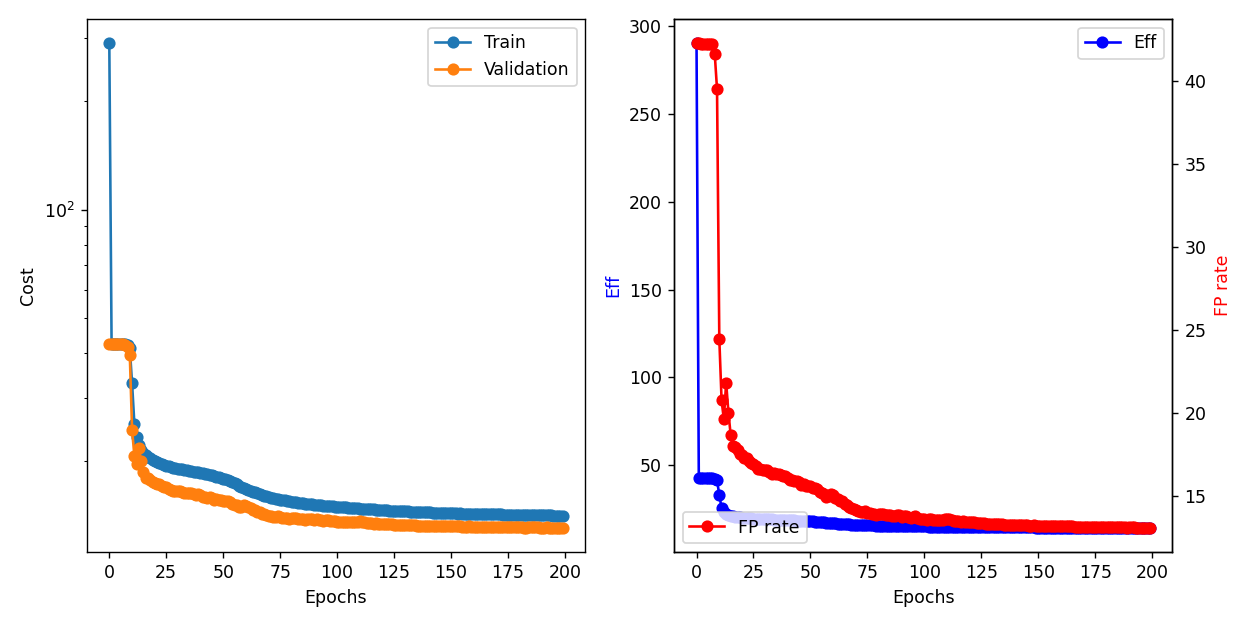

In [19]:
dual_train_plots(results.index,
                 results.cost, results.val,
                 results.cost, results.val)
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

In [20]:
from functions.utils import state_dict_to_vector
def angle_between(a, b):
    return np.arccos(np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)))

angle_grids = []
grid_size = 25
num_epochs = n_epochs
num_epochs2 = 0

ep_intervals = [(np.arange(0, num_epochs+num_epochs2+1, grid_size)[i], np.arange(0, num_epochs+num_epochs2+1, grid_size)[i+1]) for i in range(len(np.arange(0, num_epochs+num_epochs2+1, grid_size))-1)]

for interval in ep_intervals:
    
    these_param_states = []
    for i in range(interval[0], interval[1]):
        if i % 100 == 0:
            print(i)
        these_param_states.append(param_states[i])
        #print("Loaded", file_names[i])
        
    interval_size = len(these_param_states)-1    
    these_steps = [these_param_states[i+1]-these_param_states[i] for i in range(interval_size)]
    
    this_angle_grid = np.zeros((interval_size, interval_size))
    
    for i in range(interval_size):
        for j in range(i+1, interval_size):#range(i+1, interval_size):
            angle = angle_between(these_steps[i], these_steps[j])
            this_angle_grid[i,j] = angle
            this_angle_grid[j,i] = angle
            
    angle_grids.append(this_angle_grid)

0
100


<IPython.core.display.Javascript object>


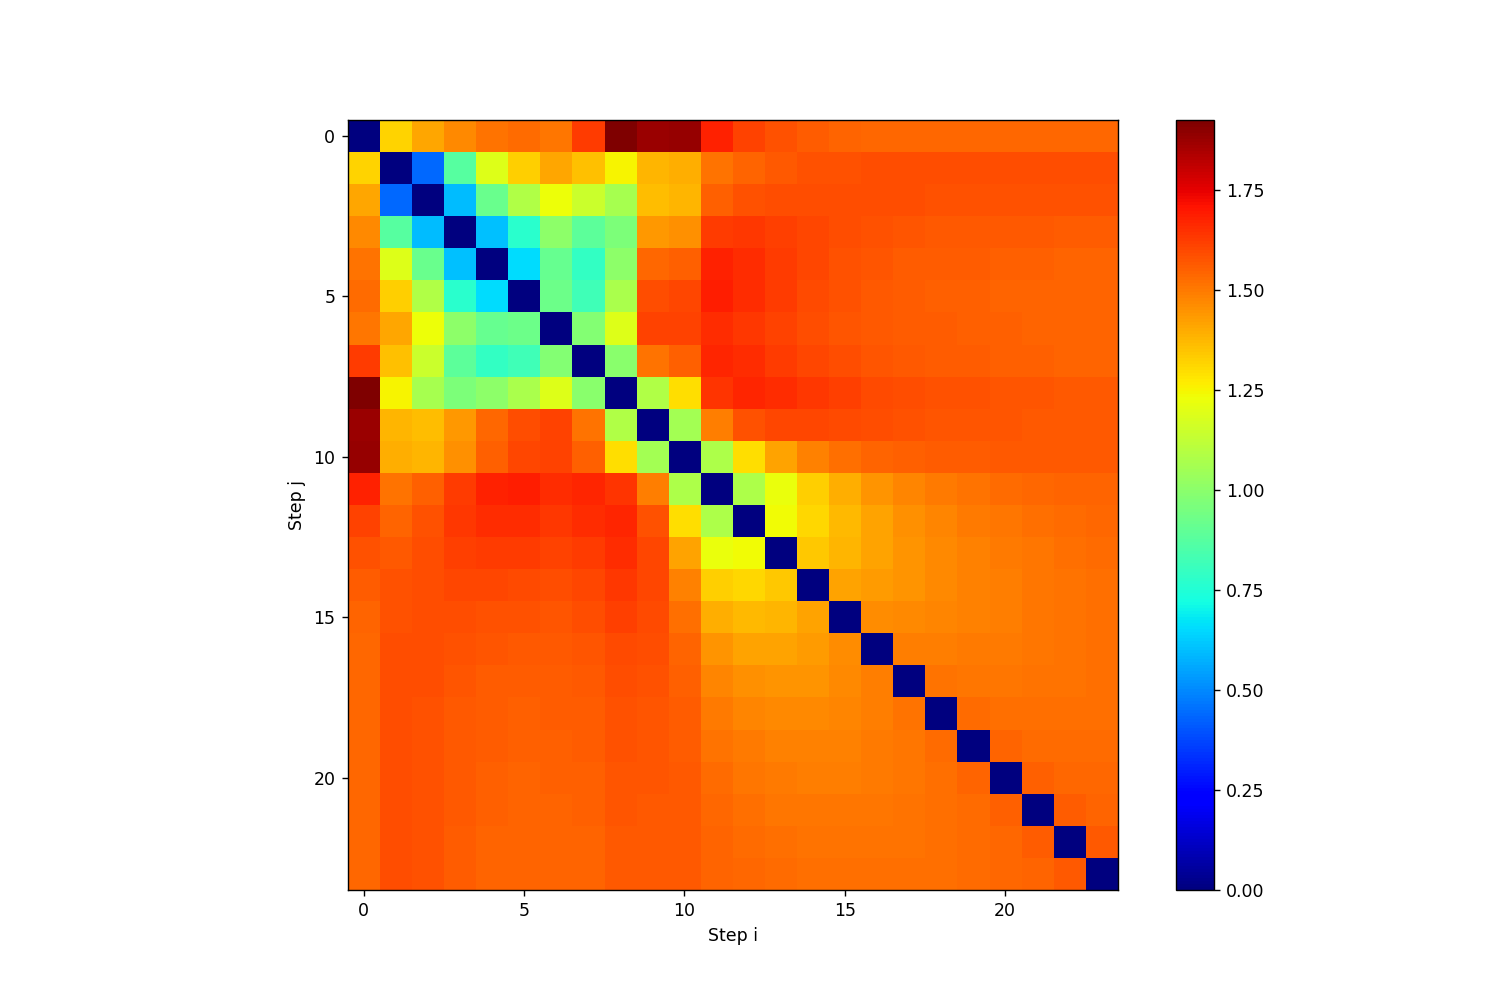

<IPython.core.display.Javascript object>


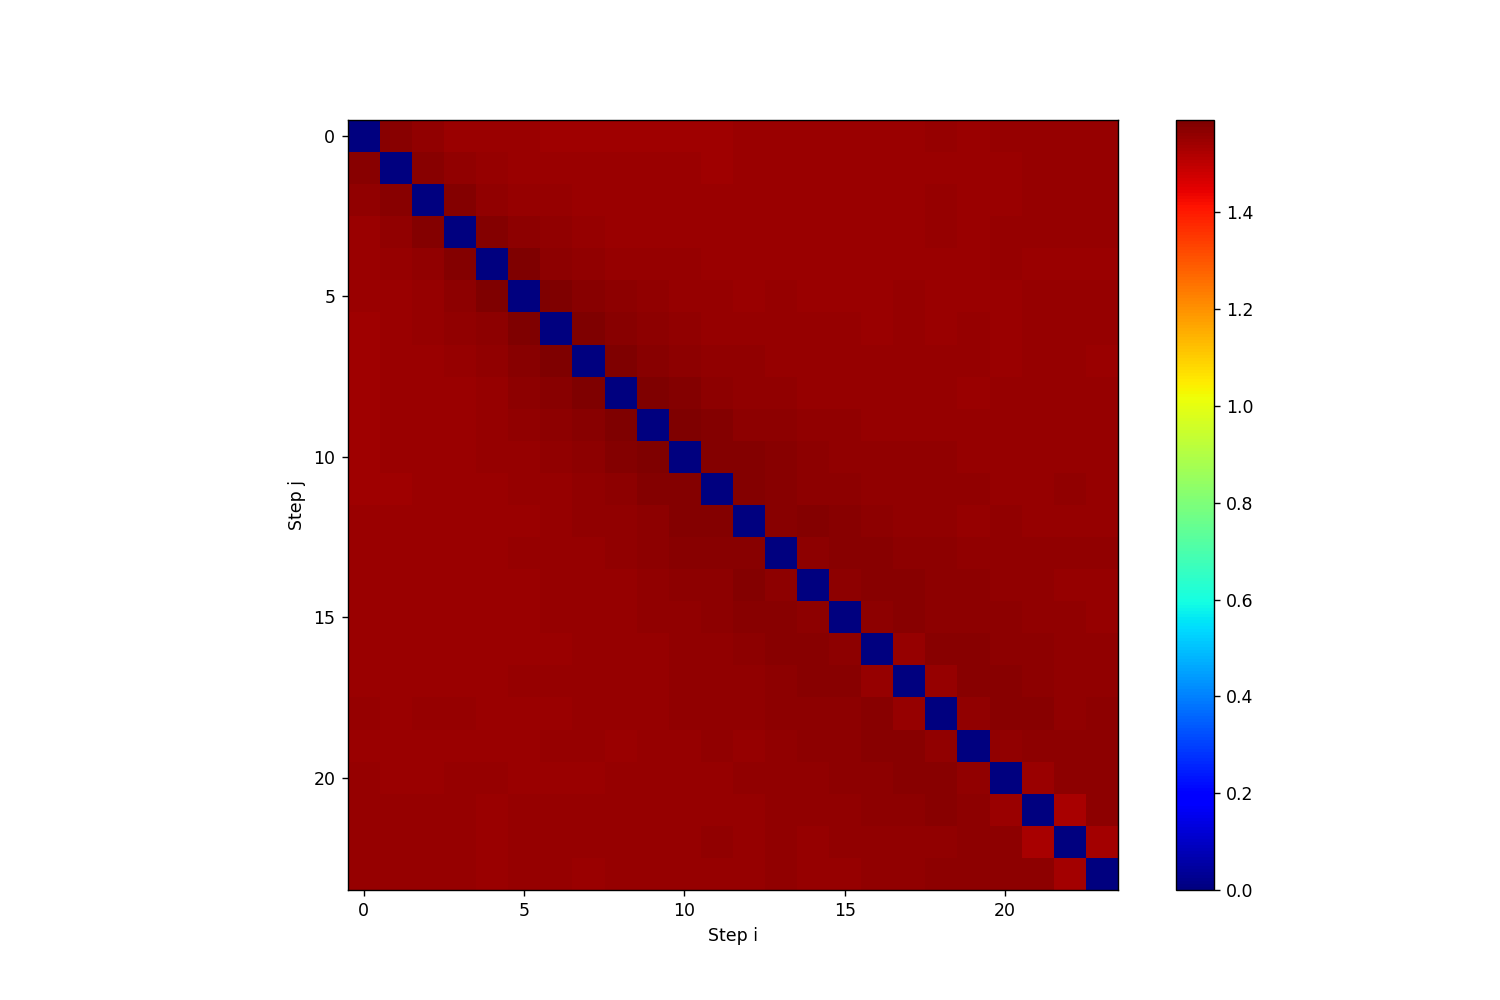

<IPython.core.display.Javascript object>


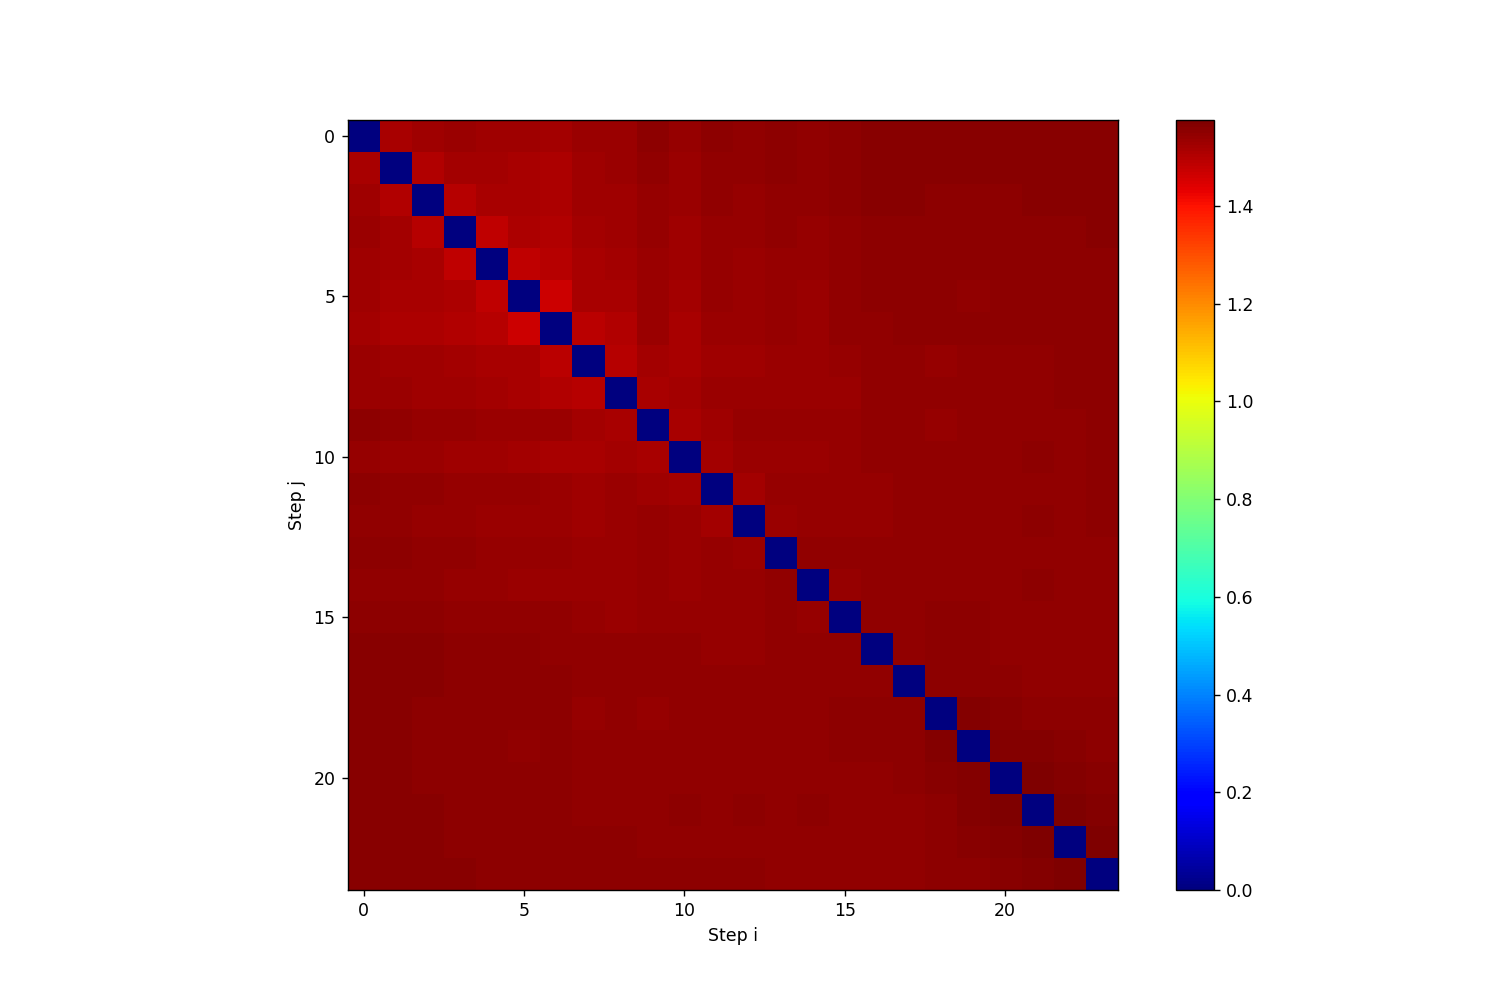

<IPython.core.display.Javascript object>


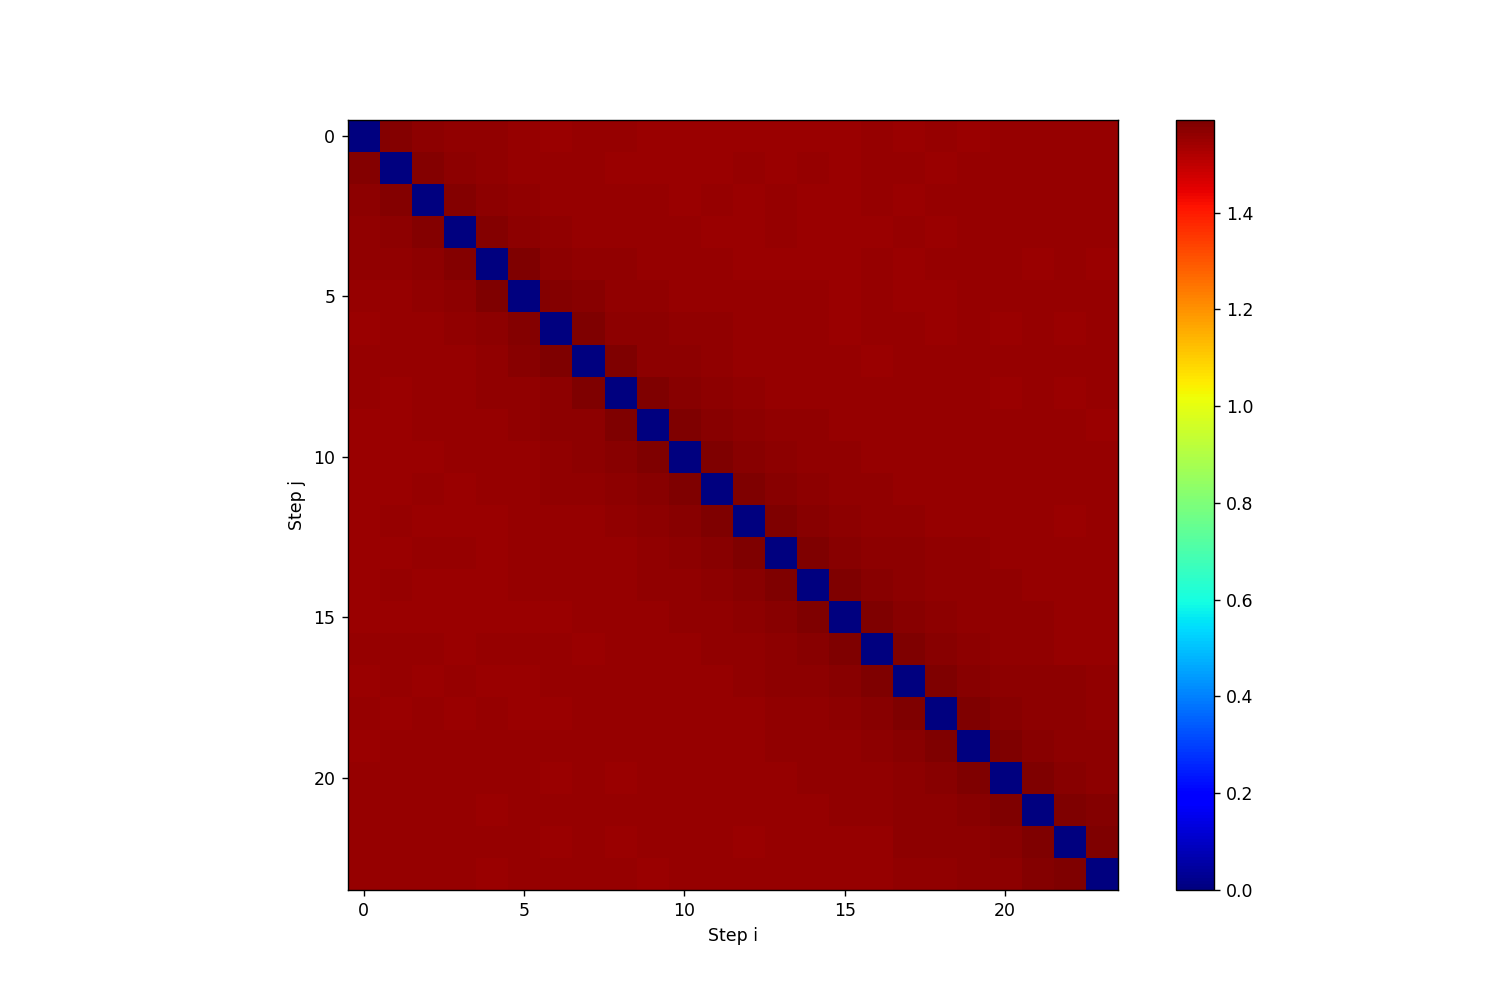

<IPython.core.display.Javascript object>


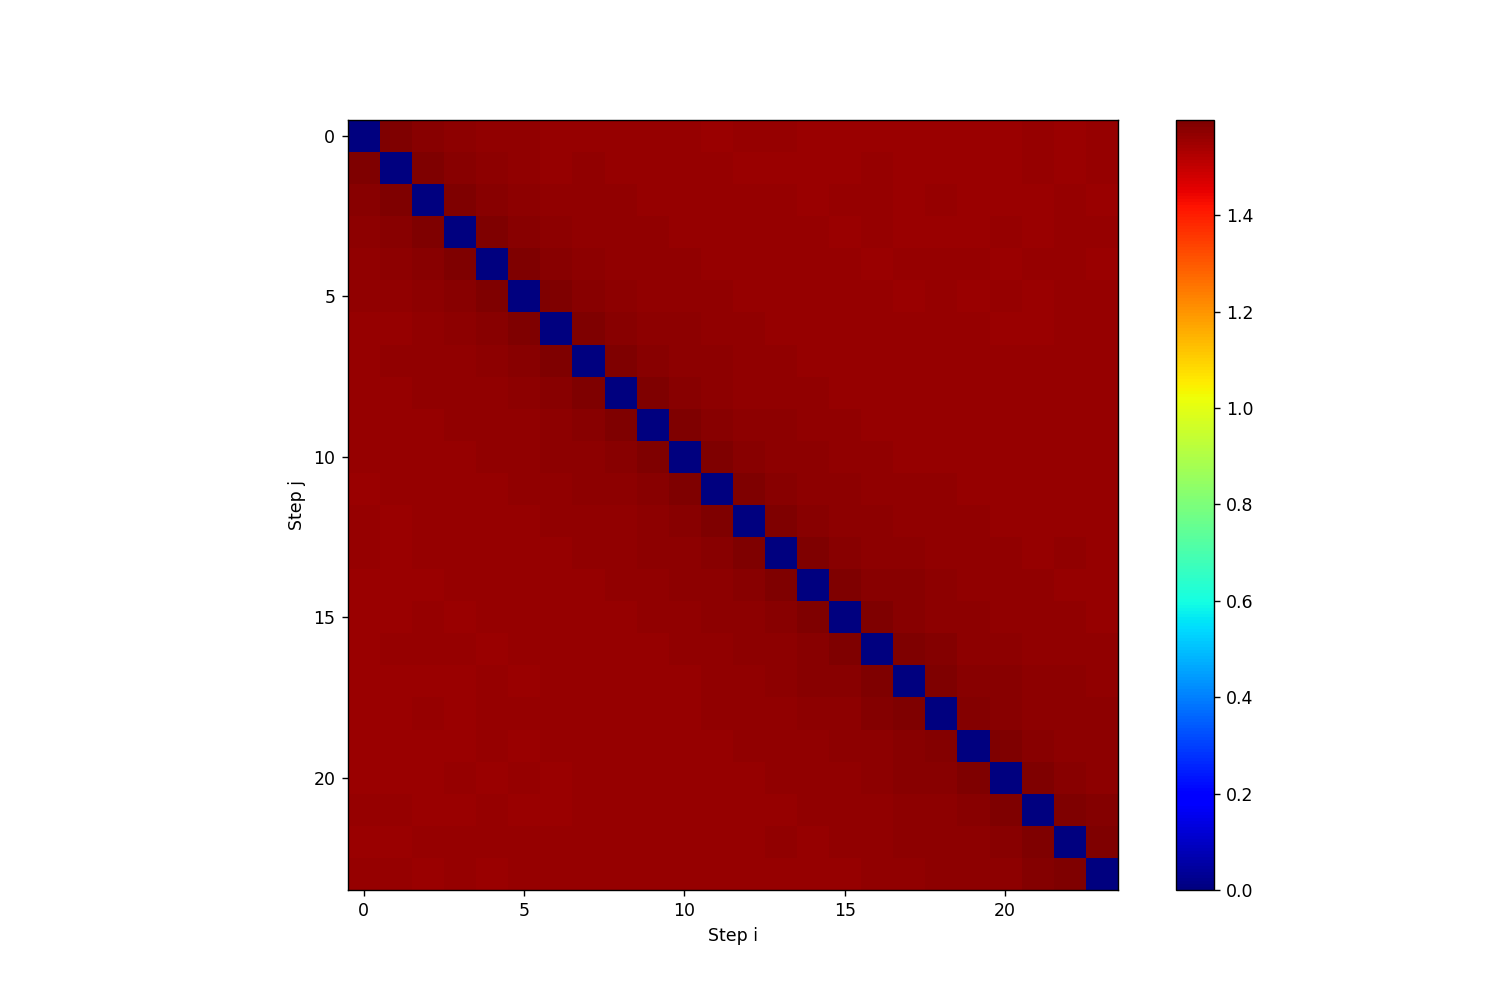

<IPython.core.display.Javascript object>


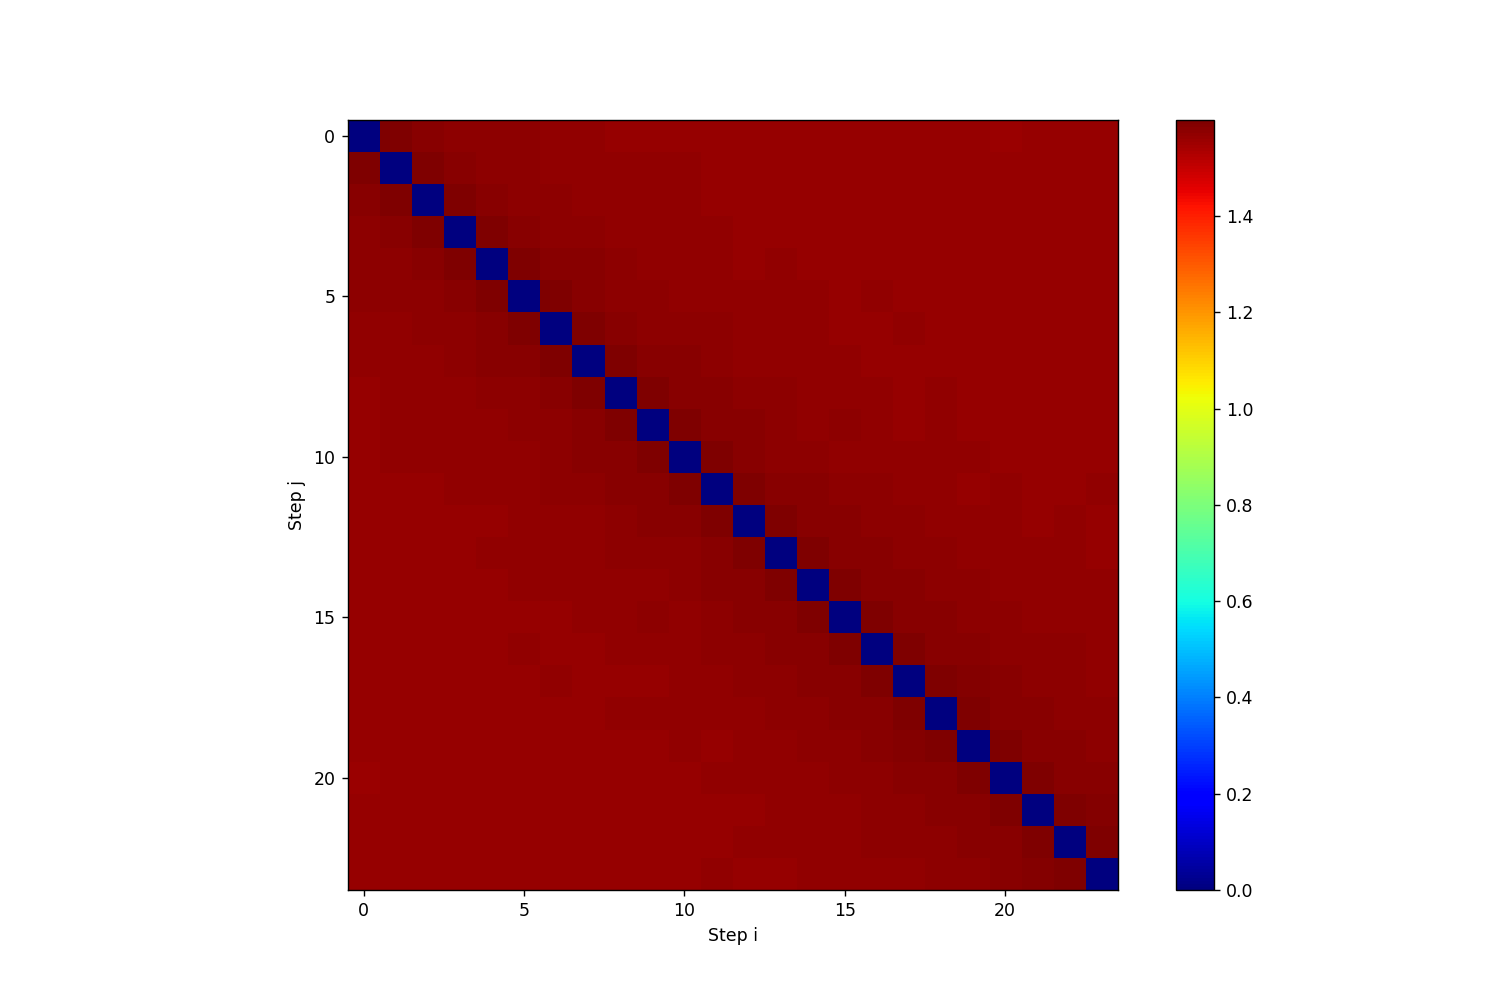

<IPython.core.display.Javascript object>


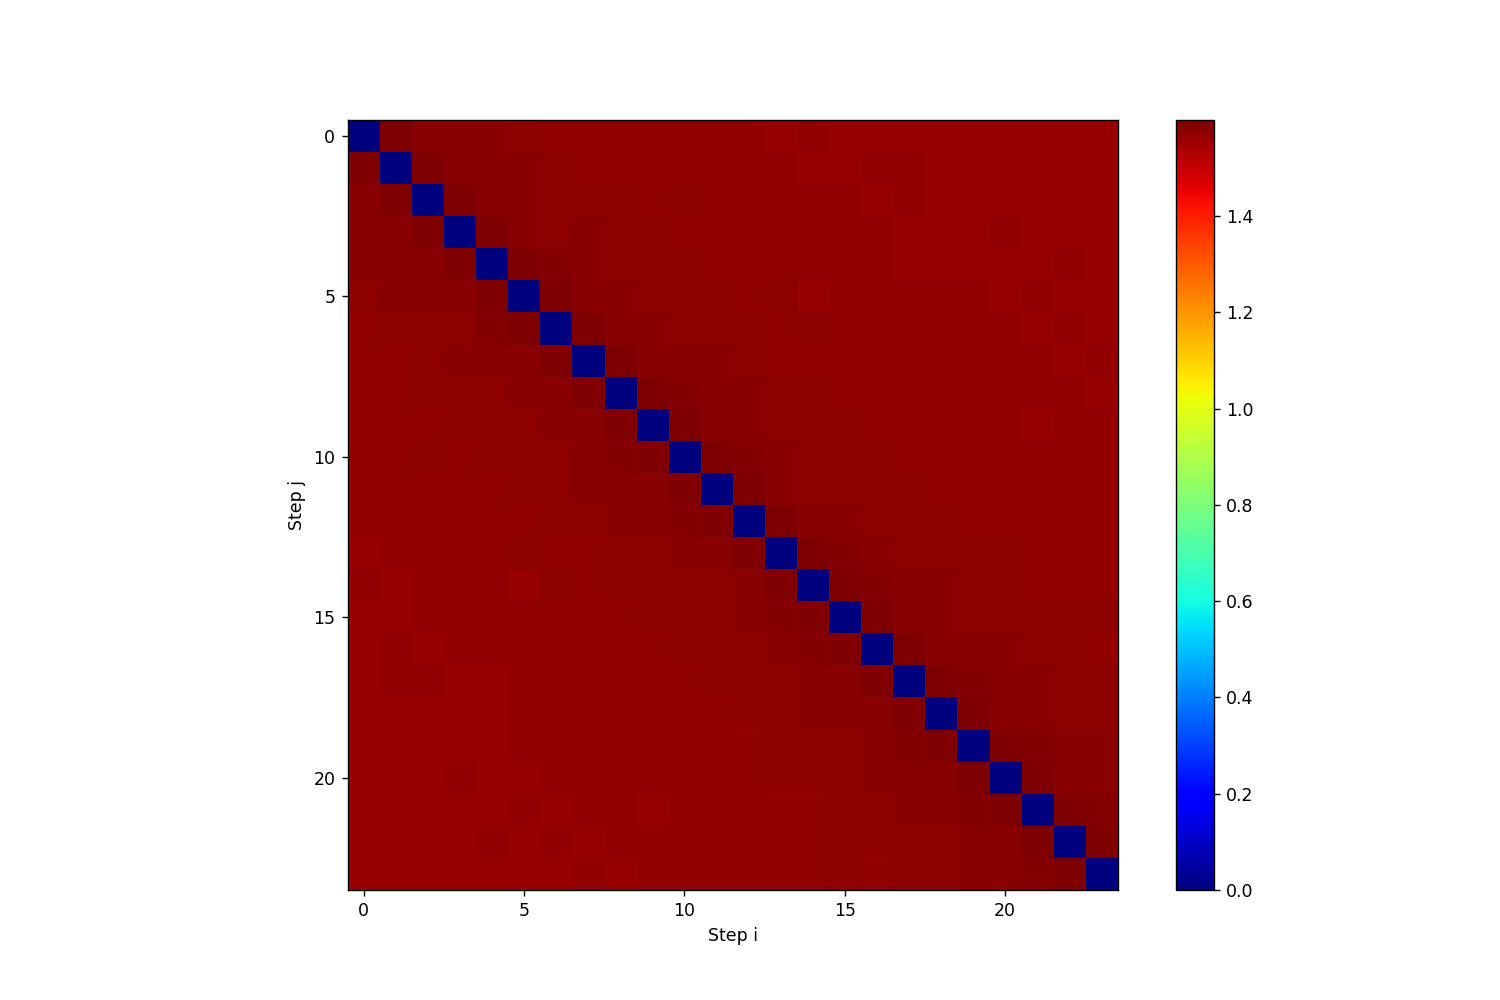

<IPython.core.display.Javascript object>


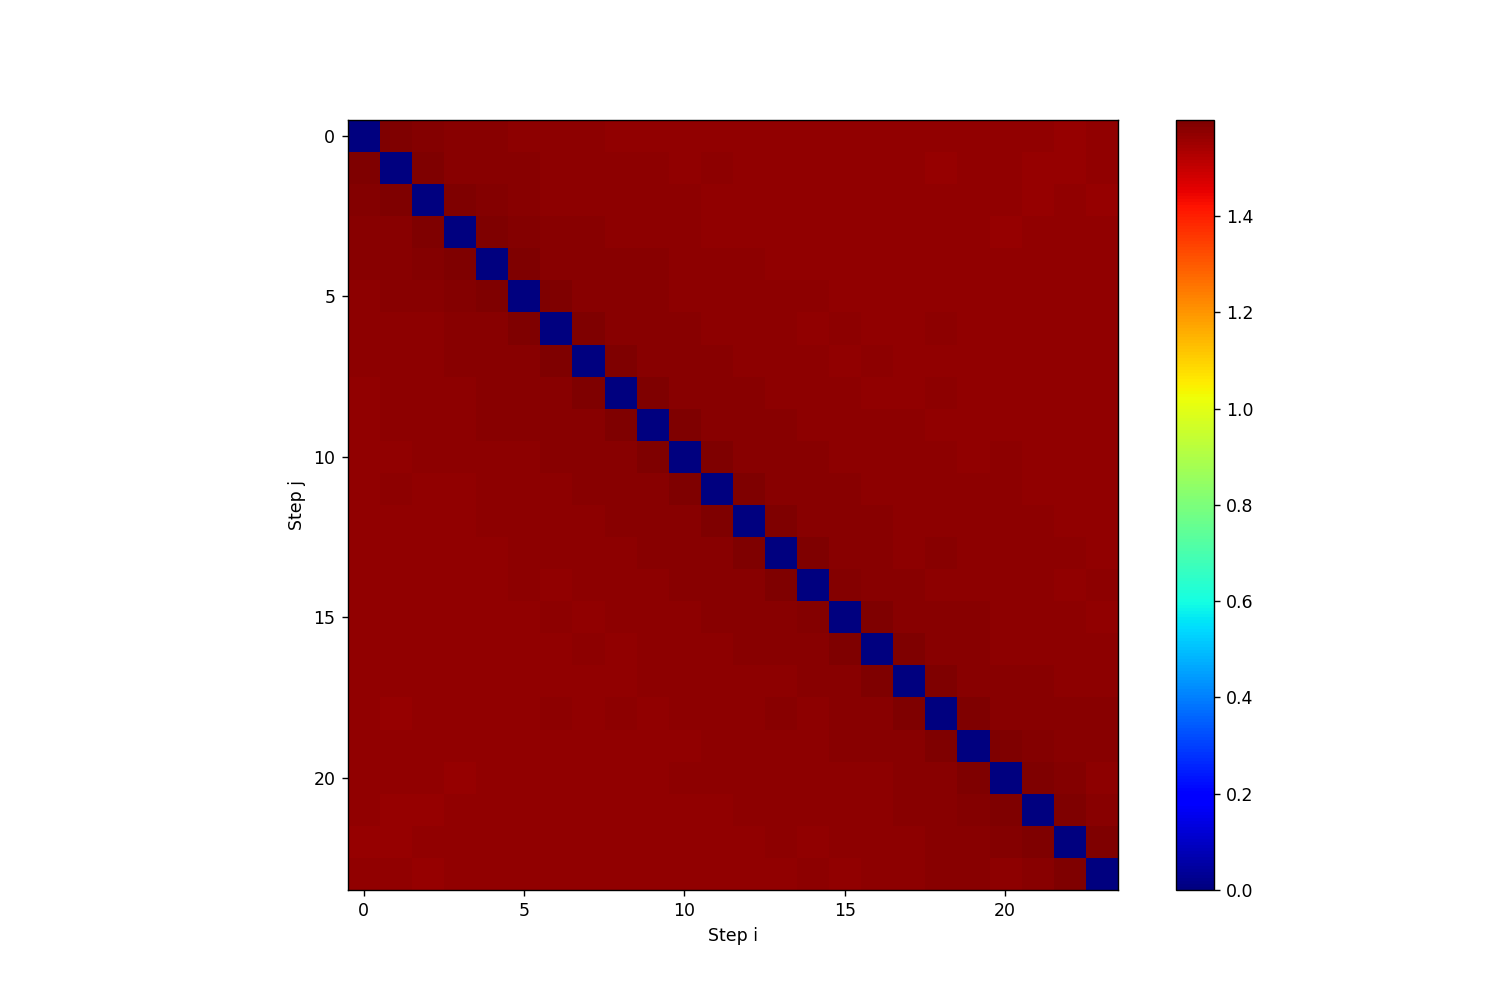

In [21]:
import matplotlib.colors as colors
import matplotlib.cm as cm

for angle_grid in angle_grids:
    plt.figure(figsize=(12,8))
    norm = colors.Normalize(vmin=np.amin(angle_grid), vmax=np.amax(angle_grid))   
    plt.imshow(angle_grid, cmap=cm.jet)
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.jet))
    plt.xlabel('Step i')
    plt.ylabel('Step j')
    
#print("num params:", len(these_param_states[0]))

In [22]:
# from functions.plotting_DDplus_hists import load_data
# from functions.utils import vector_to_state_dict

# state_dicts = []
# # num_epochs = 500
# for i in np.arange(0, num_epochs, 10):
#     state_dicts.append( (i, vector_to_state_dict(param_states[i], model)) )

# data = load_data()

In [23]:
# from functions.plotting_DDplus_hists import plot_DDplus_hists as Plot
# Plot(state_dicts, data)